# <center>PRACTICAL LECTURE 4</center>

# <center>PART1. Autoencoders </center>

1. Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/My Drive/tpsDeepLearning/

/content/gdrive/My Drive/tpsDeepLearning


In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

2. Convert vector to image
The following function allows to convert a vector to a image


In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

3. We now write a function which allows to display the images using the imshow() function.

In [ ]:
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

4. Define a data loading step and load the MNIST dataset

In [ ]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

5. Fix the used device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6. Define the Autoencoder model architecture and reconstruction loss
with : 
n = 28 x 28 = 784

A. Use d = 30  for standard AE (under-complete hidden layer)

B. Use d = 500 for denoising AE (over-complete hidden layer)

C. Explain the difference between standard AE and denoising AE.
Analyse the results and conclude.


## A. Use d = 30  for standard AE (under-complete hidden layer)

In [ ]:
28*28

784

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        # la fonction d'activation utilisée ici c'est la tangente hyperbolique (tanh)
        # cette fonction est utile dans des situations où on n'a pas forcément une probabilité à ressortir
        # elle varie entre -1 et 1
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    # fonction qui permet d'encoder et décoder l'information
    def forward(self, x):
        x = self.encoder(x) # étape d'encogage partant de la couche d'entrée à la seule couche cachée 
        x = self.decoder(x) # étape de décodage partant de la couche d'entrée à la seule couche cachée 
        return x

In [ ]:
d=30;
model = Autoencoder(d).to(device)
criterion = nn.MSELoss() # on définit un critère qui va nous servir pour la fonction de coût

7. Configure the optimiser. We use here : learning_rate equals to 1e-3

In [ ]:
learning_rate = 1e-3 # soit 0.001, ce qui est pas mal

#  l'optimizer permet d'appliquer l'algo du gradient pour minimiser le coût
optimizer = torch.optim.Adam(
    model.parameters(), # permet de récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate, # permet de déterminer la vitesse à laquelle on ajuste les poids
)

8. Train the standard autoencoder and the denoising autoencoder using the following code :


In [ ]:
def training_sae(num_epochs, model, criterion, optimizer):
  #num_epochs = num_epochs
  epoch_loss_sae =[]
  # do = nn.Dropout()  # comment out for standard AE
  for epoch in range(num_epochs):
      for data in dataloader:
          img, _ = data
          img = img.to(device)
          img = img.view(img.size(0), -1)
          # noise = do(torch.ones(img.shape)).to(device)
          # img_bad = (img * noise).to(device)  # comment out for standard AE
          # ===================forward=====================
          output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
          loss = criterion(output, img.data) #calcul the loss (erreur) function using MSE
          # ===================backward====================
          optimizer.zero_grad() # set the gradients to zero
          loss.backward()  # calcule les gradients, ceci permet de savoir dans quelle direction on va ajuster les poids
                          # Esk les poids vont augmenter ou diminuer
          optimizer.step() # mise a jour des poids, ceci détermine l'intensité à laquelle les poids sont mis à jour
      # ===================log========================
      print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}') #4f pour dire qu'on garde 4 chiffres après la virgule
      epoch_loss_sae.append(loss.item())
      display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE
  return epoch_loss_sae

epoch [1/20], loss:0.2036
epoch [2/20], loss:0.1460
epoch [3/20], loss:0.1225
epoch [4/20], loss:0.1081
epoch [5/20], loss:0.0970
epoch [6/20], loss:0.0830
epoch [7/20], loss:0.0859
epoch [8/20], loss:0.0796
epoch [9/20], loss:0.0803
epoch [10/20], loss:0.0737
epoch [11/20], loss:0.0690
epoch [12/20], loss:0.0670
epoch [13/20], loss:0.0677
epoch [14/20], loss:0.0624
epoch [15/20], loss:0.0661
epoch [16/20], loss:0.0603
epoch [17/20], loss:0.0561
epoch [18/20], loss:0.0579
epoch [19/20], loss:0.0594
epoch [20/20], loss:0.0606


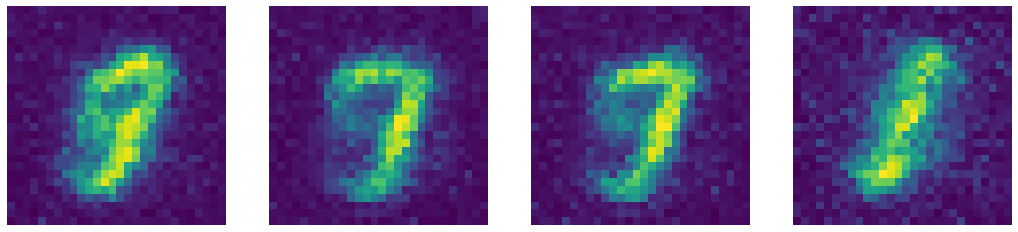

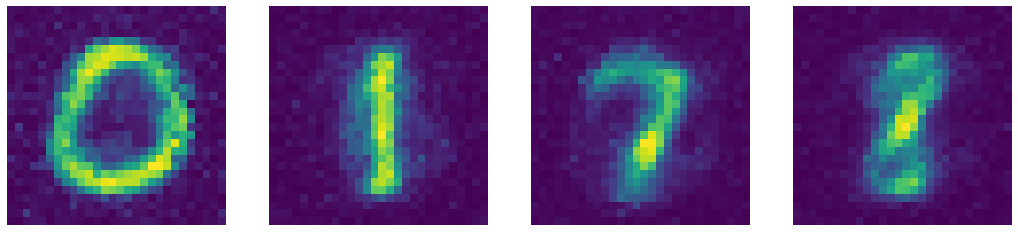

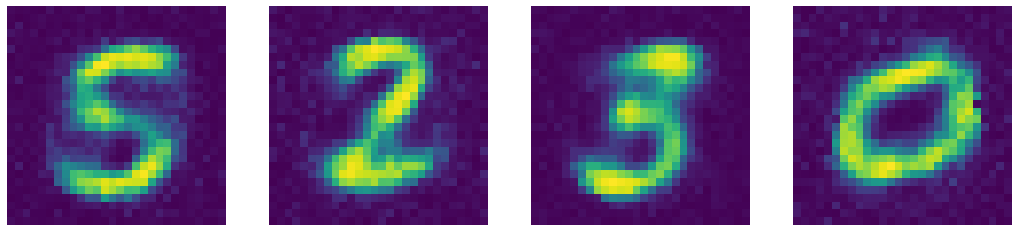

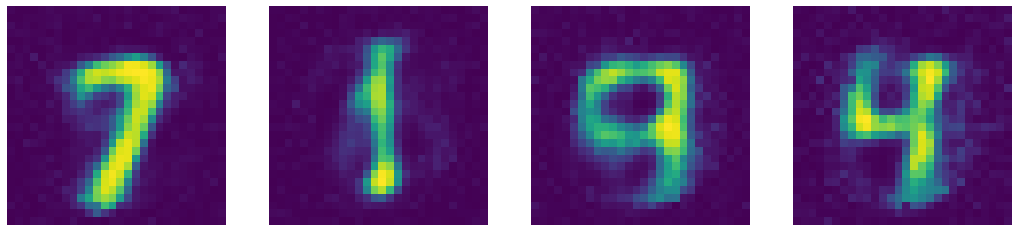

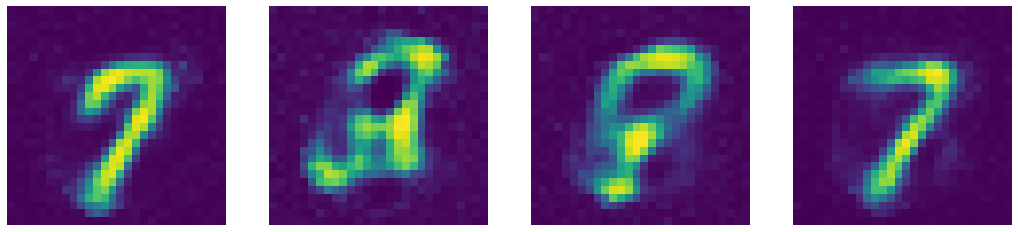

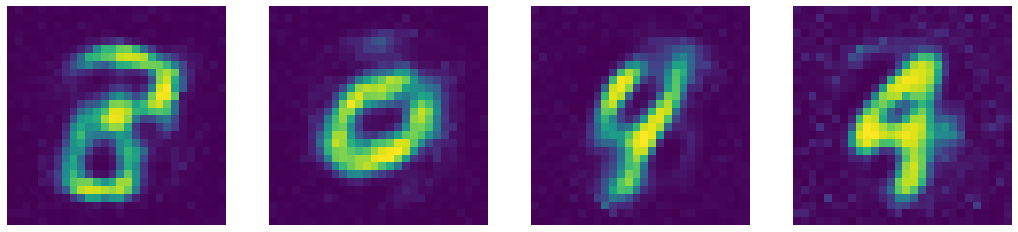

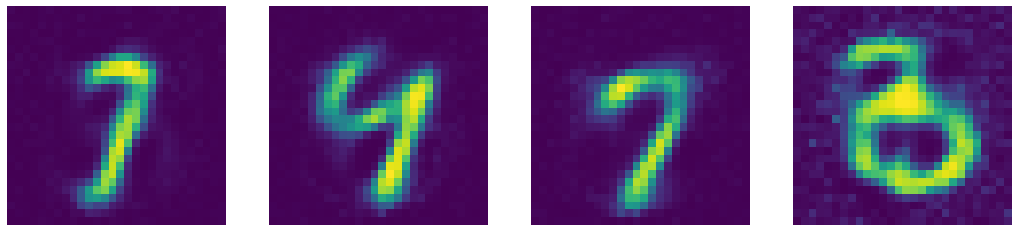

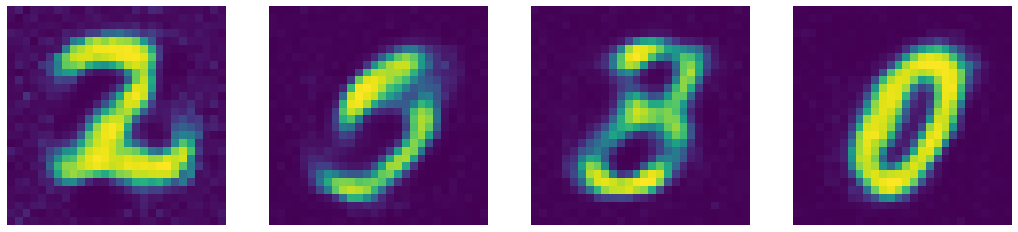

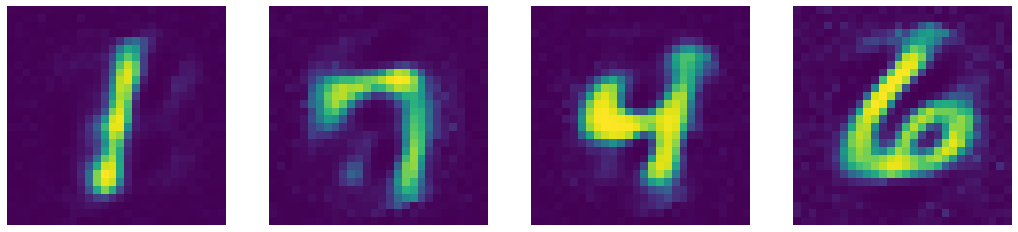

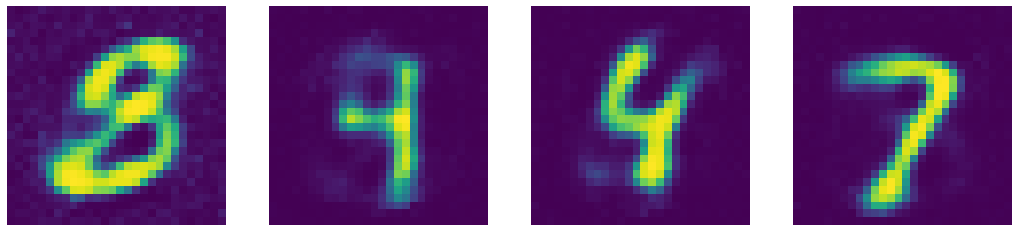

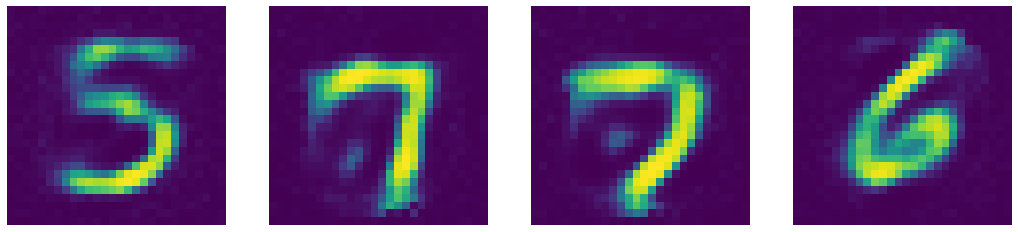

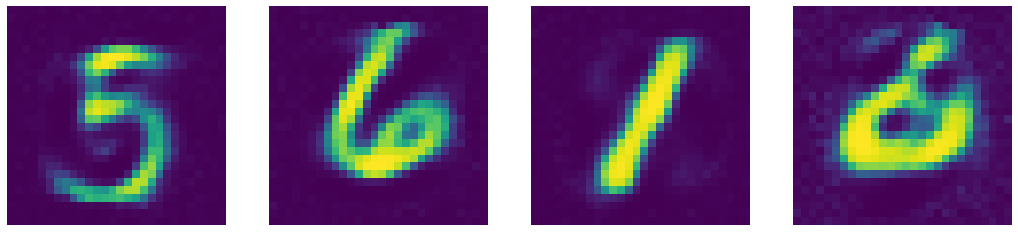

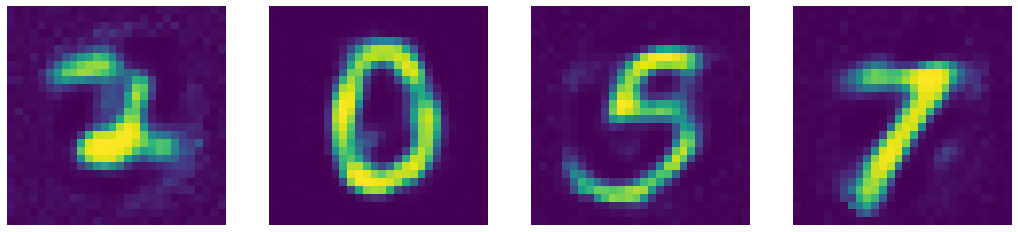

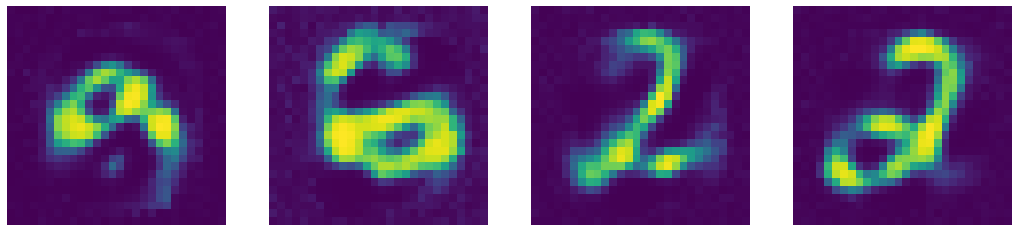

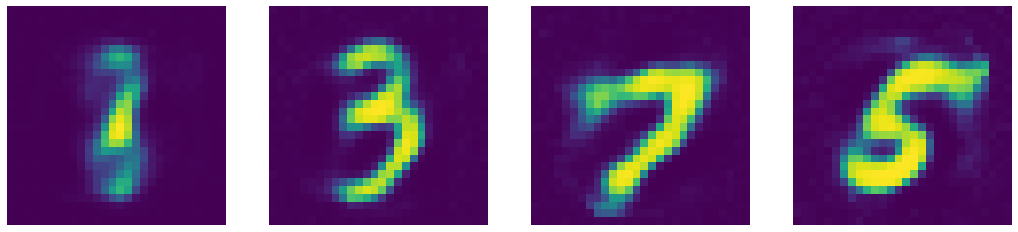

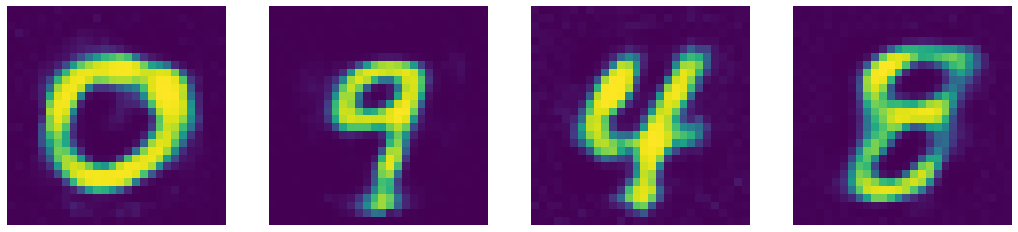

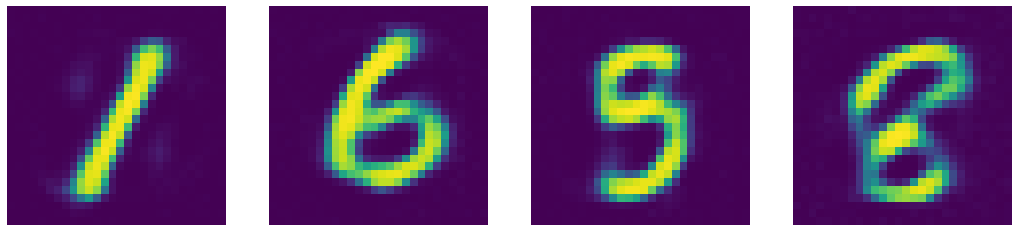

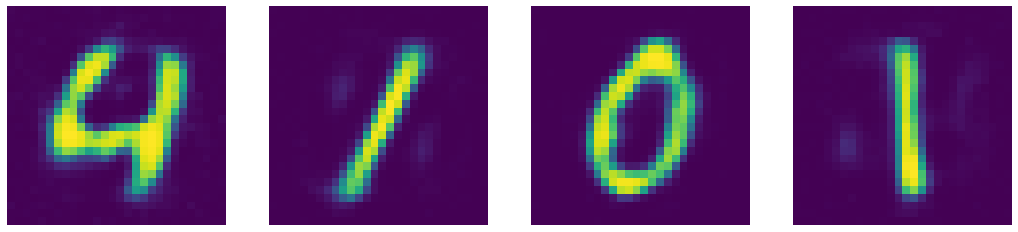

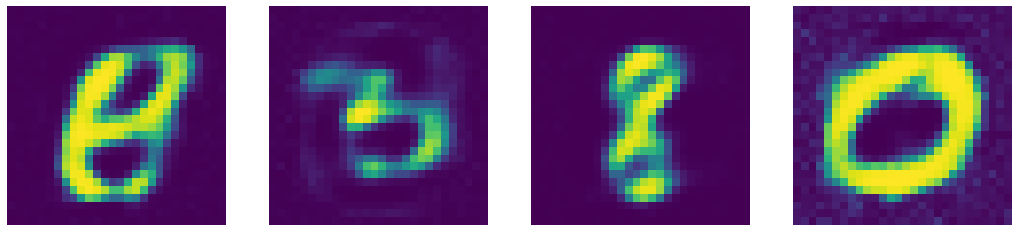

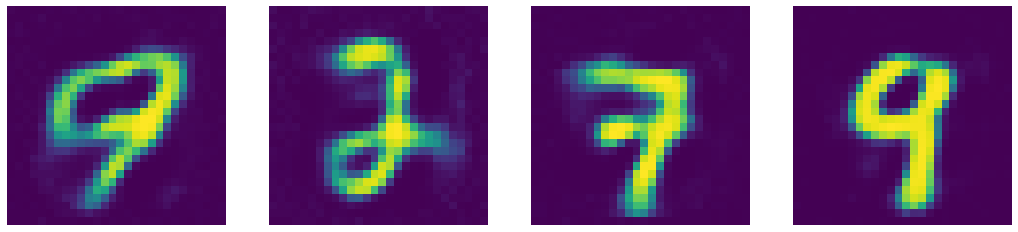

In [ ]:
nb_epoch = 20
epoch_loss_sae = training_sae(nb_epoch, model, criterion, optimizer)

9. Visualise a few kernels of the encoder :


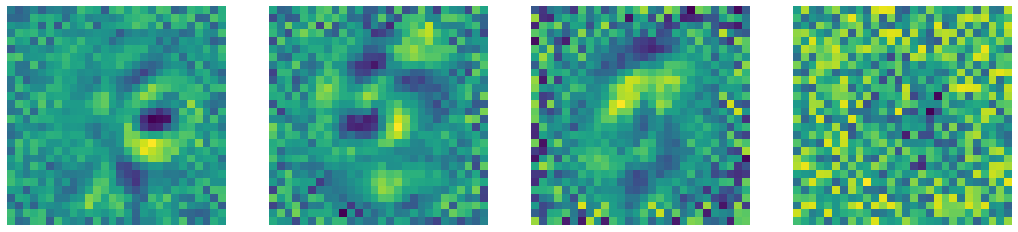

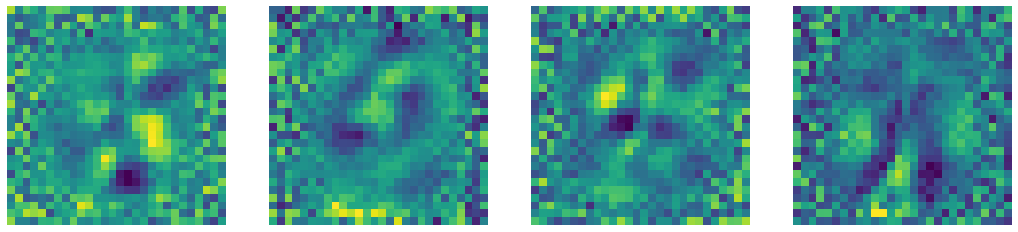

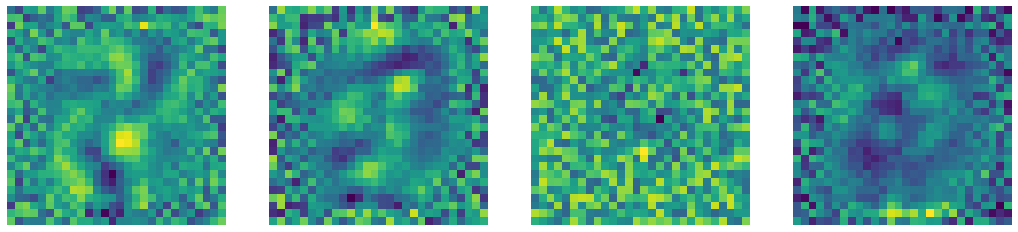

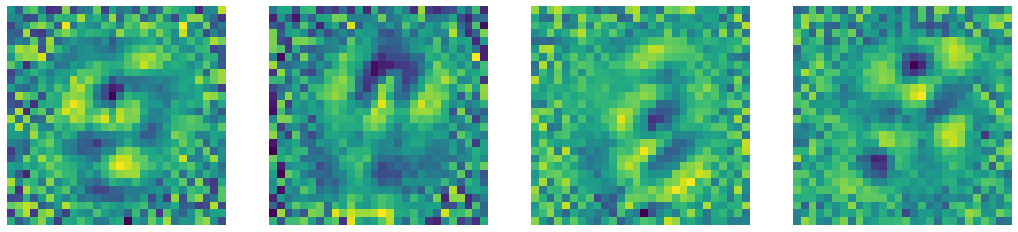

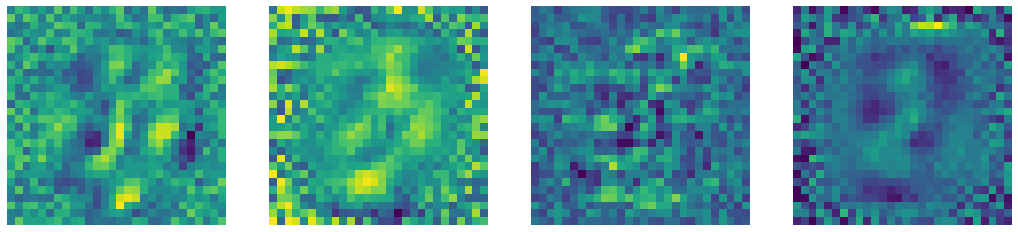

In [ ]:
display_images(None, model.encoder[0].weight, 5)

## B. Use d = 500 for denoising AE (over-complete hidden layer)


In [ ]:
d=500;
model1 = Autoencoder(d).to(device);

Configure the optimiser. We use here : learning_rate equals to 1e-3

In [ ]:
#  l'optimizer permet d'appliquer l'algo du gradient pour minimiser le coût
optimizer1 = torch.optim.Adam(
    model1.parameters(), # permet de récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate, # permet de déterminer la vitesse à laquelle on ajuste les poids
)

Train the standard autoencoder and the denoising autoencoder using the following code :

In [ ]:
def training_dae(num_epochs, model, criterion, optimizer):
  epoch_loss_dae =[]
  do = nn.Dropout()  # comment out for standard AE
  for epoch in range(num_epochs):
      for data in dataloader:
          img, _ = data
          img = img.to(device)
          img = img.view(img.size(0), -1)
          noise = do(torch.ones(img.shape)).to(device) # le bruit
          img_bad = (img * noise).to(device)  # comment out for standard AE
          # ===================forward=====================
          output = model(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
          loss = criterion(output, img.data) #calcul the loss (erreur) function using MSE
          # ===================backward====================
          optimizer.zero_grad() # set the gradients to zero
          loss.backward()  # calcule les gradients, ceci permet de savoir dans quelle direction on va ajuster les poids
                          # Esk les poids vont augmenter ou diminuer
          optimizer.step() # mise a jour des poids, ceci détermine l'intensité à laquelle les poids sont mis à jour
      # ===================log========================
      print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
      epoch_loss_dae.append(loss.item())
      display_images(img_bad, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE
  return epoch_loss_dae

epoch [1/20], loss:0.0710
epoch [2/20], loss:0.0557
epoch [3/20], loss:0.0550
epoch [4/20], loss:0.0498
epoch [5/20], loss:0.0476
epoch [6/20], loss:0.0478
epoch [7/20], loss:0.0457
epoch [8/20], loss:0.0467
epoch [9/20], loss:0.0435
epoch [10/20], loss:0.0437
epoch [11/20], loss:0.0409


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


epoch [12/20], loss:0.0443
epoch [13/20], loss:0.0417
epoch [14/20], loss:0.0402
epoch [15/20], loss:0.0412
epoch [16/20], loss:0.0413
epoch [17/20], loss:0.0385
epoch [18/20], loss:0.0413
epoch [19/20], loss:0.0409
epoch [20/20], loss:0.0435


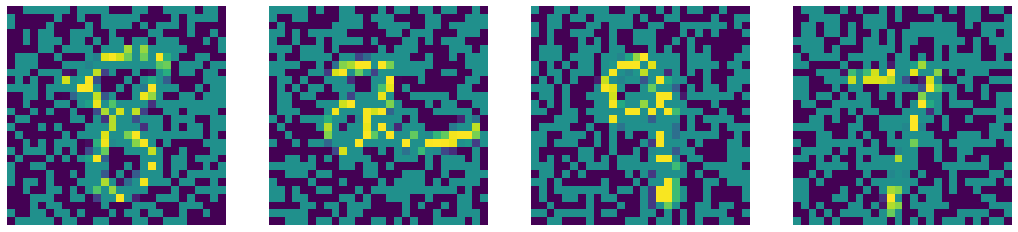

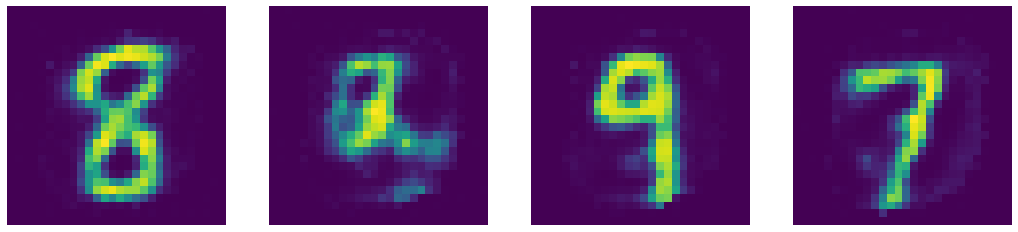

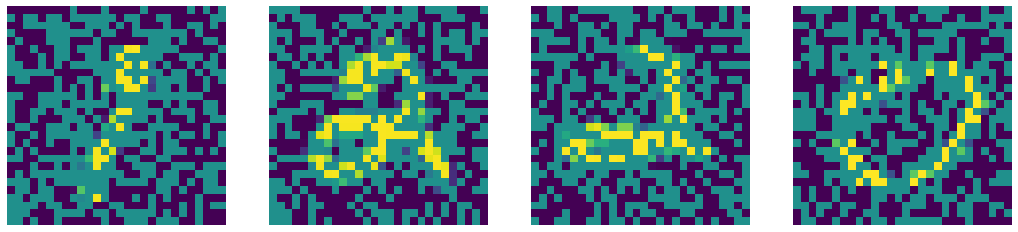

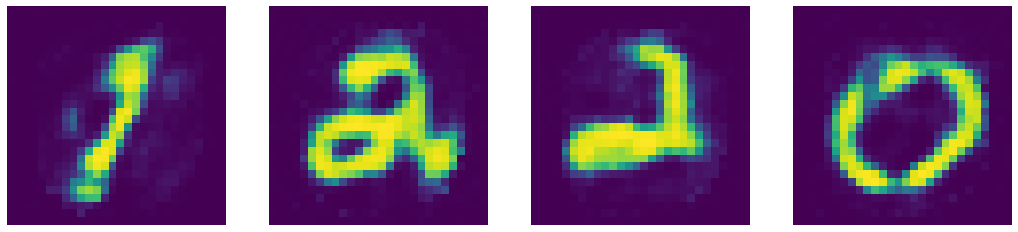

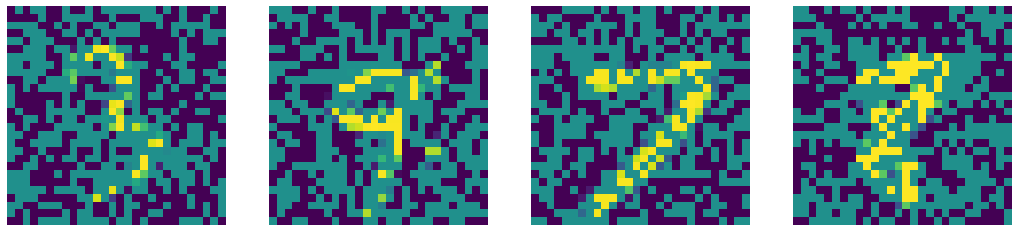

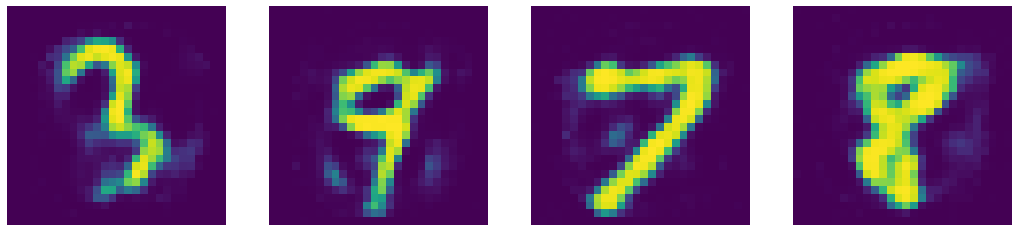

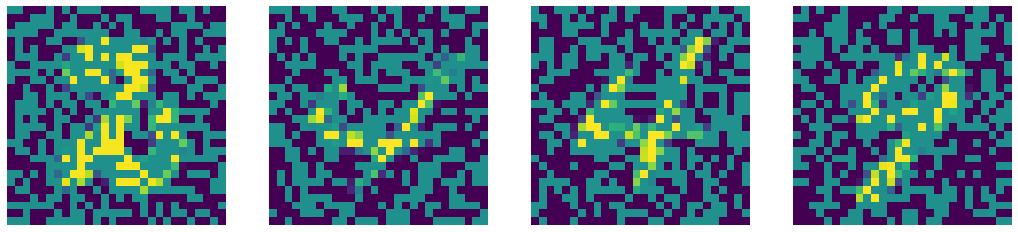

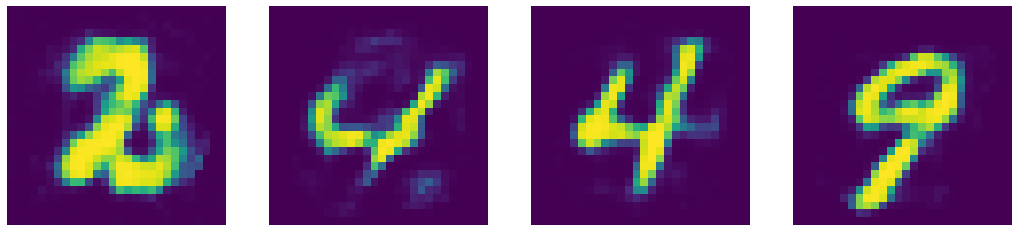

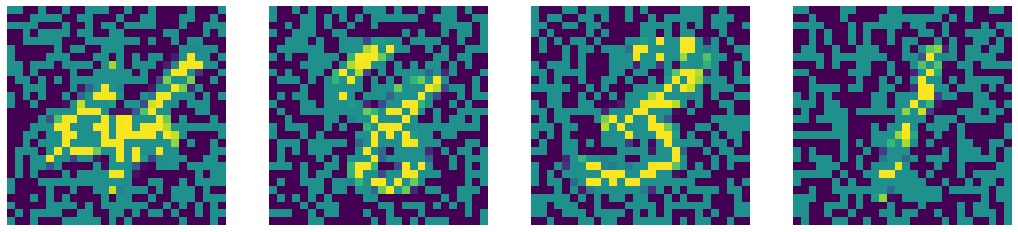

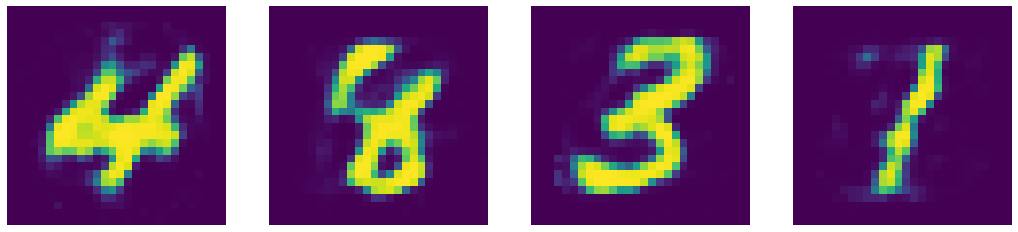

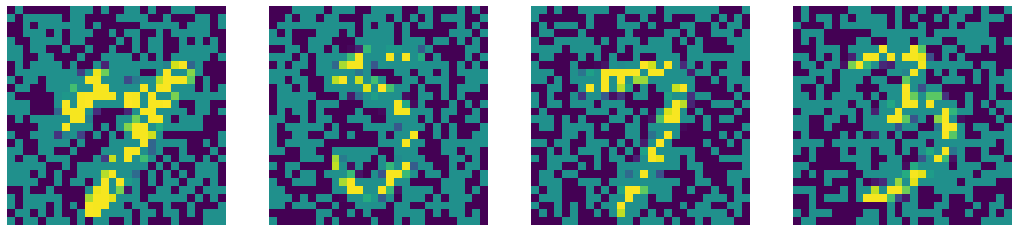

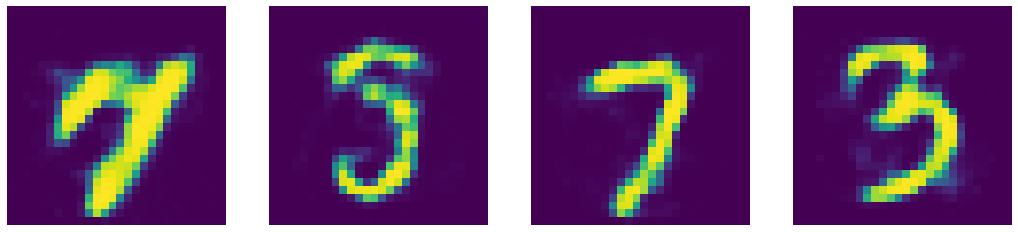

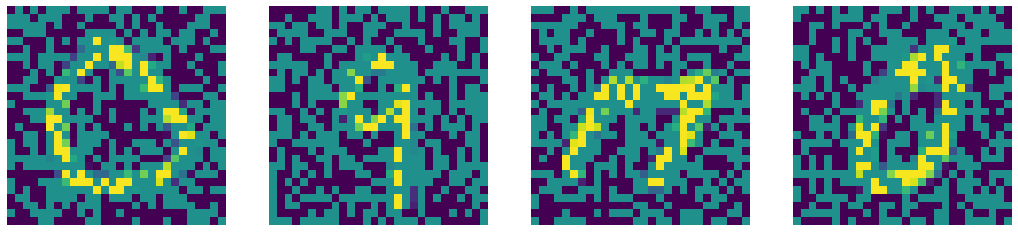

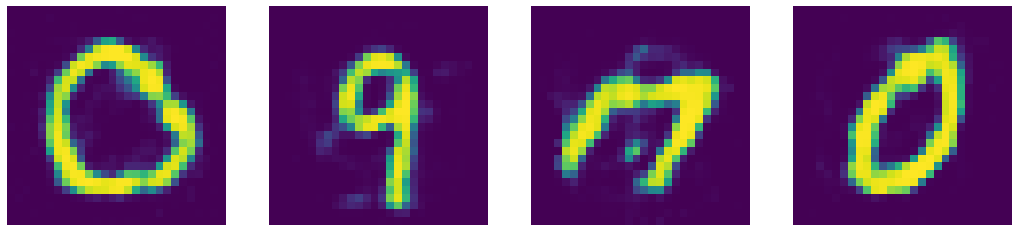

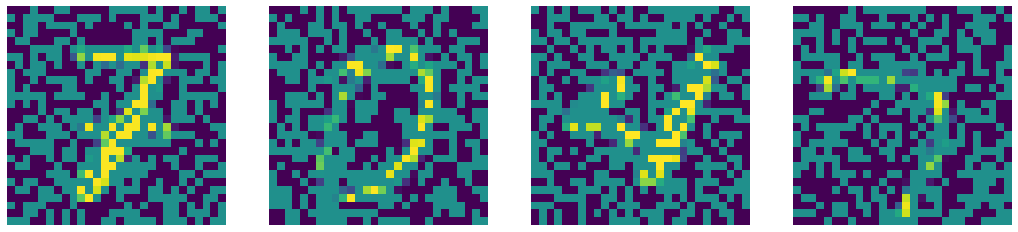

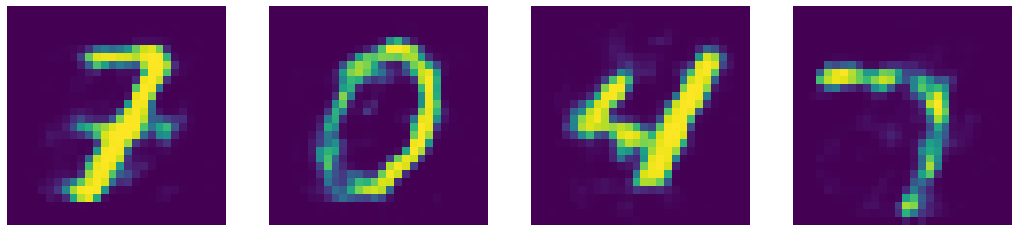

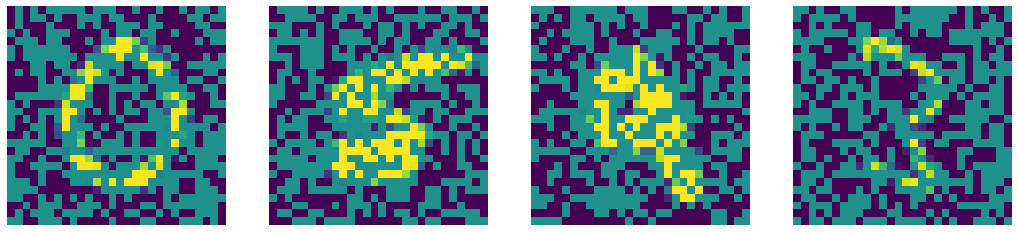

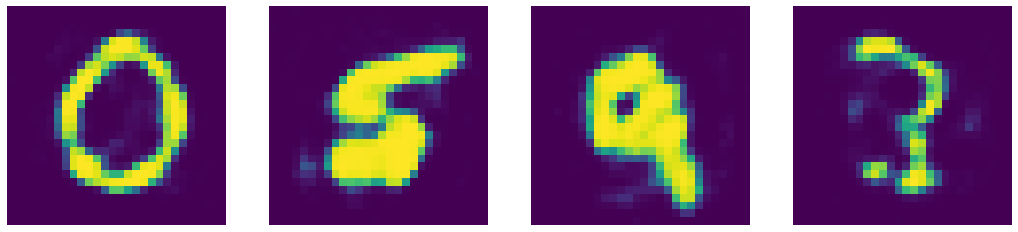

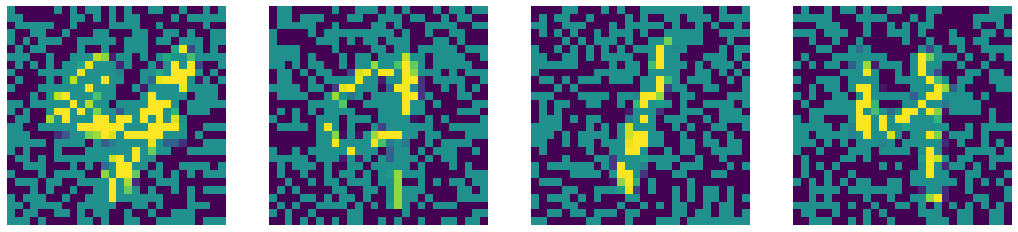

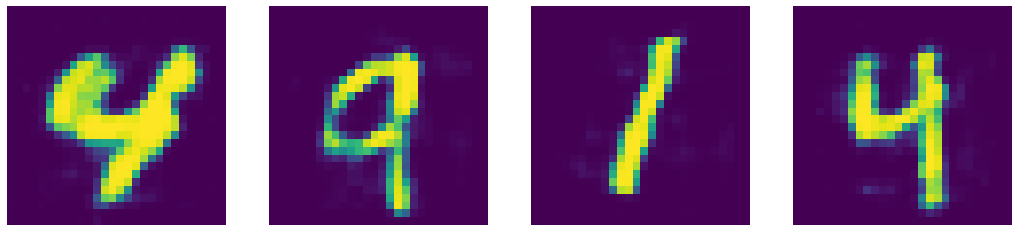

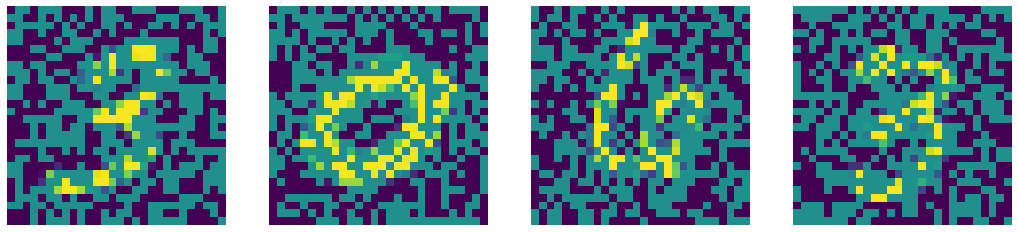

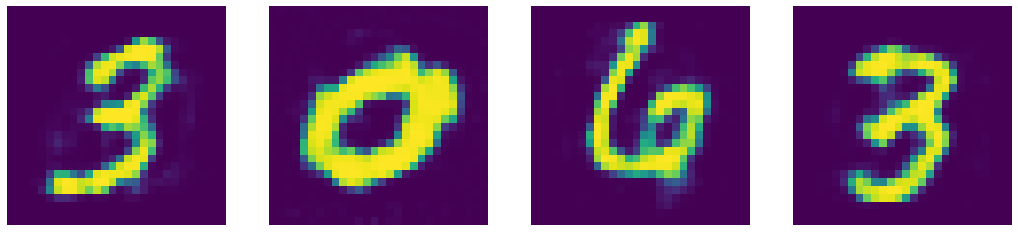

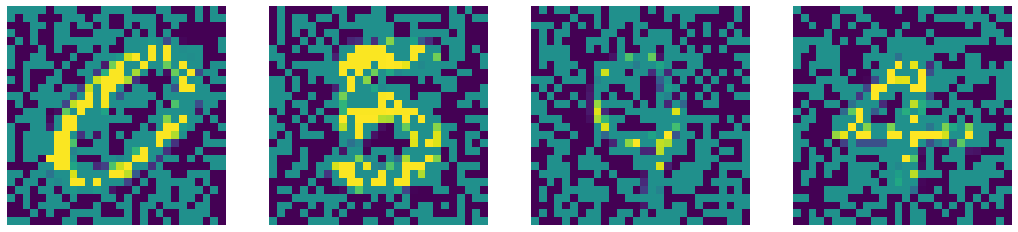

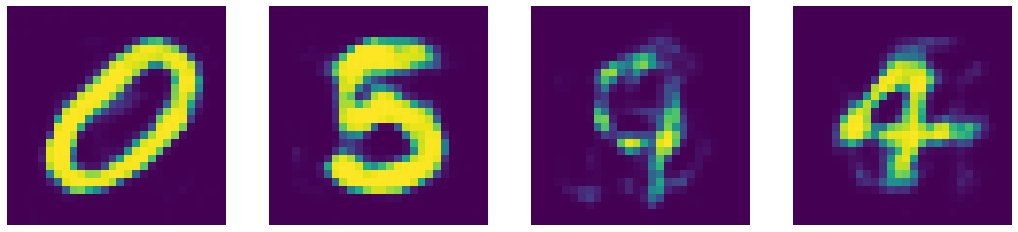

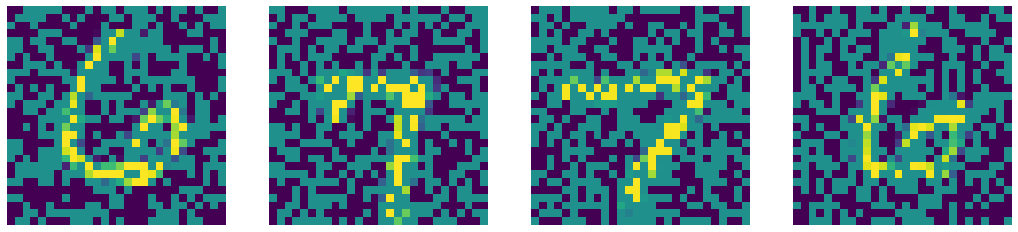

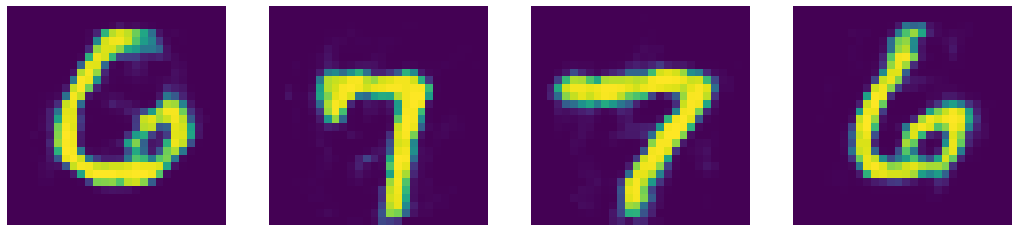

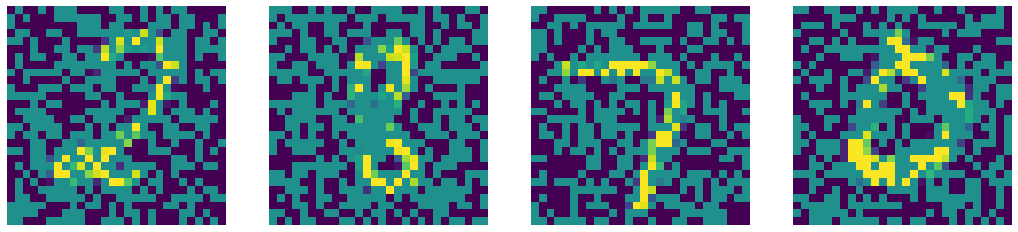

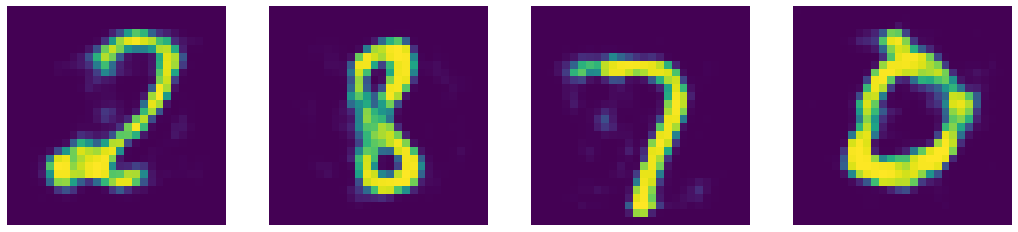

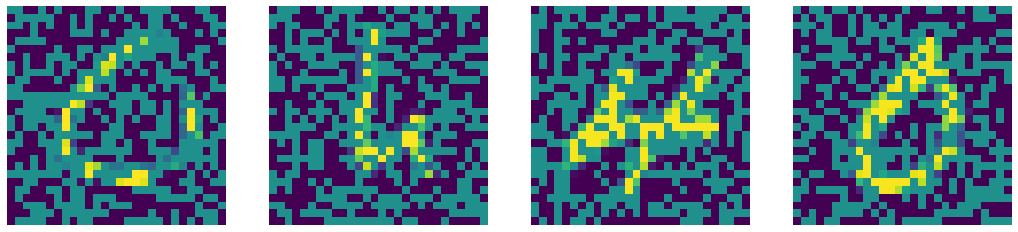

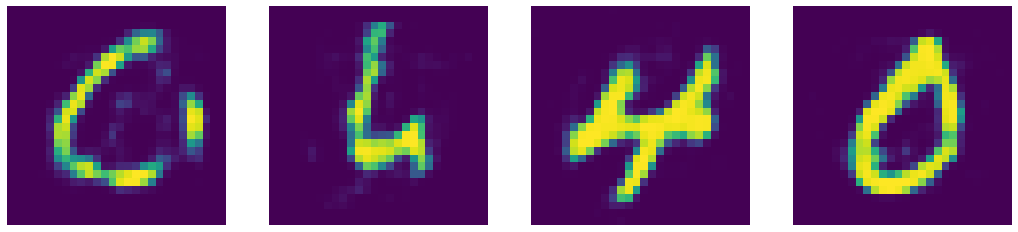

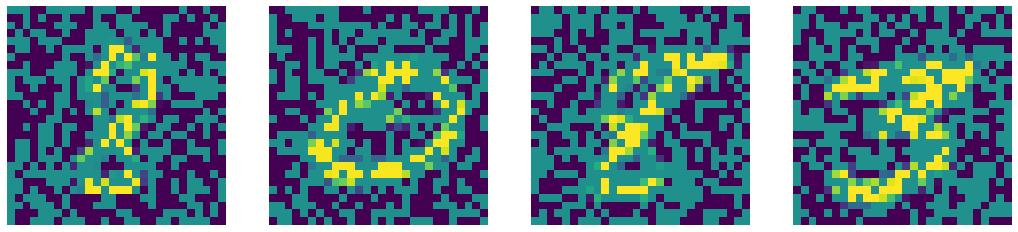

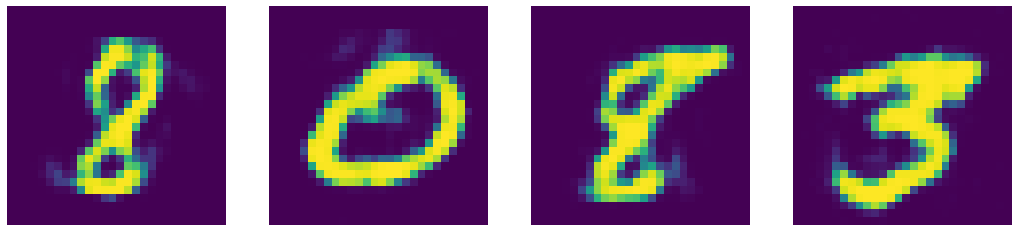

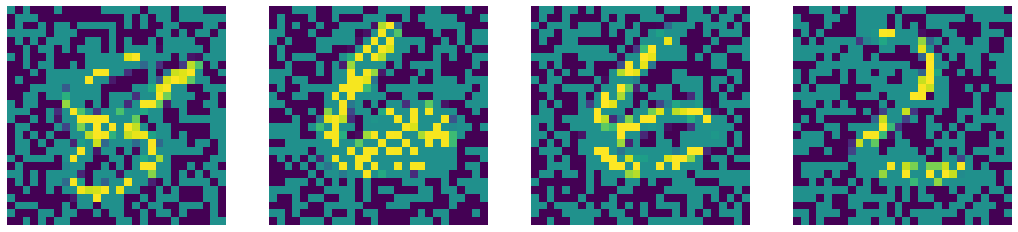

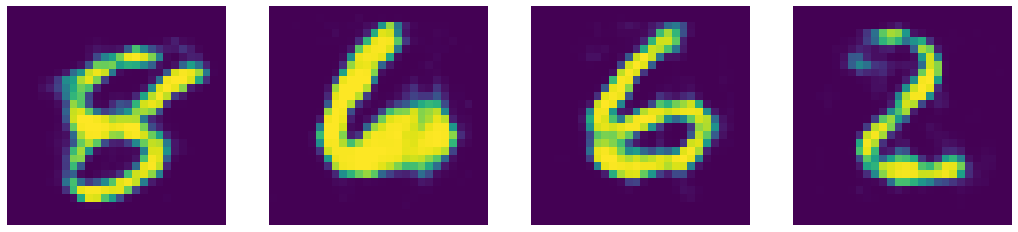

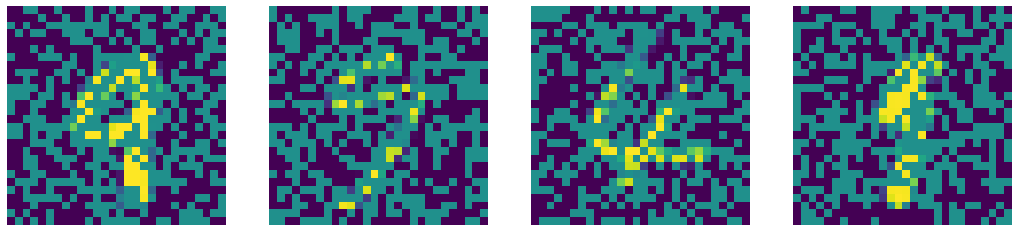

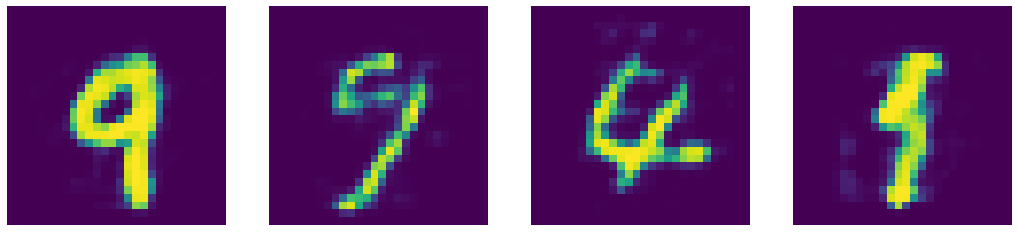

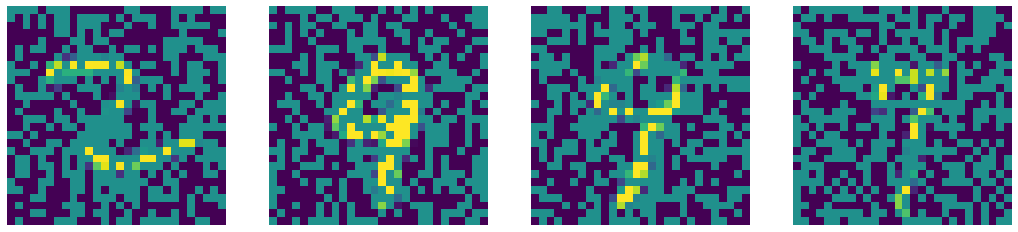

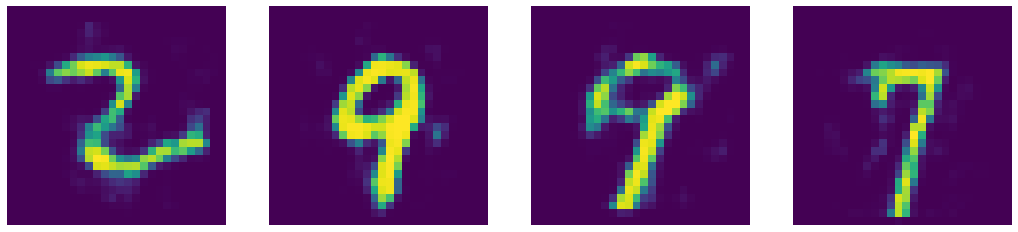

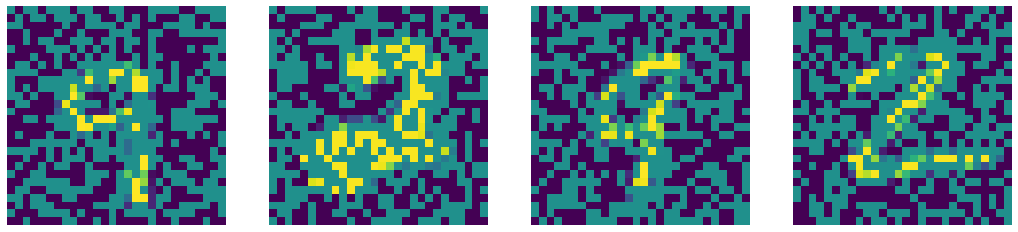

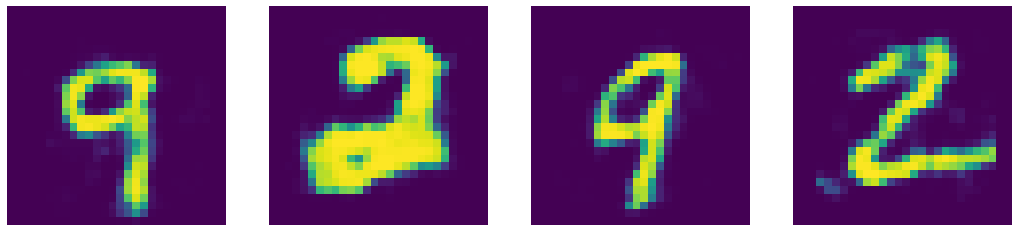

In [ ]:
epoch_loss_dae = training_dae(nb_epoch, model1, criterion, optimizer1)

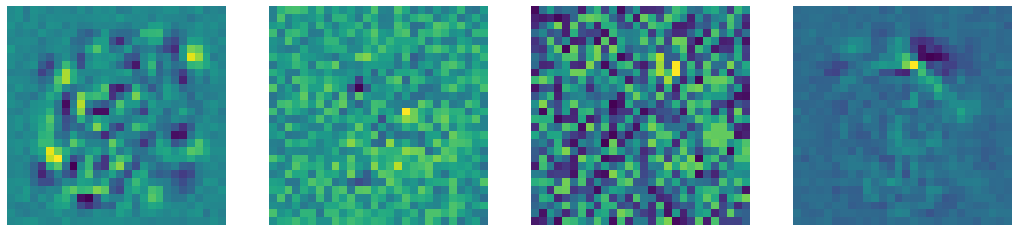

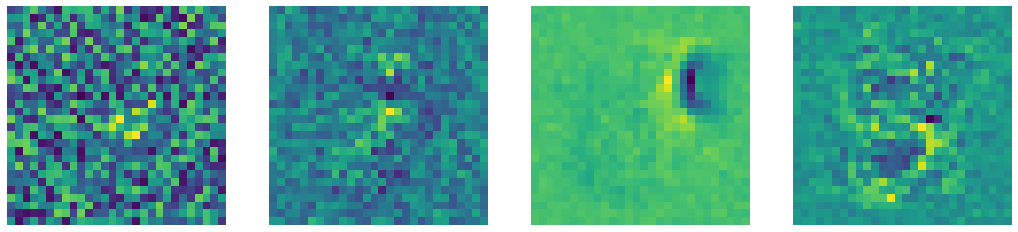

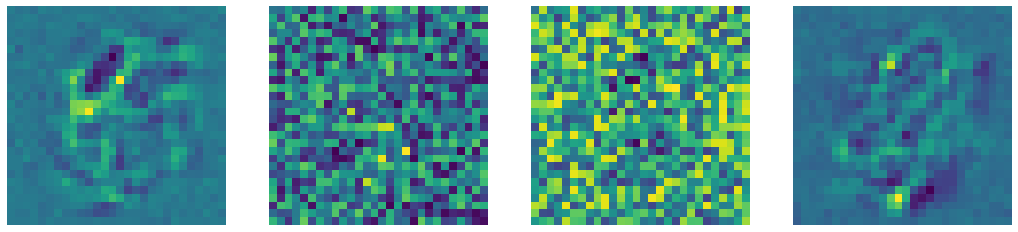

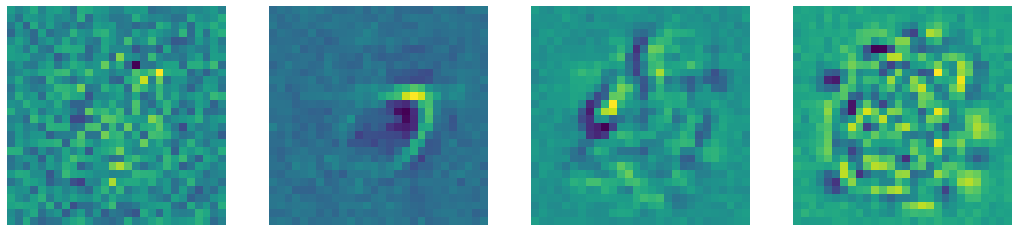

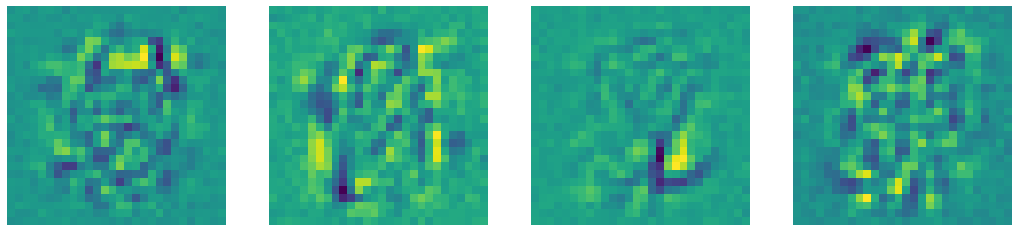

In [ ]:
display_images(None, model1.encoder[0].weight, 5)

## C. Explain the difference between standard AE and denoising AE.  

In [ ]:
def displayLoss(listeLoss, catLoss):
  plt.plot(listeLoss)
  #plt.plot(epoch_loss_dae)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(catLoss, loc='upper left')
  plt.show()

10. Analyse the obtained results.

Pour mieux analyser les résultats obtenus, nous avons choisi de représenter l'évolution de l'erreur en fonction des époques pour les 2 types de modèles auto-encodeurs.

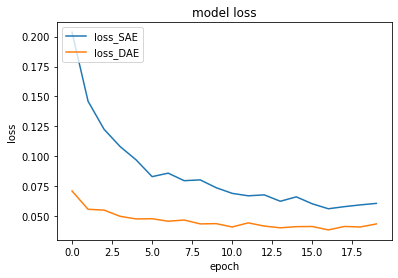

In [ ]:
plt.plot(epoch_loss_sae)
plt.plot(epoch_loss_dae)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_SAE', 'loss_DAE'], loc='upper left')
plt.show()

Le graphe ci dessous représente l'évolution de la perte d'une part pour le modèle auto-encodeur standard (la ligne bleue) et de l'autre pour le modèle auto-encodeur débruiteur (la ligne rouge).
- Pour le SAE, la perte varie entre 0.20 et 0.06. La perte ne cesse de diminuer au fil des époques jusqu'à la dernière. Ce qui en soit  est une bonne nouvelle. Mais étant donné que la courbe de perte décroit jusqu'au bout et ne se stabilise pas à un moment donné, cela indique que notre modèle n'a pas fini son apprentissage. On aura donc besoin d'encore plus d'époques pour mieux entrainer ce modèle jusqu'à ce qu'il commence à se stabiliser.
- Pour DAE, la perte varie entre 0.07 et 0.04. Ce qui est déjà bon. Mais à partir de l'époque 7, on constate que la diminution de la perte reste constante. Ce qui revient à dire qu'on peut arrêter son apprentissage à 7 époques pour éviter le problème de surapprentissage (over-fitting), ce qui le rendre moins performant sur de nouvelles données.

L'avantage du DAE sur SAE peut s'expliquer par la valeur de "d" car plus d est petit, plus l'image sera compressé. Le fait que l'image soit beaucoup compressé fait que l'image reconstruite devienne beaucoup plus différente de l'original.

Un autre élément qui peut influencer les résultats de l'apprentissage c'est le taux d'apprentissage. En effet, ici le taux est de 0.001. Cette valeur étant certes acceptable on va tenter de lui donne une valeur légèrement plus grande ou plus petite.

11. Changes the parameters of the Autoencoder and analyse theirs impact. Conclude.

- Choix d'un taux d'apprentissage plus grand (soit 0.01)

epoch [1/20], loss:0.2703
epoch [2/20], loss:0.2626
epoch [3/20], loss:0.2733
epoch [4/20], loss:0.2660
epoch [5/20], loss:0.2849
epoch [6/20], loss:0.2570
epoch [7/20], loss:0.2635
epoch [8/20], loss:0.2816
epoch [9/20], loss:0.2743
epoch [10/20], loss:0.2601
epoch [11/20], loss:0.2772
epoch [12/20], loss:0.2745
epoch [13/20], loss:0.2675
epoch [14/20], loss:0.2866
epoch [15/20], loss:0.2543
epoch [16/20], loss:0.2617
epoch [17/20], loss:0.2602
epoch [18/20], loss:0.2597
epoch [19/20], loss:0.2829
epoch [20/20], loss:0.2605


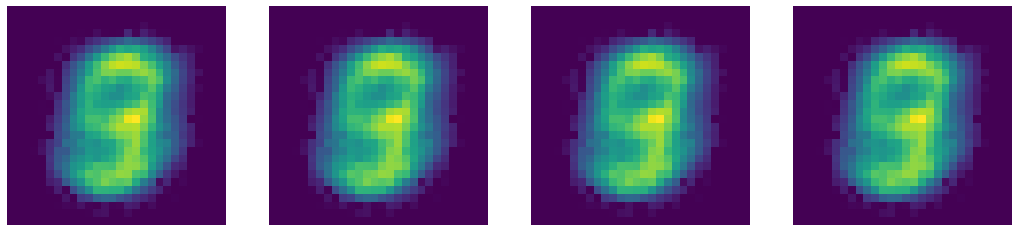

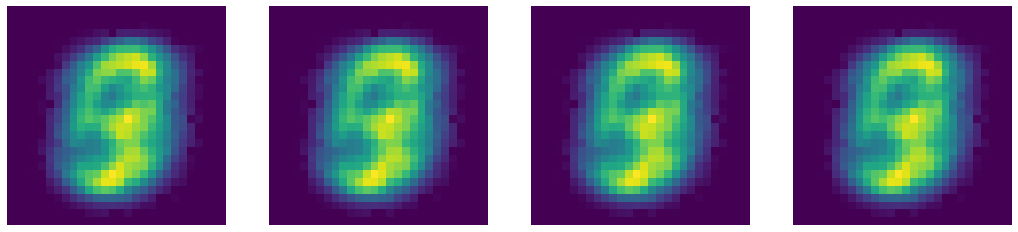

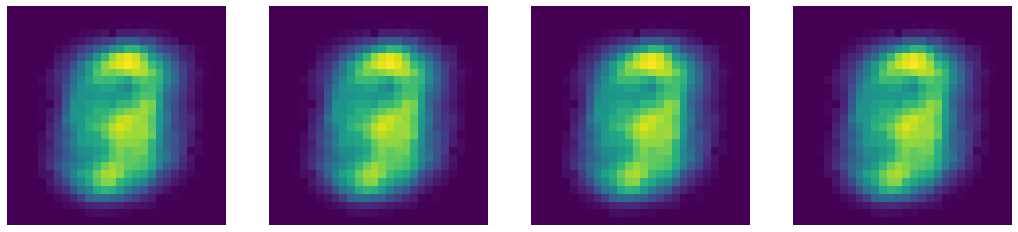

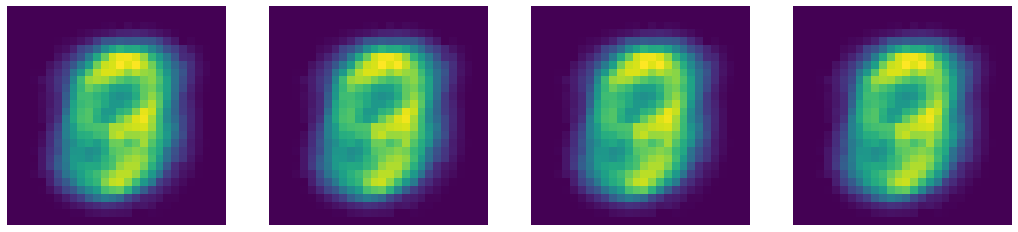

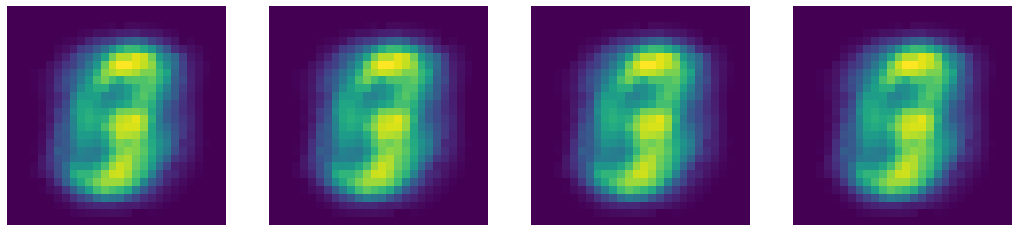

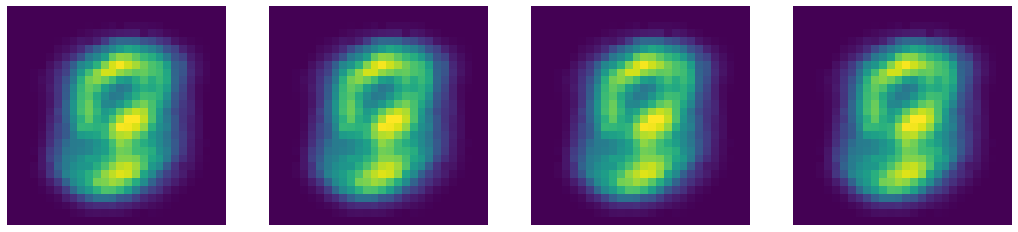

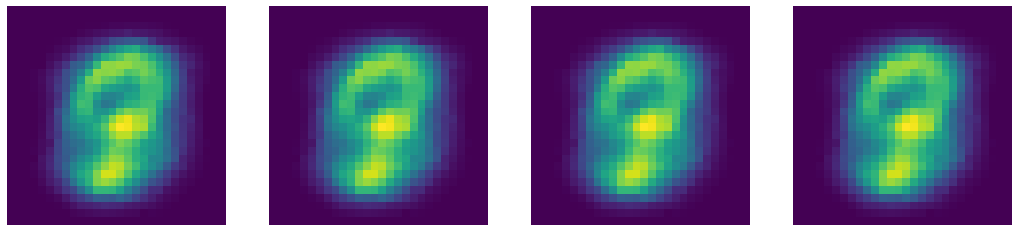

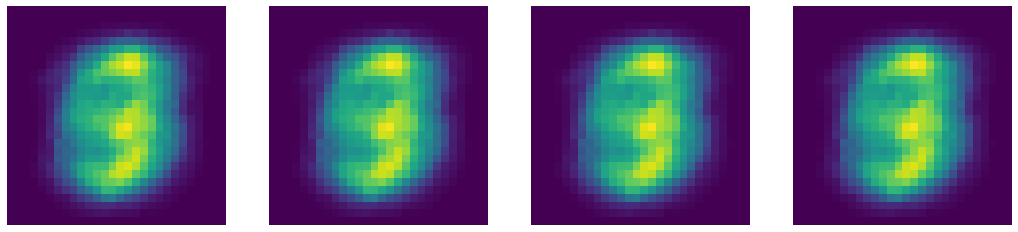

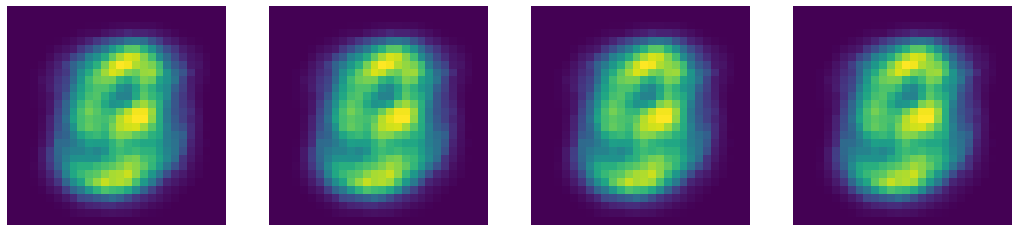

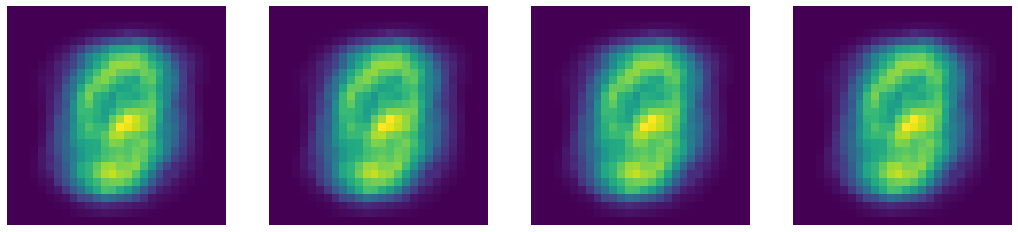

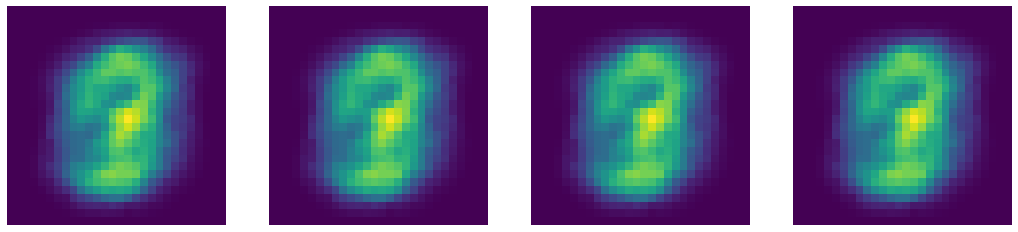

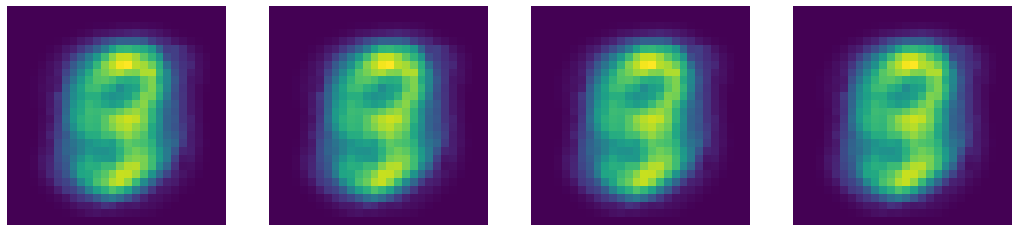

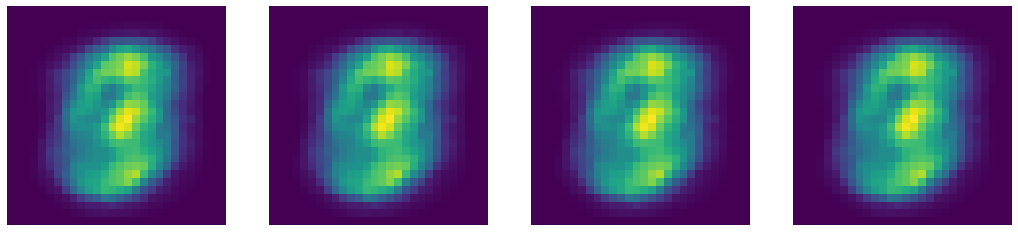

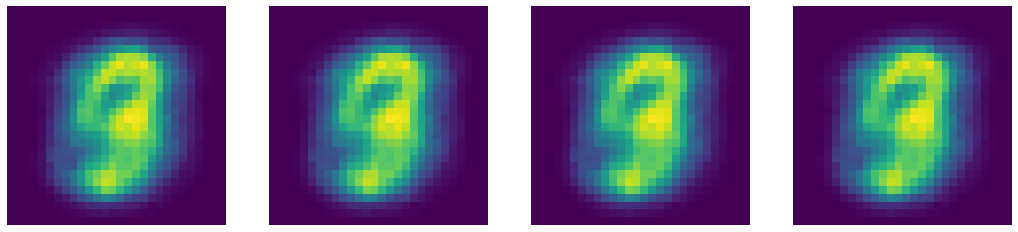

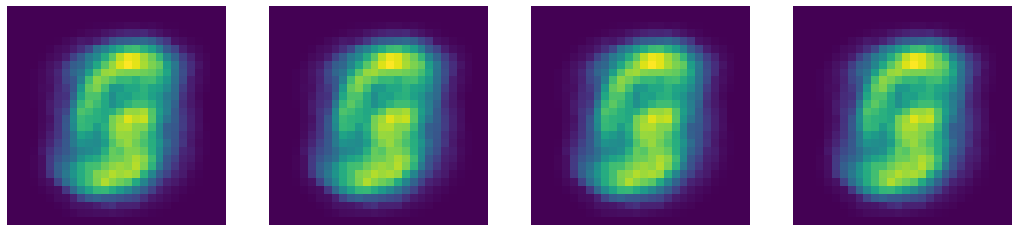

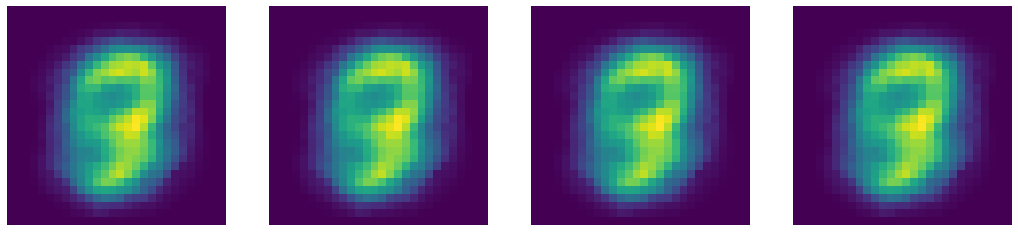

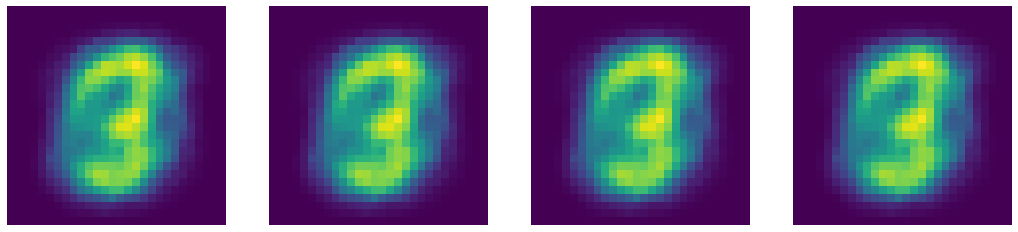

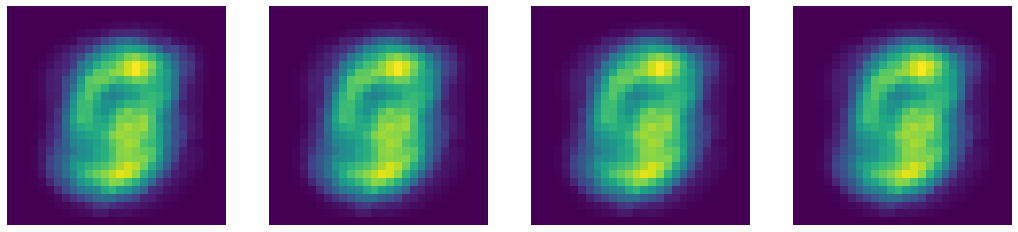

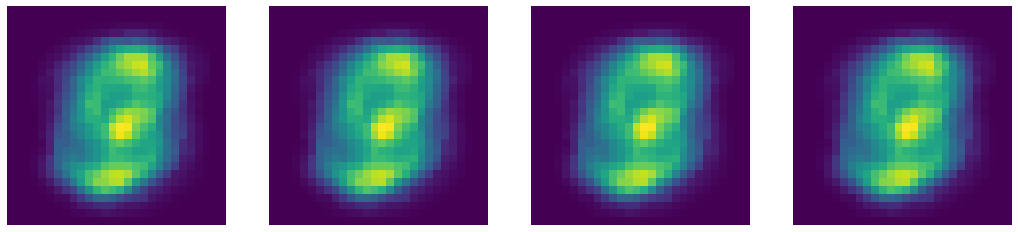

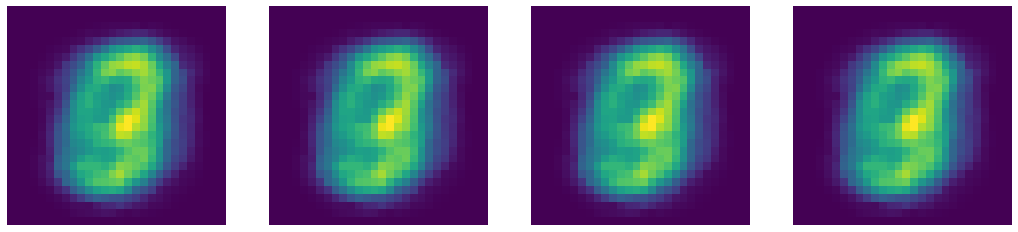

In [ ]:
d=30;
model2 = Autoencoder(d).to(device)
criterion = nn.MSELoss() # on définit un critère qui va nous servir pour la fonction de coût

learning_rate = 1e-2 # soit 0.001, ce qui est pas mal

#  l'optimizer permet d'appliquer l'algo du gradient pour minimiser le coût
optimizer2 = torch.optim.Adam(
    model2.parameters(), # permet de récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate, # permet de déterminer la vitesse à laquelle on ajuste les poids
)

nb_epoch = 20
epoch_loss_sae = training_sae(nb_epoch, model2, criterion, optimizer2)

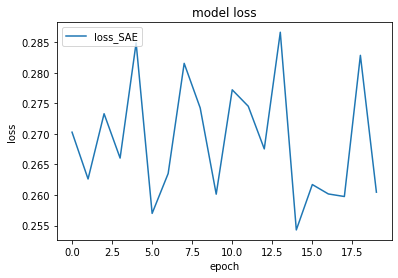

In [ ]:
displayLoss(epoch_loss_sae, ['loss_SAE'])

Avec un taux d'apprentissage élevé, l'apprentissage prend effectivement moins de temps, l'image de sortie se déteriore au fur et à mesure qu'on entraine le modèle. La perte est très  instable et varie au cours des époques

- Choix d'un taux d'apprentissage plus petit

epoch [1/20], loss:0.4323
epoch [2/20], loss:0.3079
epoch [3/20], loss:0.2835
epoch [4/20], loss:0.2747
epoch [5/20], loss:0.2573
epoch [6/20], loss:0.2202
epoch [7/20], loss:0.2302
epoch [8/20], loss:0.2239
epoch [9/20], loss:0.2091
epoch [10/20], loss:0.1961
epoch [11/20], loss:0.1933
epoch [12/20], loss:0.1911
epoch [13/20], loss:0.1736
epoch [14/20], loss:0.1591
epoch [15/20], loss:0.1679
epoch [16/20], loss:0.1584
epoch [17/20], loss:0.1541
epoch [18/20], loss:0.1448
epoch [19/20], loss:0.1378
epoch [20/20], loss:0.1354


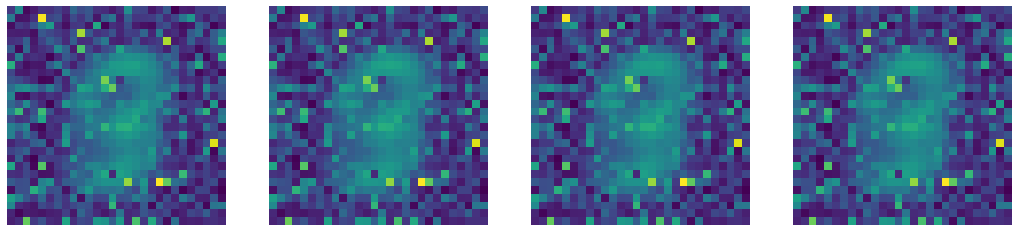

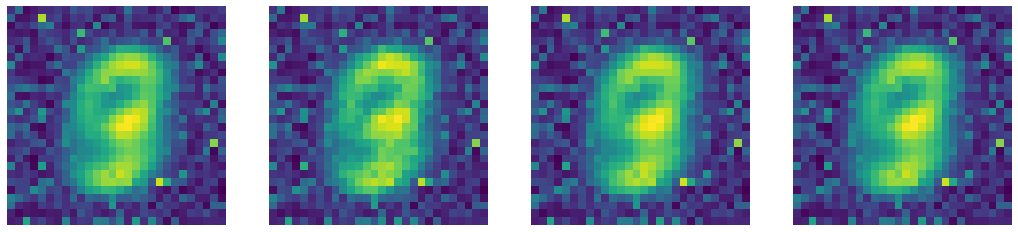

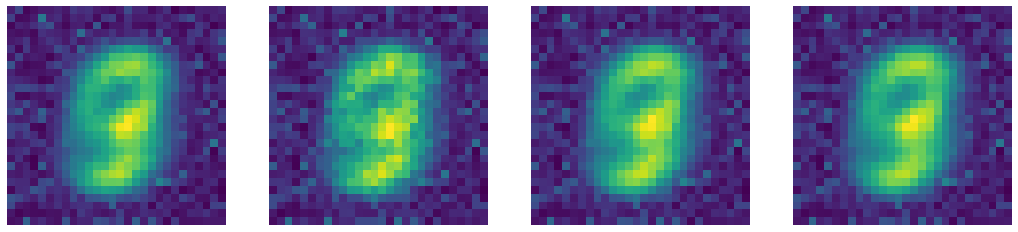

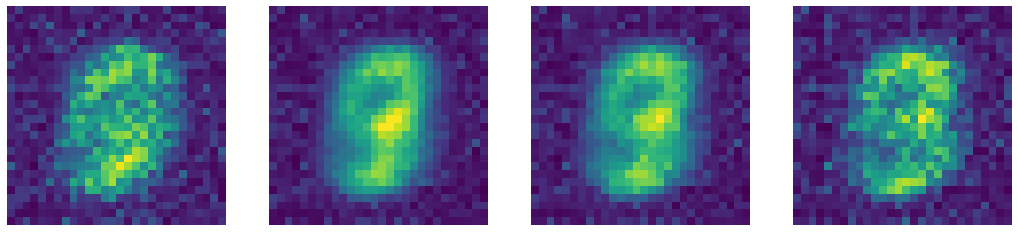

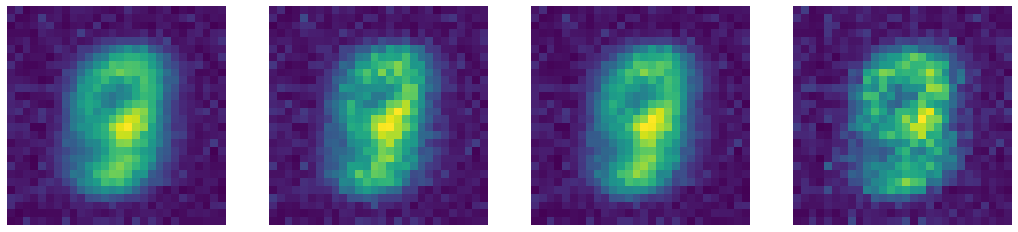

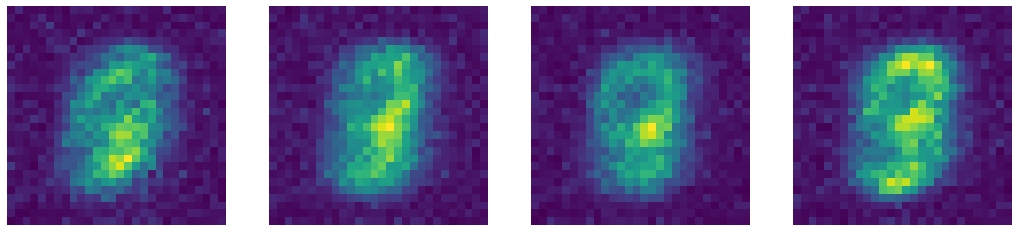

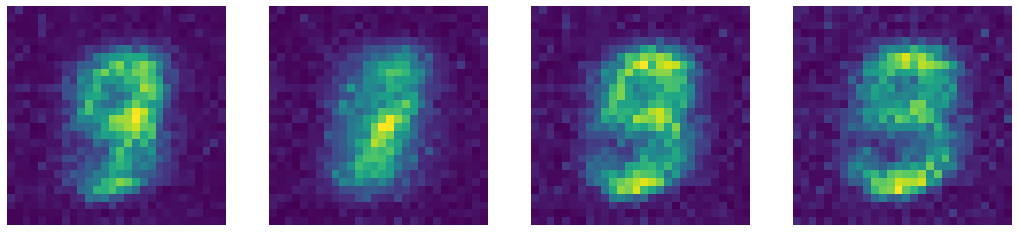

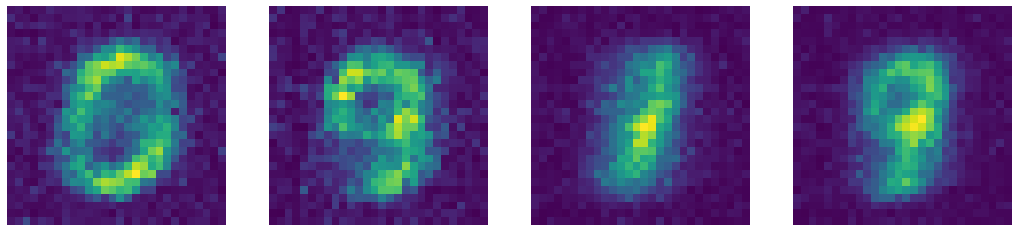

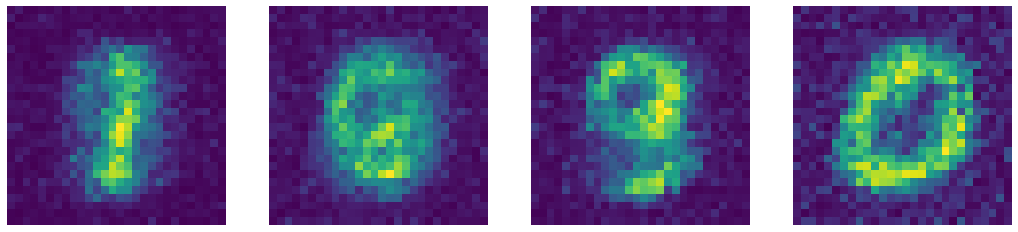

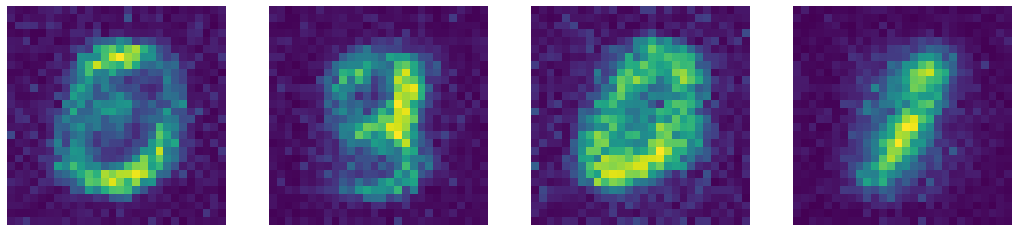

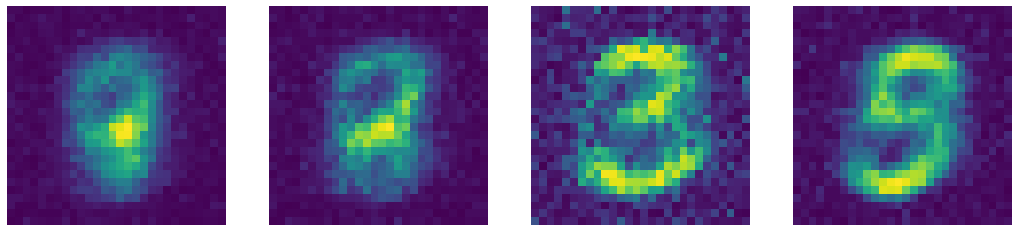

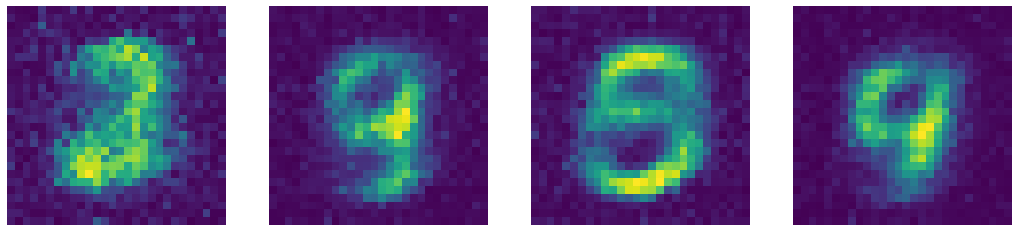

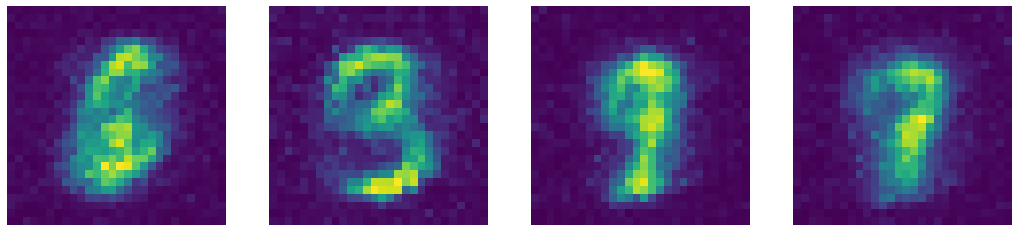

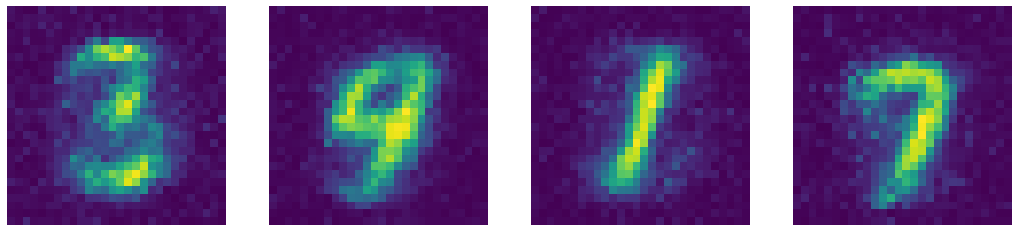

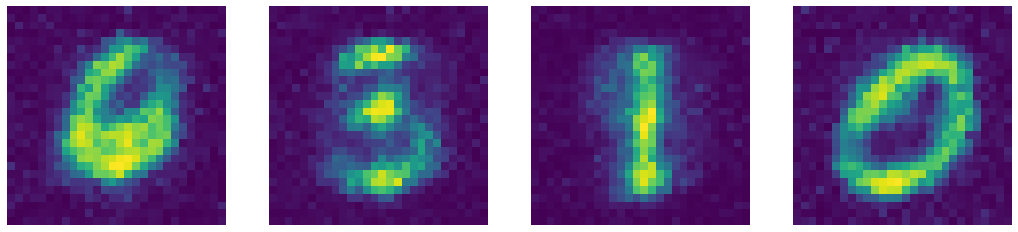

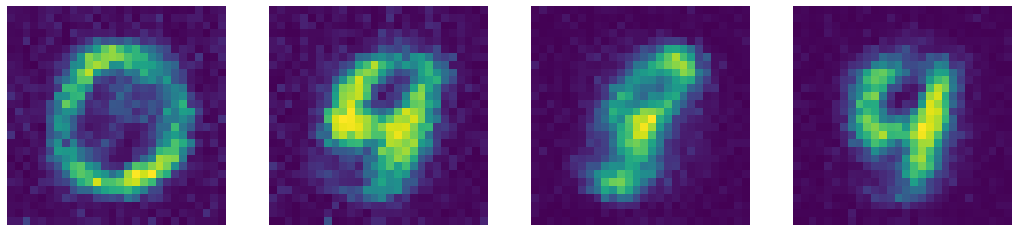

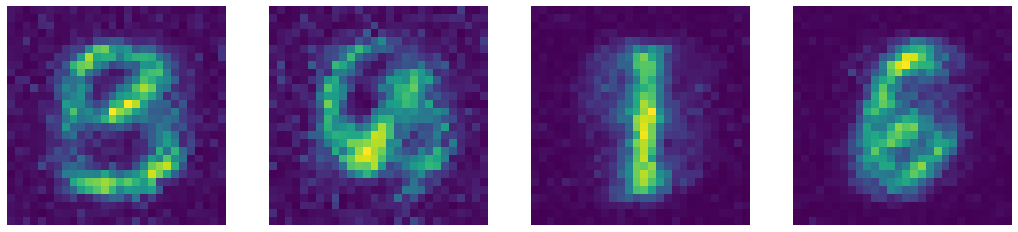

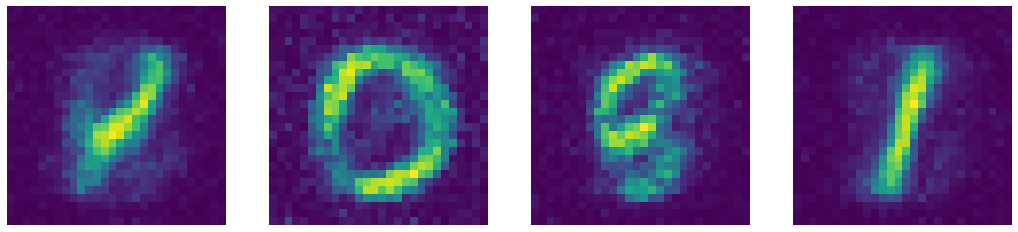

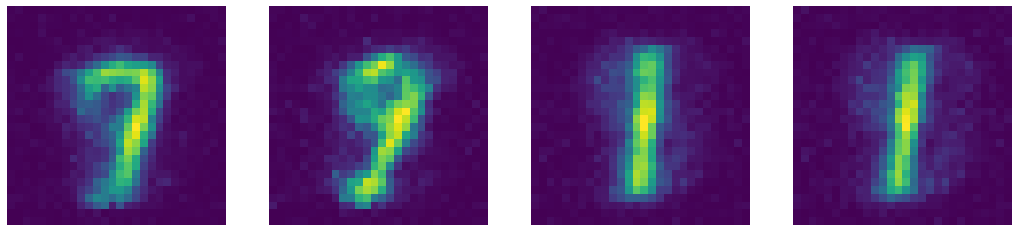

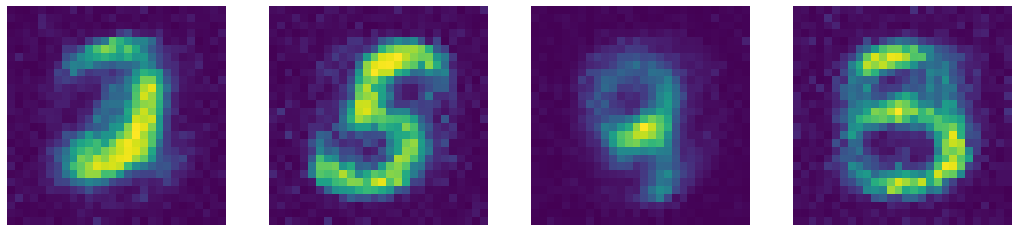

In [ ]:
d=30;
model3 = Autoencoder(d).to(device)
criterion = nn.MSELoss() # on définit un critère qui va nous servir pour la fonction de coût

learning_rate = 1e-4 # soit 0.001, ce qui est pas mal

#  l'optimizer permet d'appliquer l'algo du gradient pour minimiser le coût
optimizer3 = torch.optim.Adam(
    model3.parameters(), # permet de récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate, # permet de déterminer la vitesse à laquelle on ajuste les poids
)

nb_epoch = 20
epoch_loss_sae = training_sae(nb_epoch, model3, criterion, optimizer3)

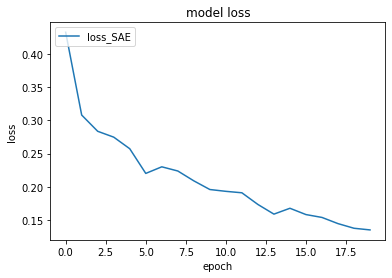

In [ ]:
displayLoss(epoch_loss_sae, ['loss_SAE'])

Avec un taux d'apprentissage trop petit, on constate que la perte diminue au fil des époques mais l'apprentissage prend beaucoup plus de temps. D'où la nécessité d'ajouter plus d'époques d'apprentissage pour que la perte se stabilise. Enfin l'image reconstruite est moins bon que quand on prend un taux de 0.001

- Augmentation du nombre d'époque (soit 100)

epoch [1/100], loss:0.1911
epoch [2/100], loss:0.1503
epoch [3/100], loss:0.1186
epoch [4/100], loss:0.0979
epoch [5/100], loss:0.0950
epoch [6/100], loss:0.0864
epoch [7/100], loss:0.0828
epoch [8/100], loss:0.0773
epoch [9/100], loss:0.0688
epoch [10/100], loss:0.0744
epoch [11/100], loss:0.0703
epoch [12/100], loss:0.0640
epoch [13/100], loss:0.0651
epoch [14/100], loss:0.0692
epoch [15/100], loss:0.0610
epoch [16/100], loss:0.0582
epoch [17/100], loss:0.0566
epoch [18/100], loss:0.0601
epoch [19/100], loss:0.0552
epoch [20/100], loss:0.0559
epoch [21/100], loss:0.0555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


epoch [22/100], loss:0.0546
epoch [23/100], loss:0.0539
epoch [24/100], loss:0.0559
epoch [25/100], loss:0.0525
epoch [26/100], loss:0.0498
epoch [27/100], loss:0.0527
epoch [28/100], loss:0.0528
epoch [29/100], loss:0.0498
epoch [30/100], loss:0.0518
epoch [31/100], loss:0.0490
epoch [32/100], loss:0.0489
epoch [33/100], loss:0.0523
epoch [34/100], loss:0.0463
epoch [35/100], loss:0.0491
epoch [36/100], loss:0.0517
epoch [37/100], loss:0.0497
epoch [38/100], loss:0.0525
epoch [39/100], loss:0.0479
epoch [40/100], loss:0.0489
epoch [41/100], loss:0.0518
epoch [42/100], loss:0.0508
epoch [43/100], loss:0.0434
epoch [44/100], loss:0.0513
epoch [45/100], loss:0.0527
epoch [46/100], loss:0.0493
epoch [47/100], loss:0.0471
epoch [48/100], loss:0.0515
epoch [49/100], loss:0.0526
epoch [50/100], loss:0.0483
epoch [51/100], loss:0.0492
epoch [52/100], loss:0.0496
epoch [53/100], loss:0.0482
epoch [54/100], loss:0.0441
epoch [55/100], loss:0.0465
epoch [56/100], loss:0.0467
epoch [57/100], loss

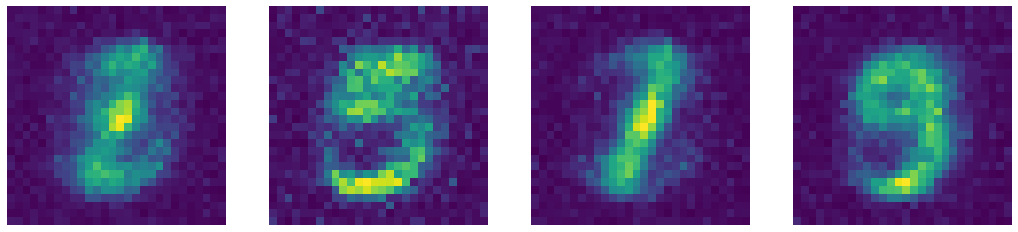

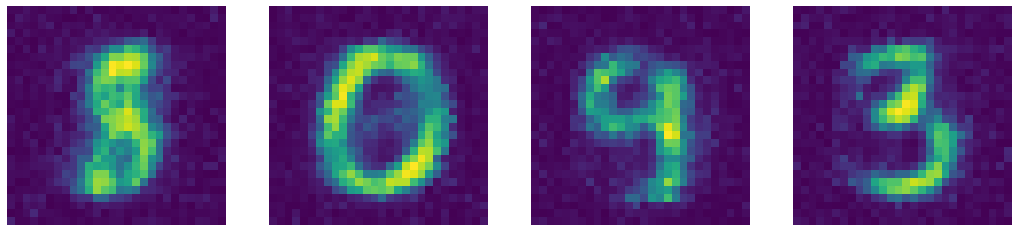

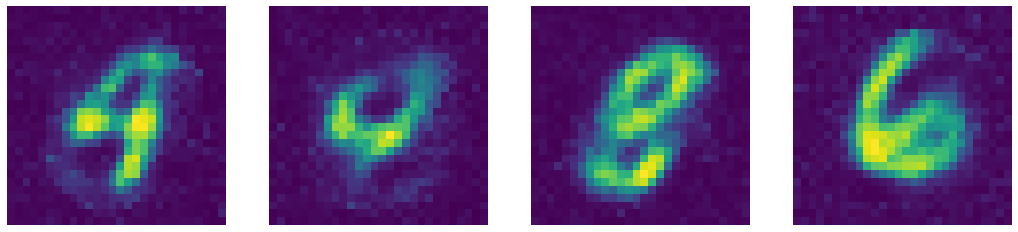

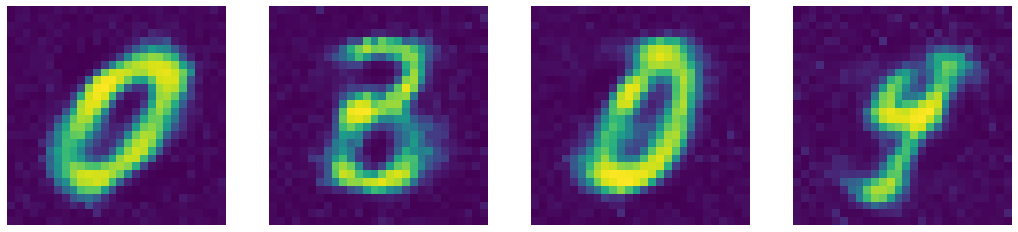

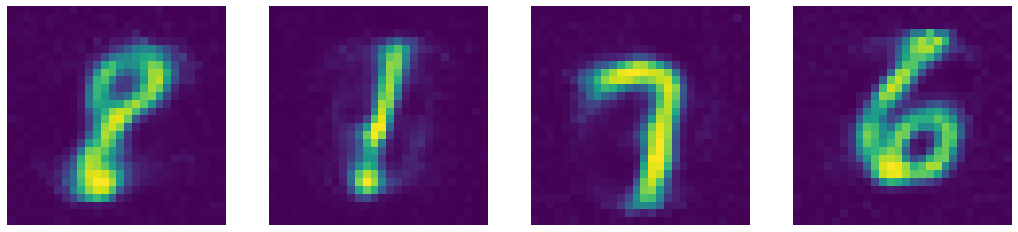

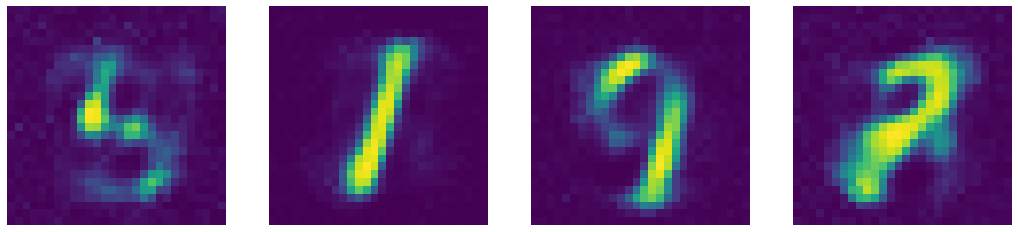

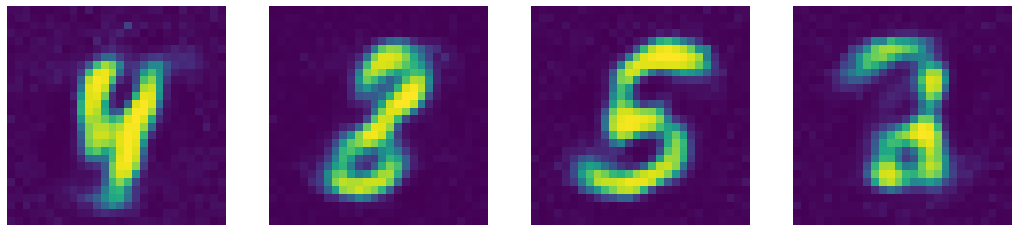

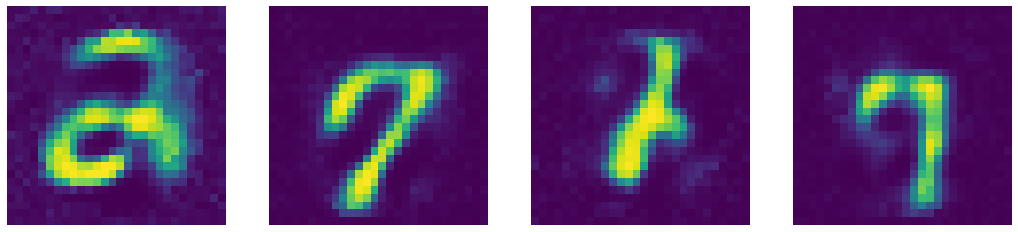

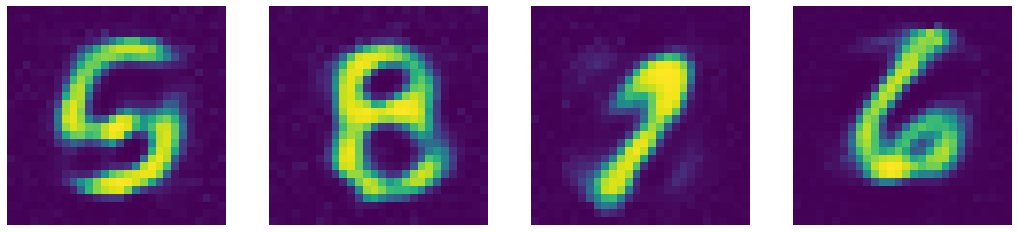

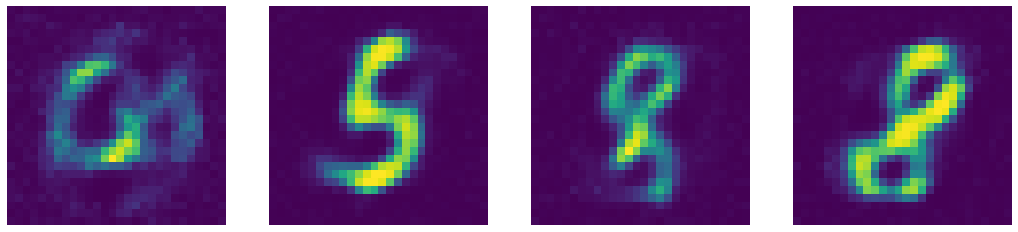

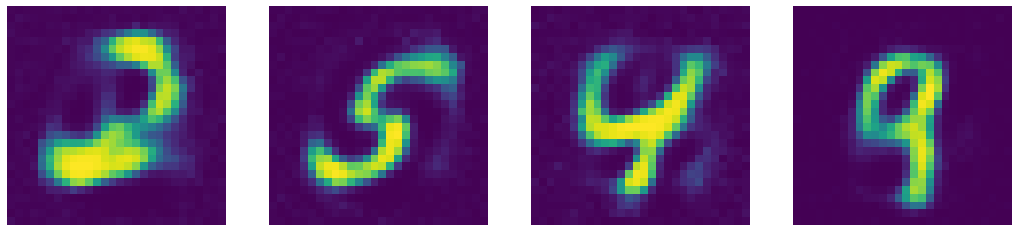

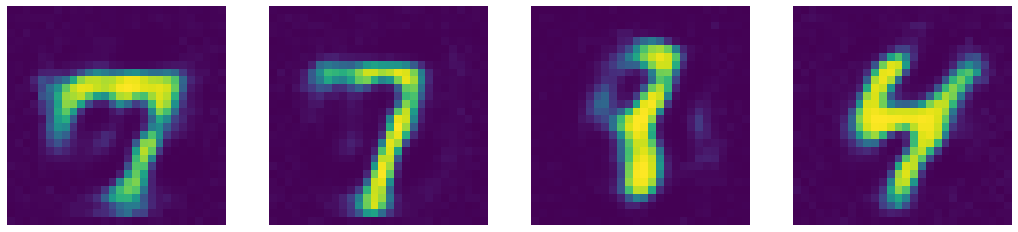

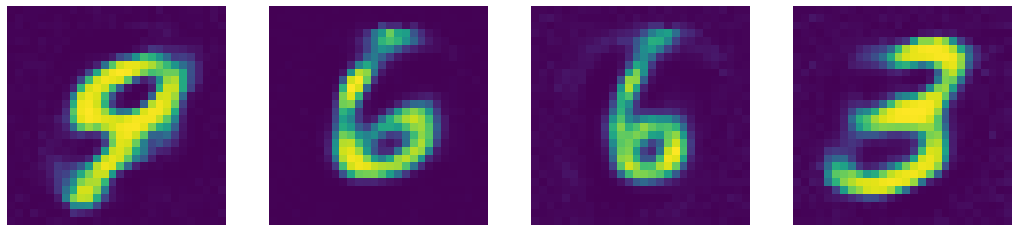

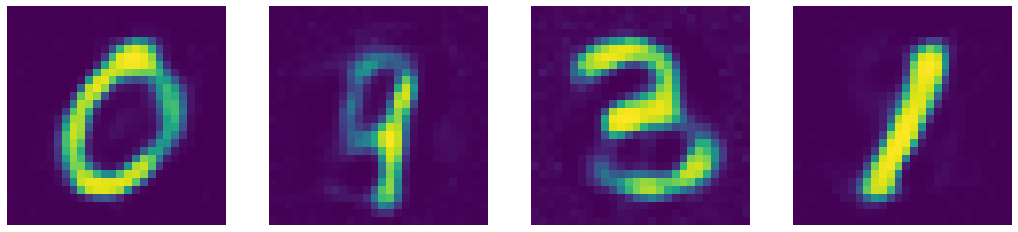

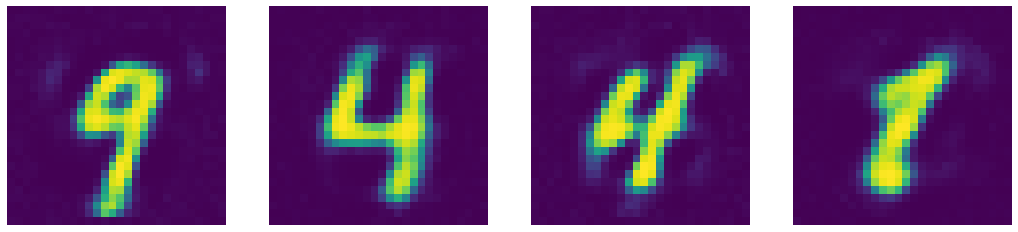

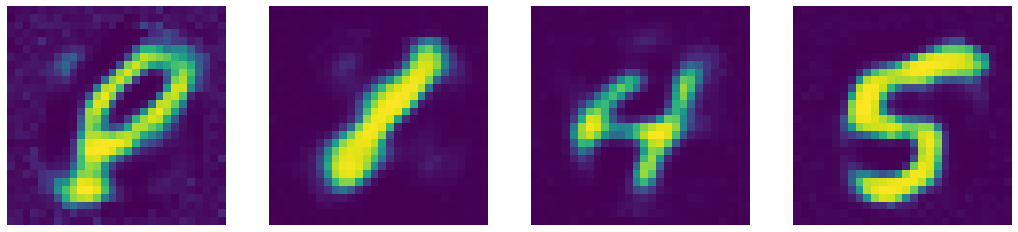

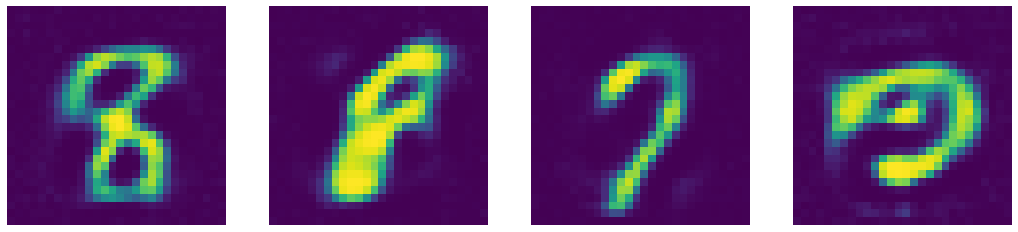

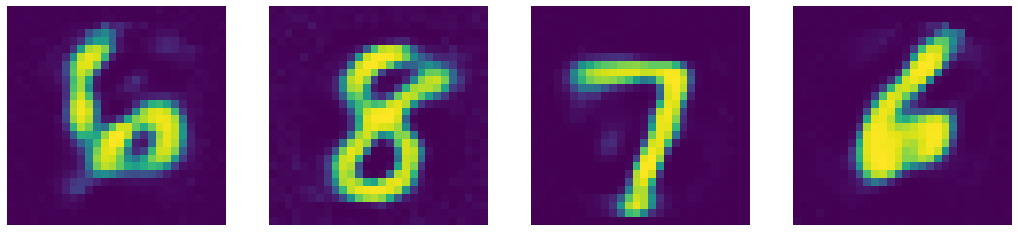

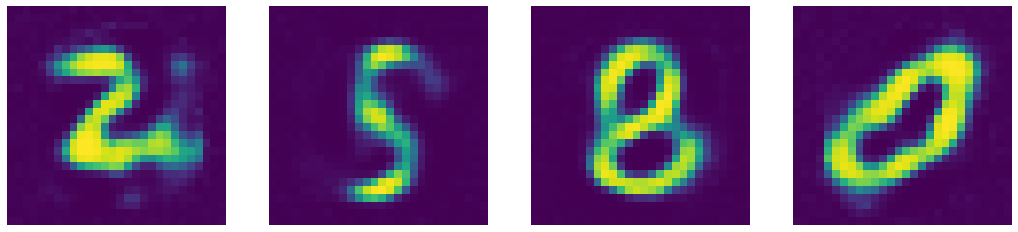

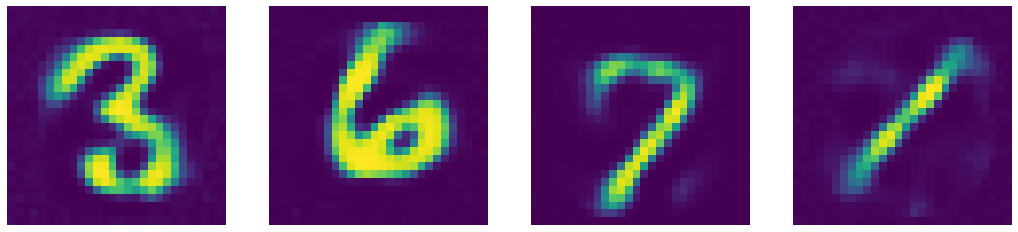

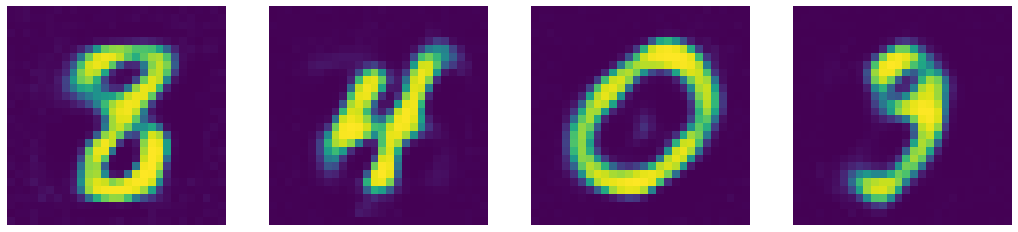

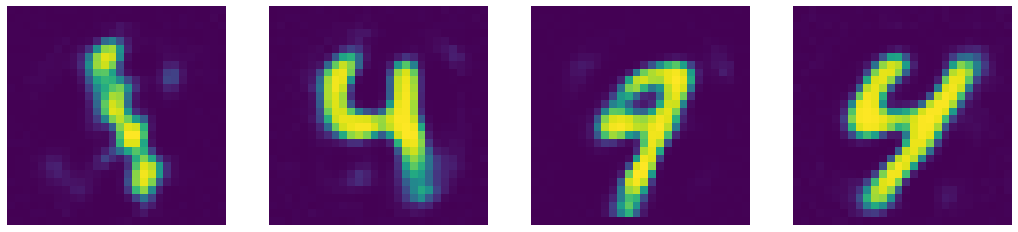

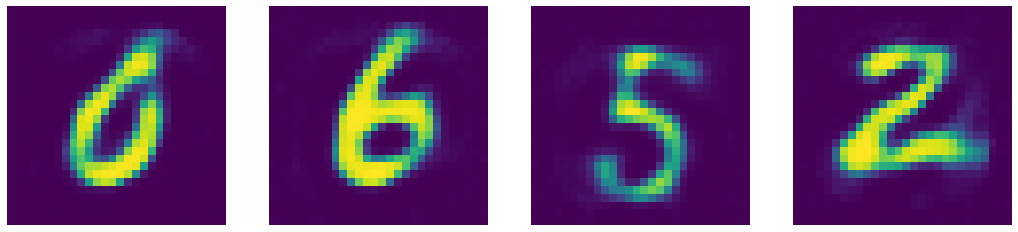

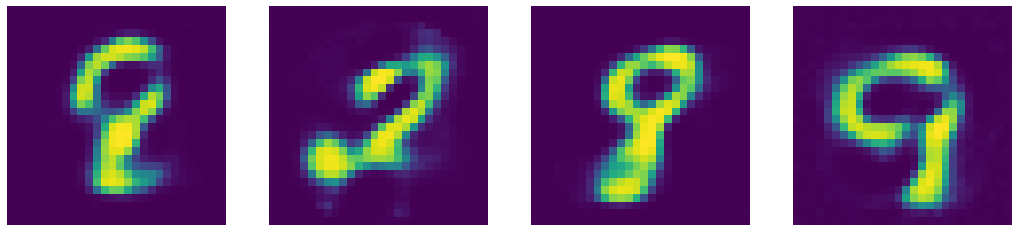

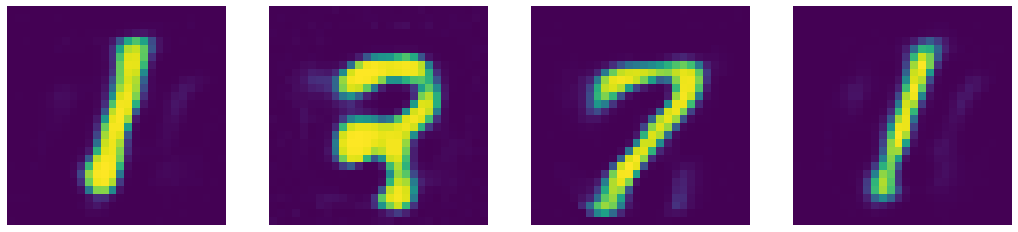

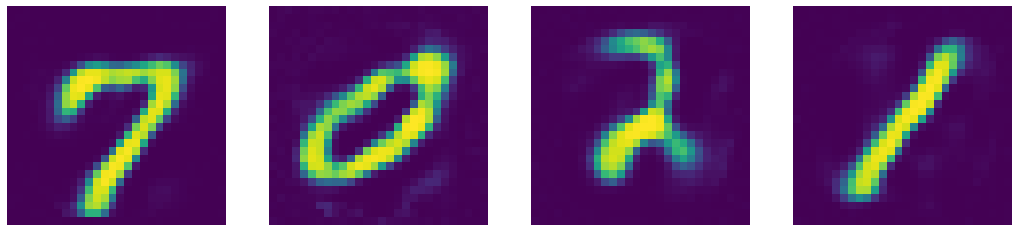

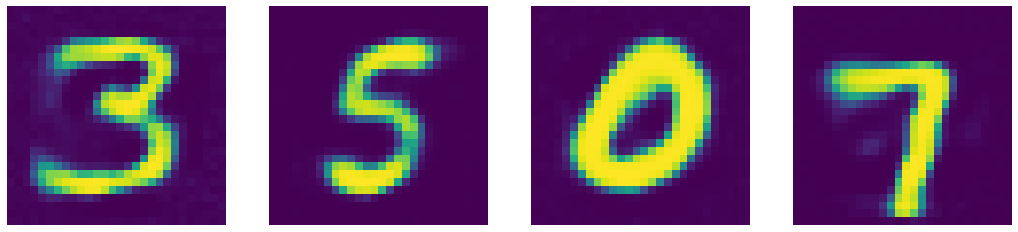

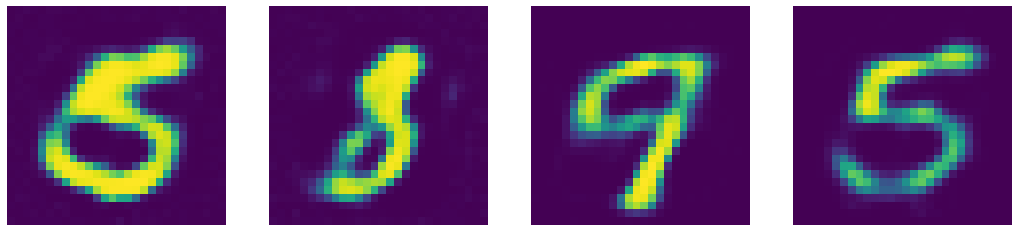

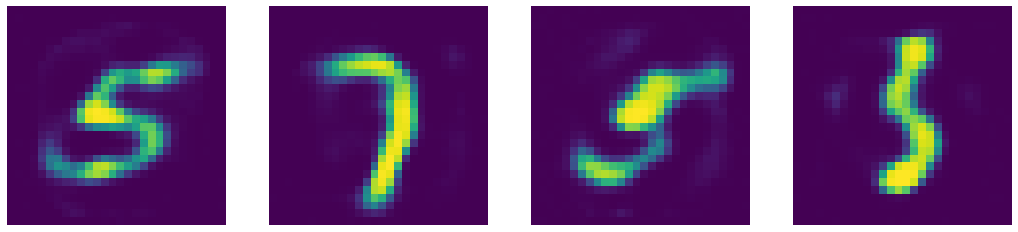

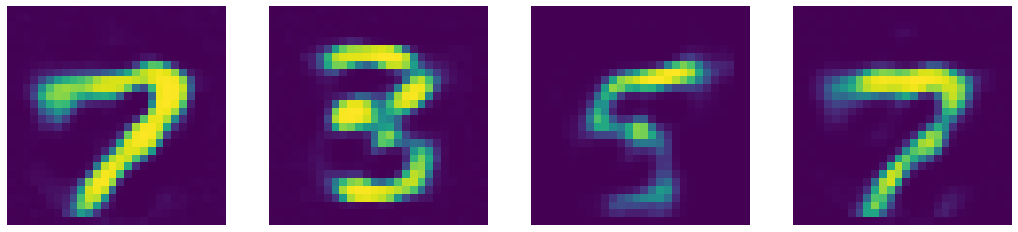

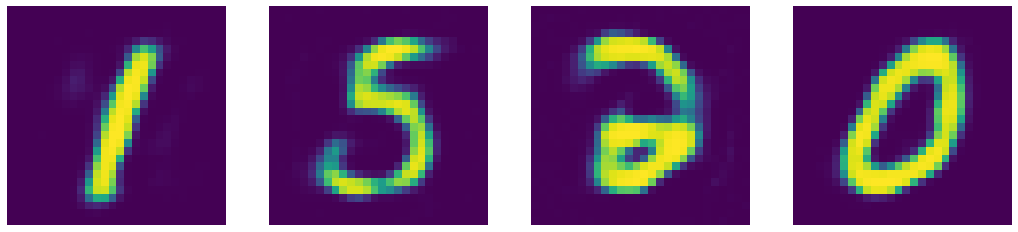

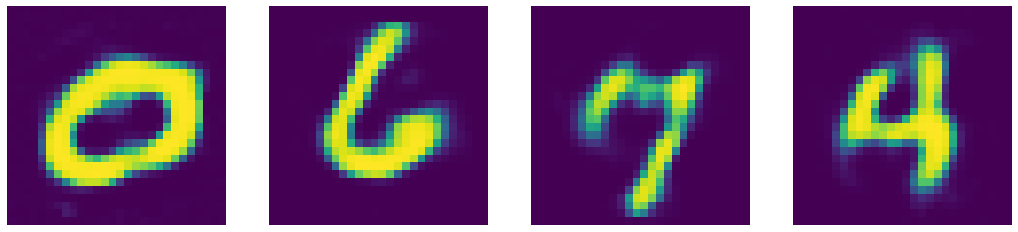

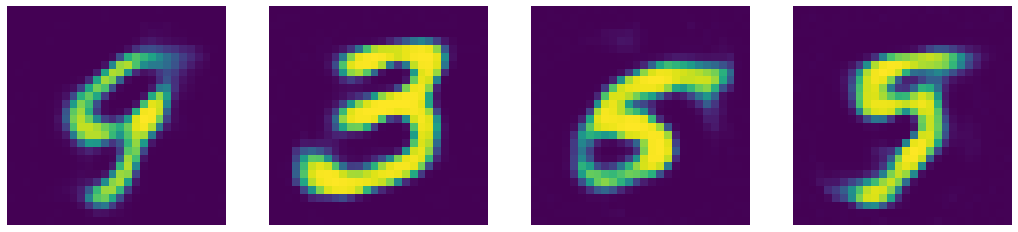

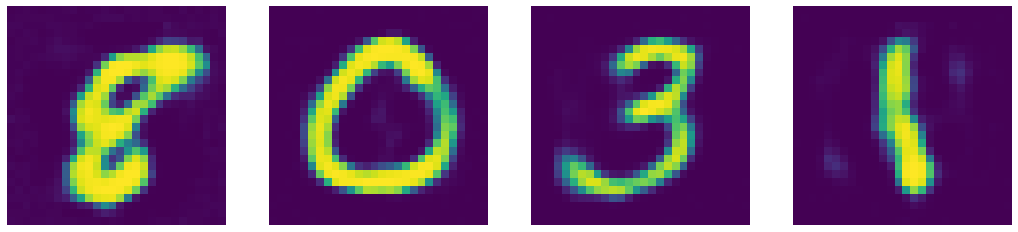

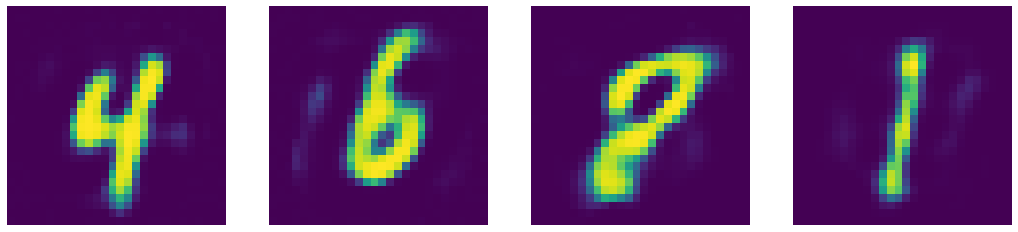

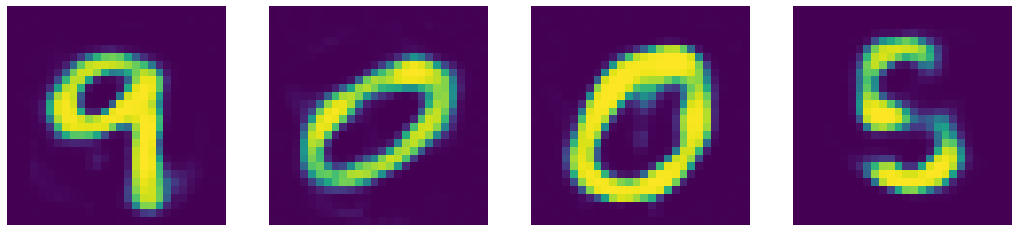

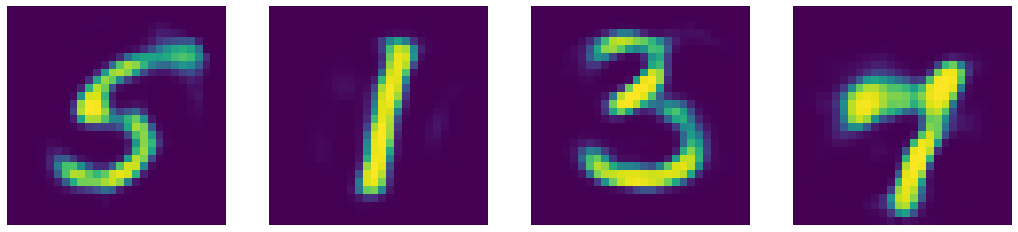

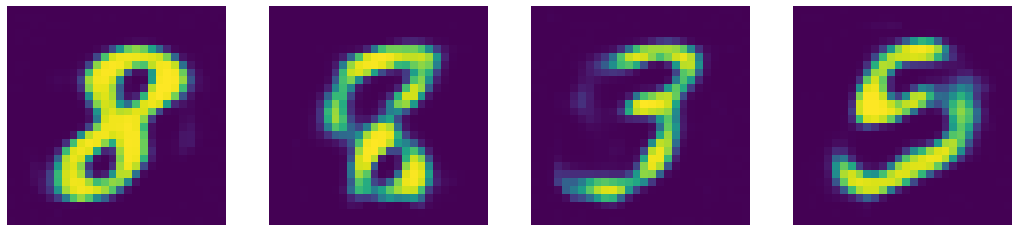

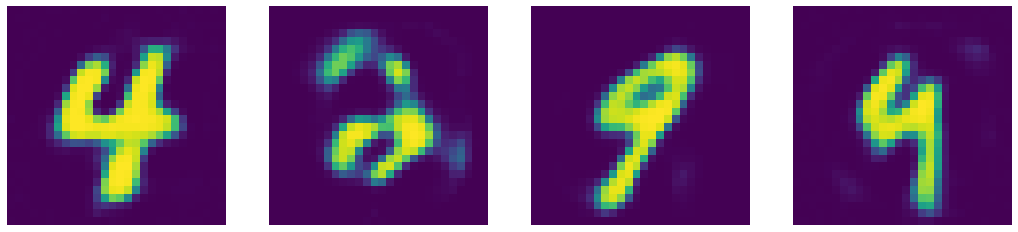

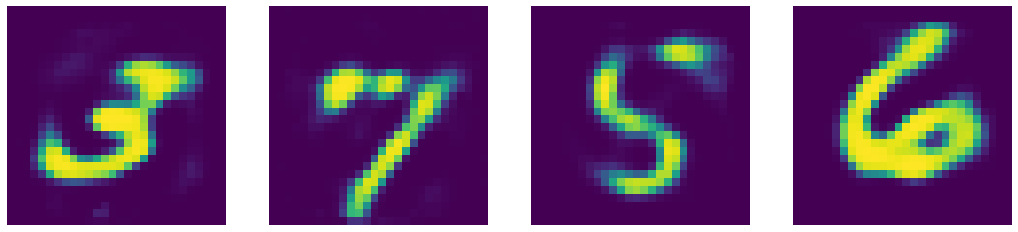

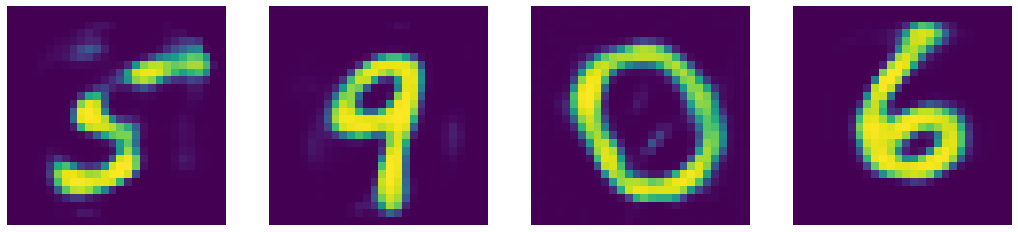

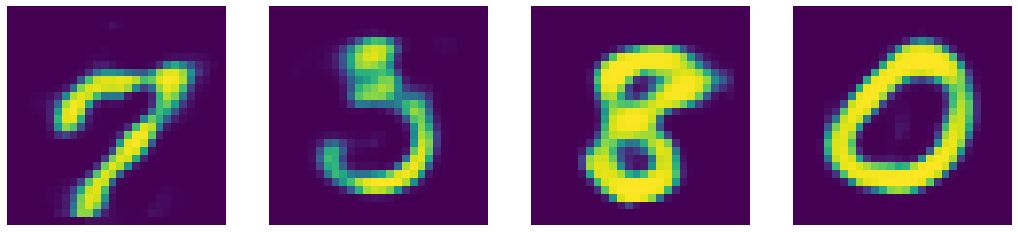

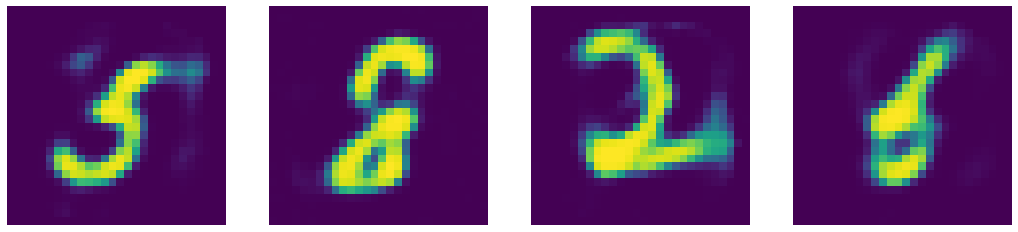

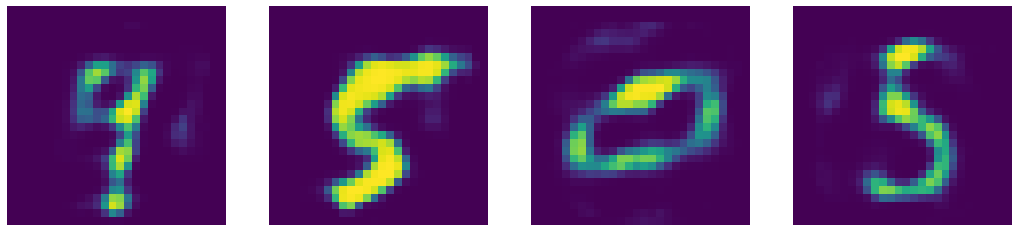

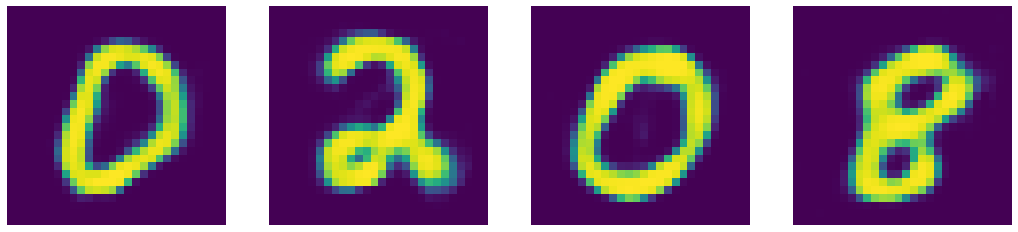

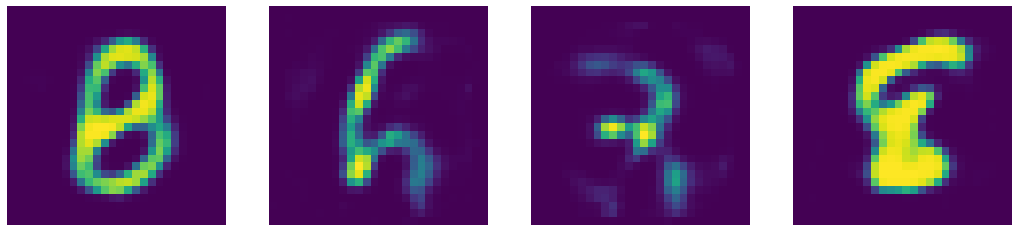

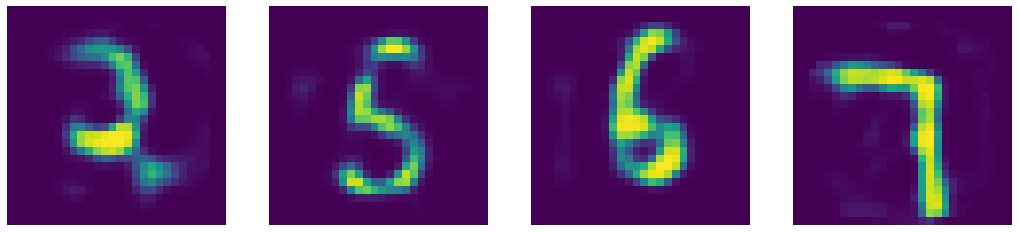

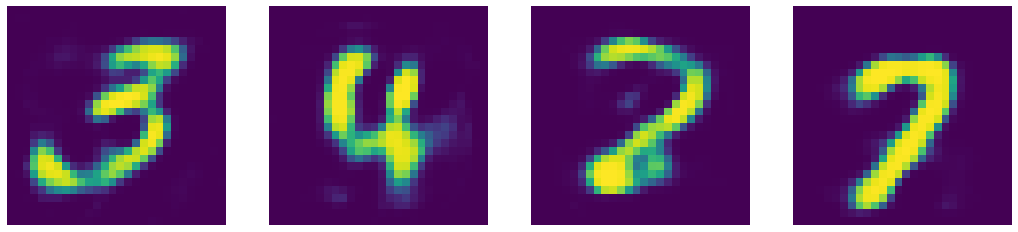

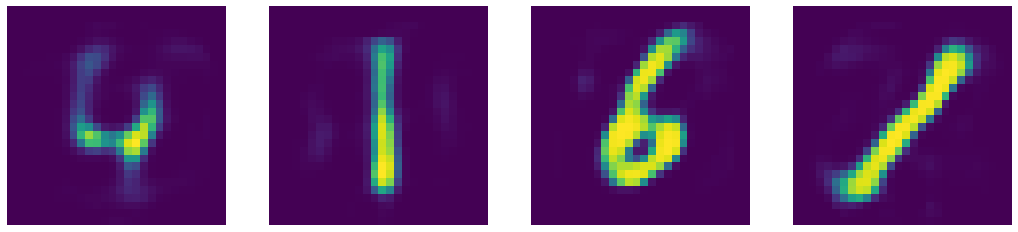

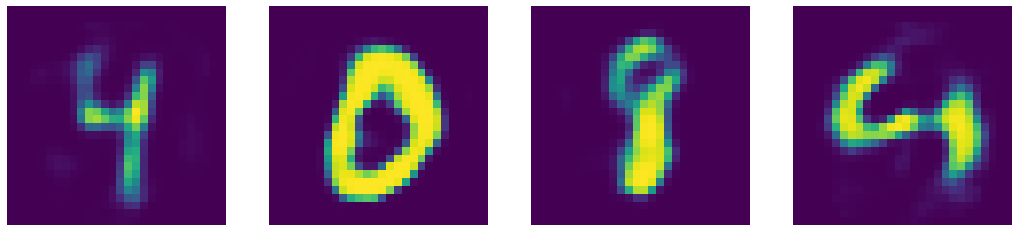

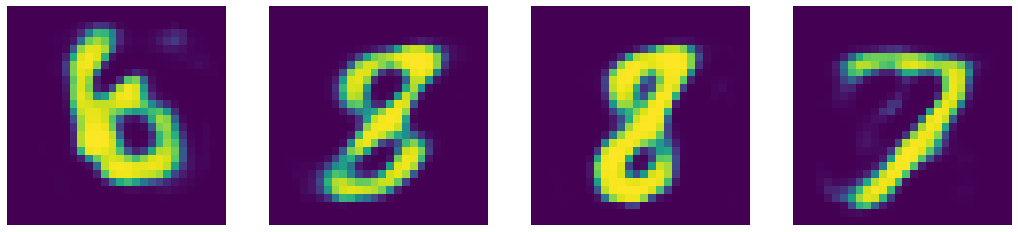

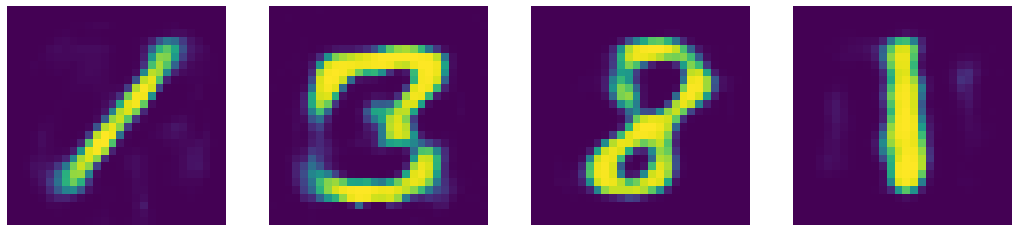

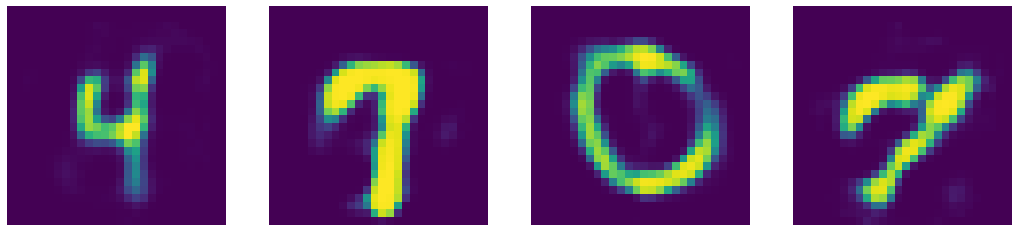

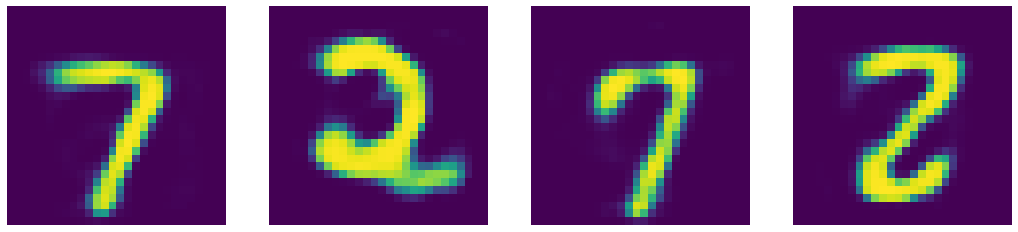

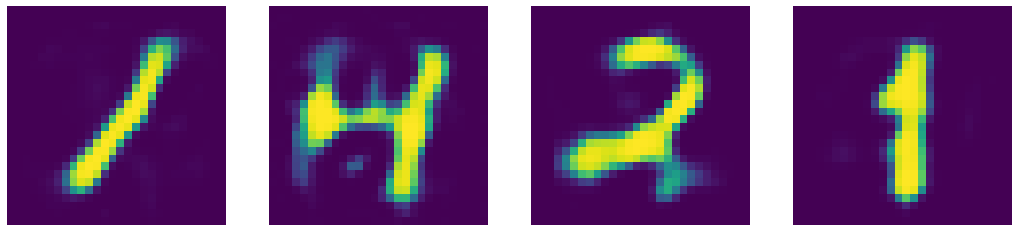

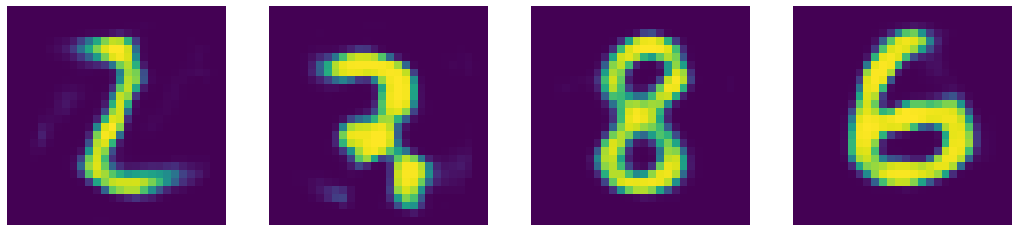

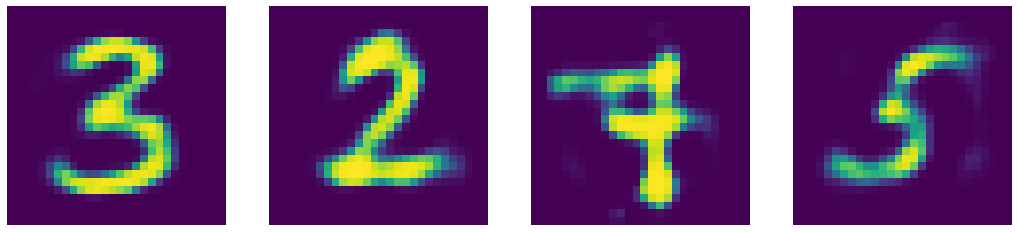

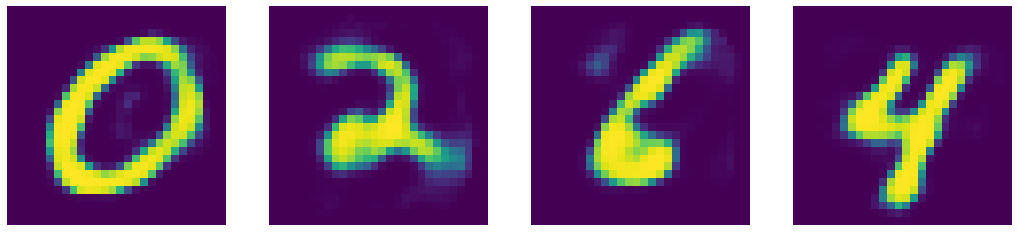

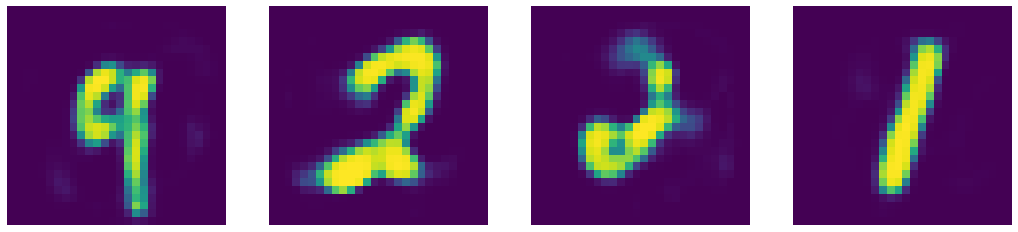

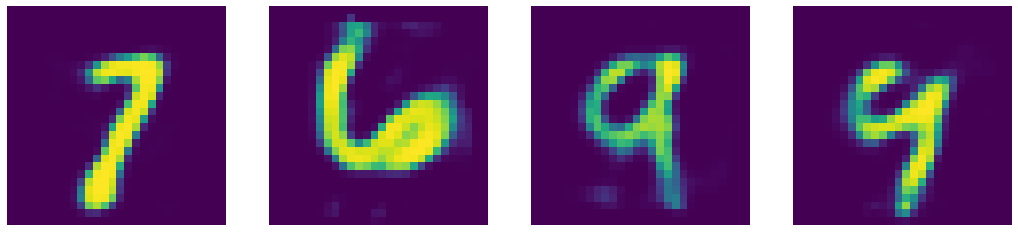

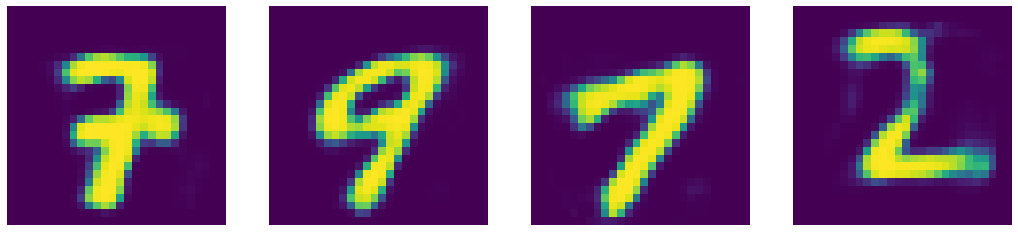

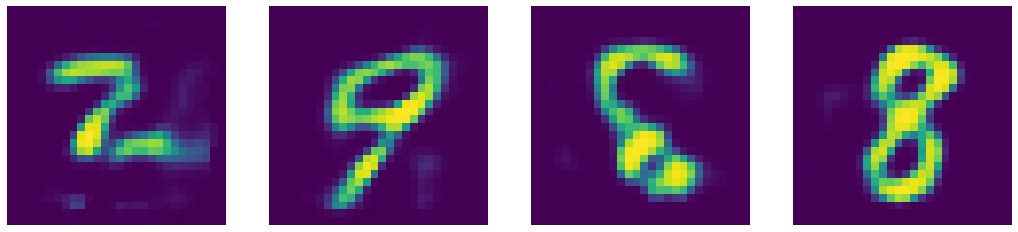

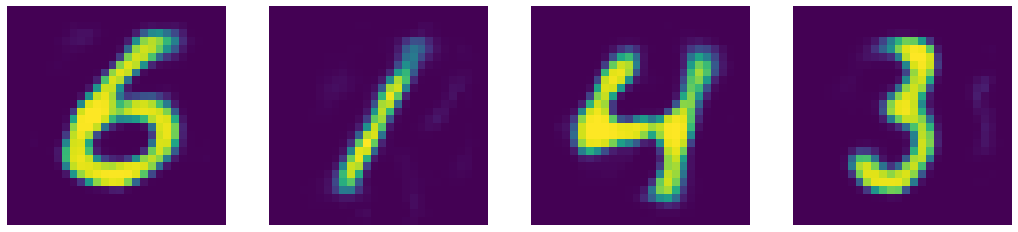

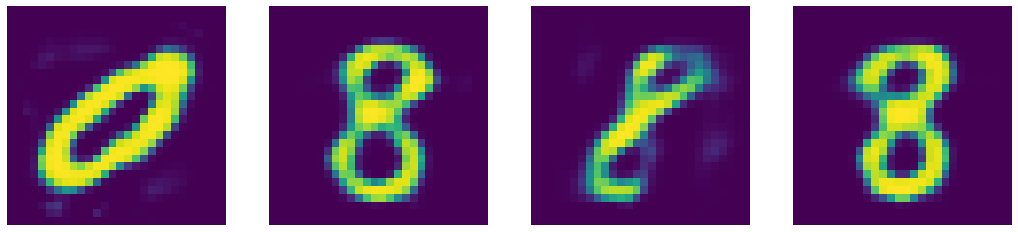

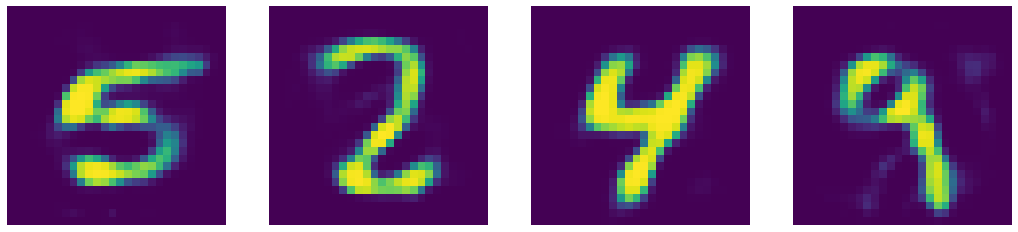

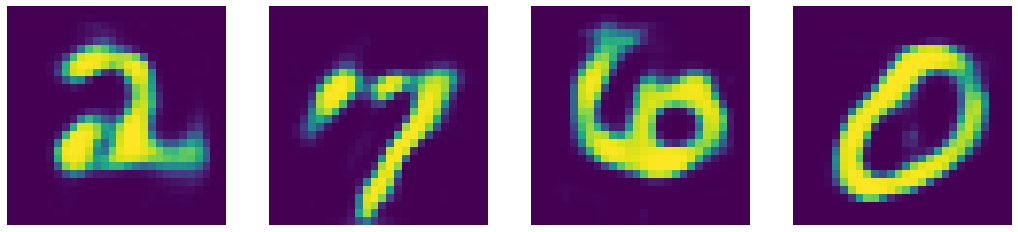

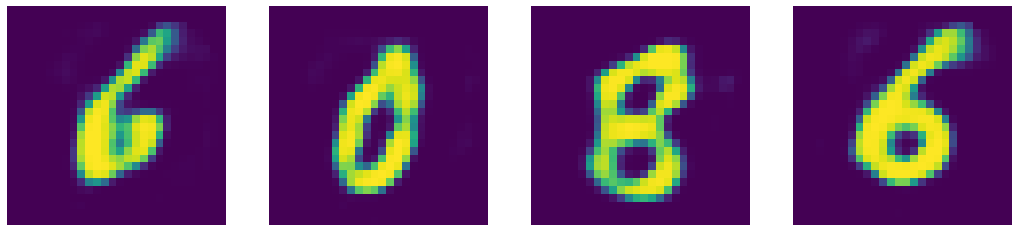

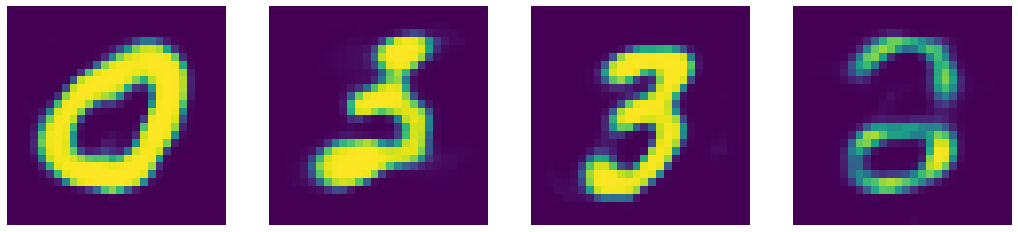

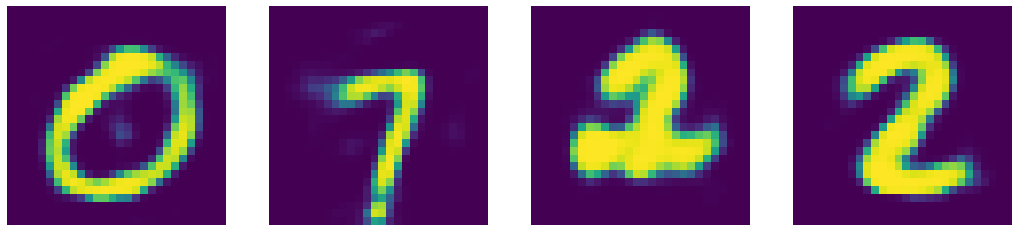

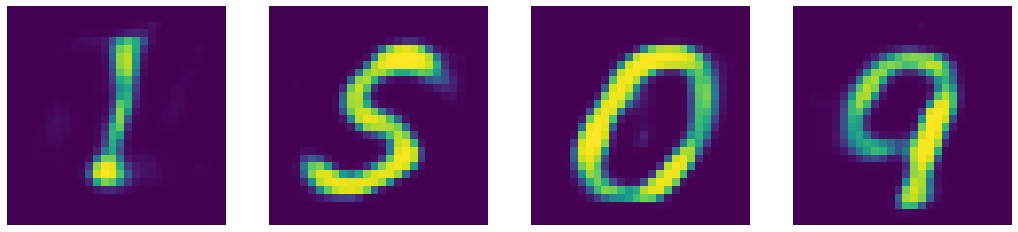

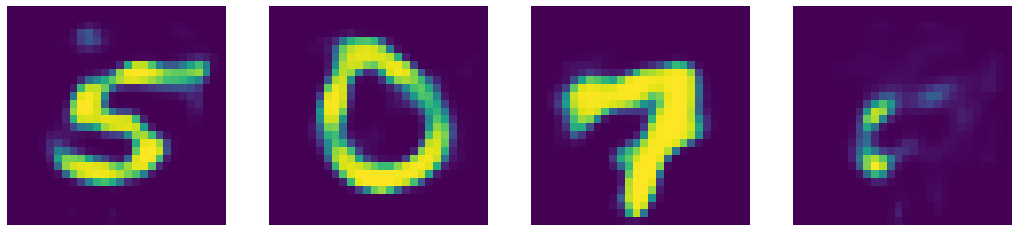

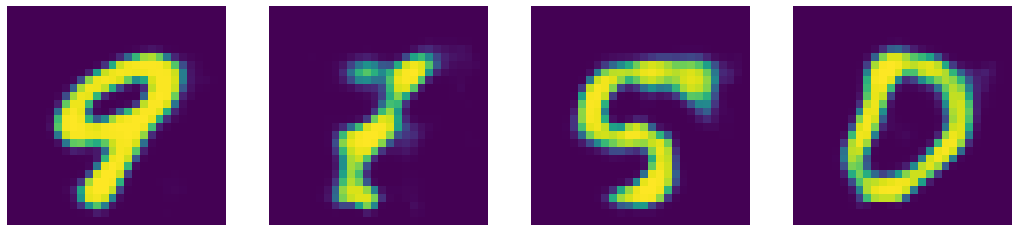

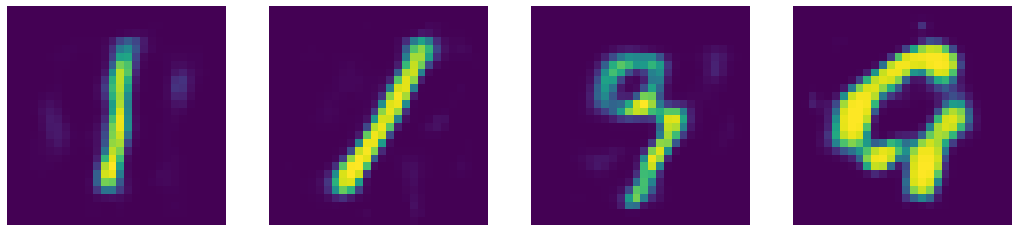

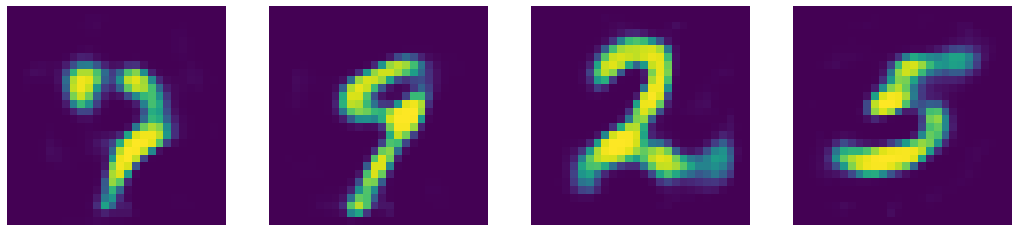

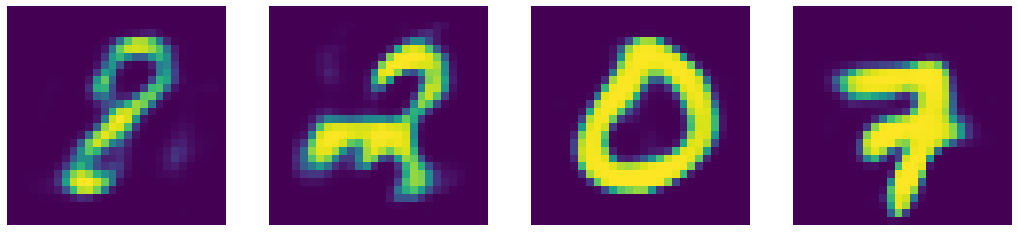

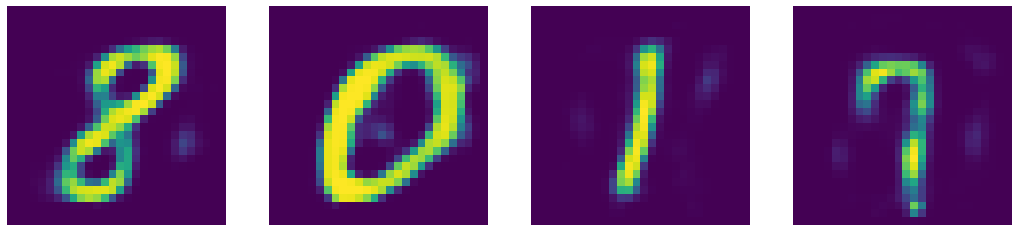

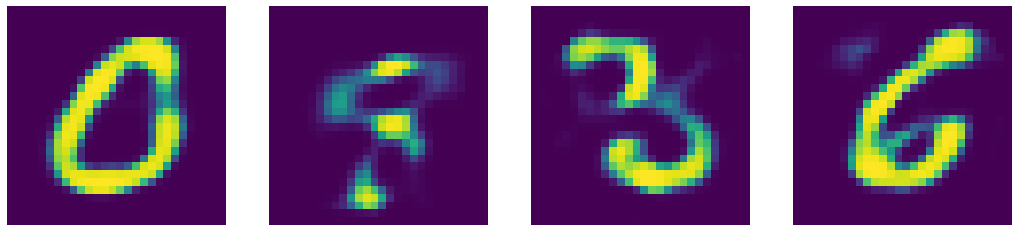

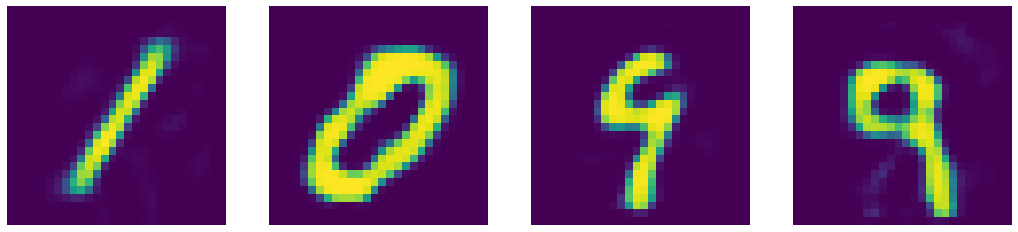

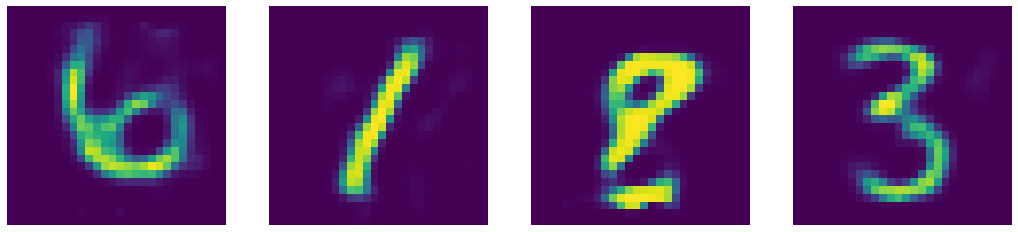

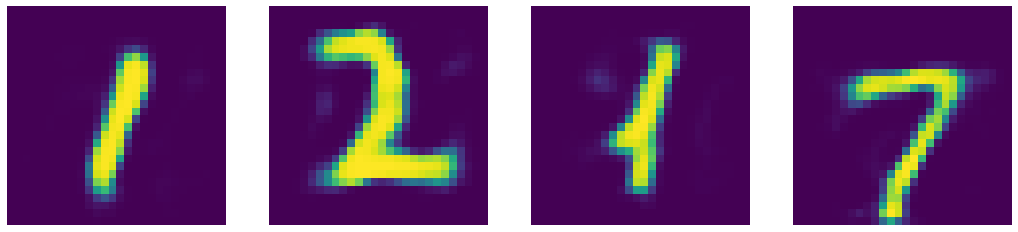

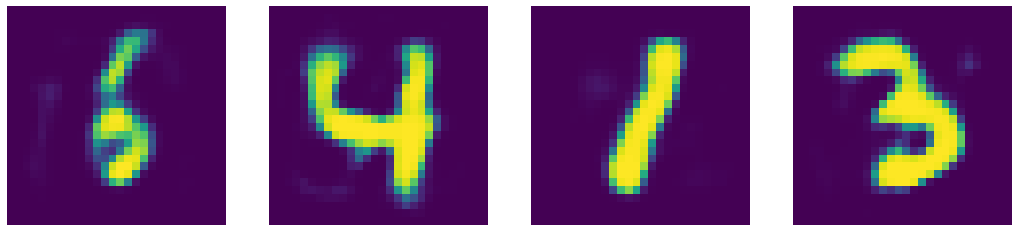

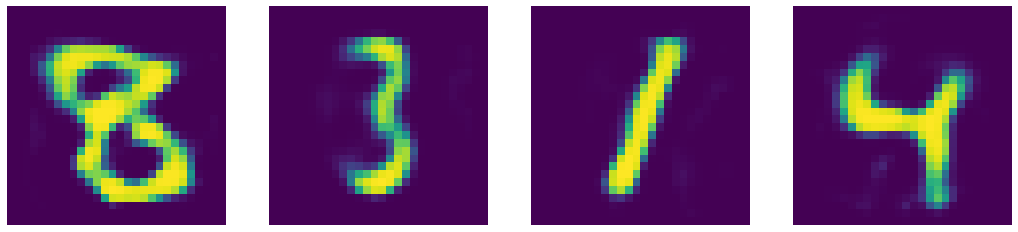

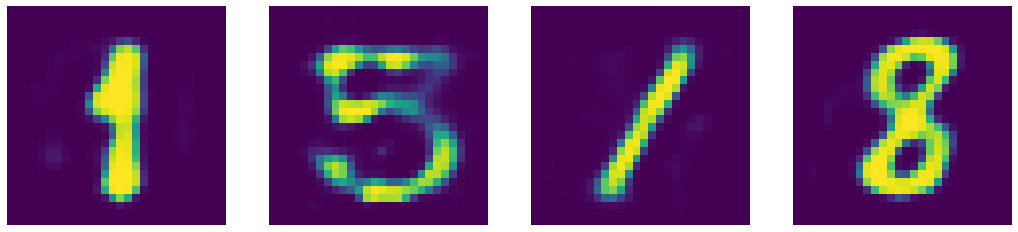

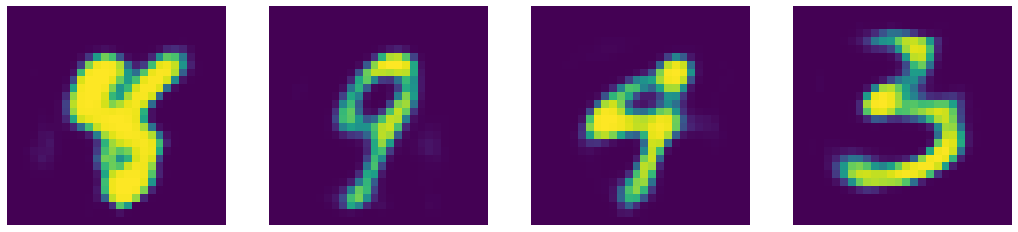

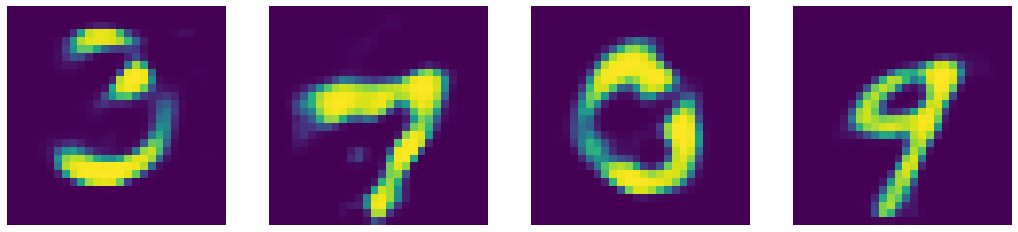

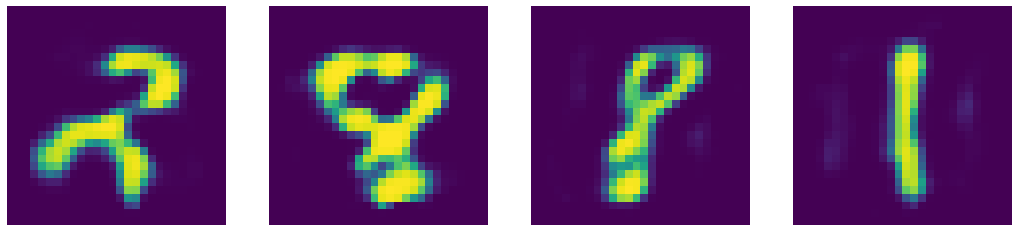

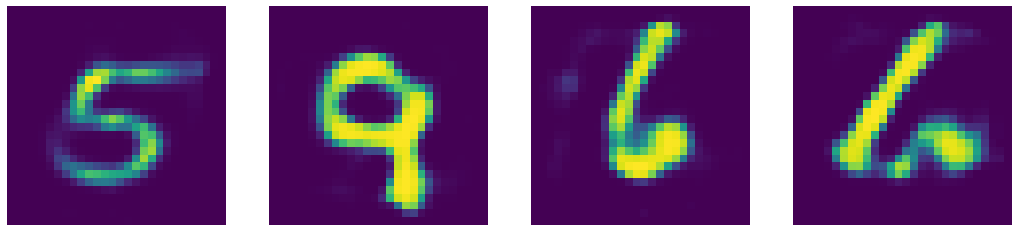

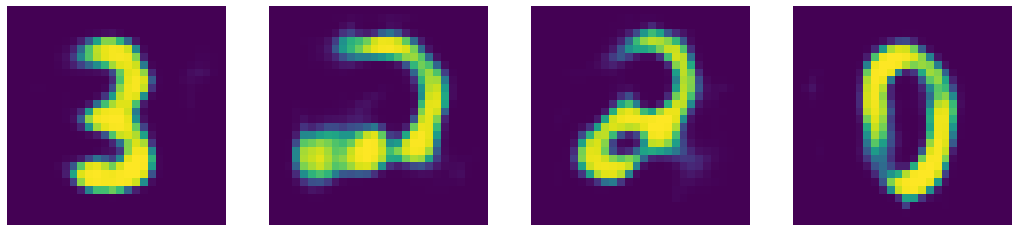

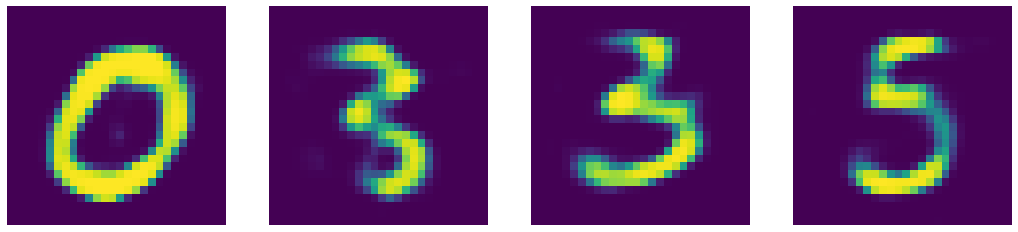

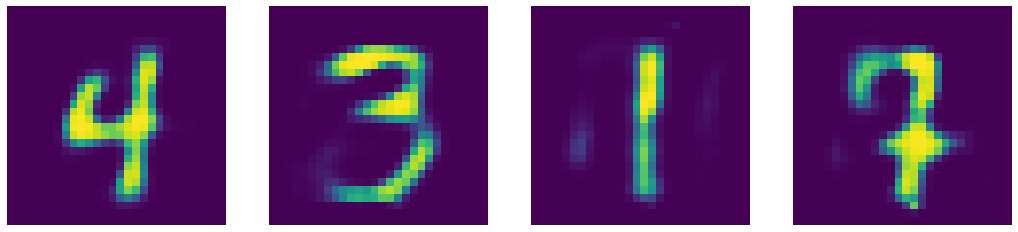

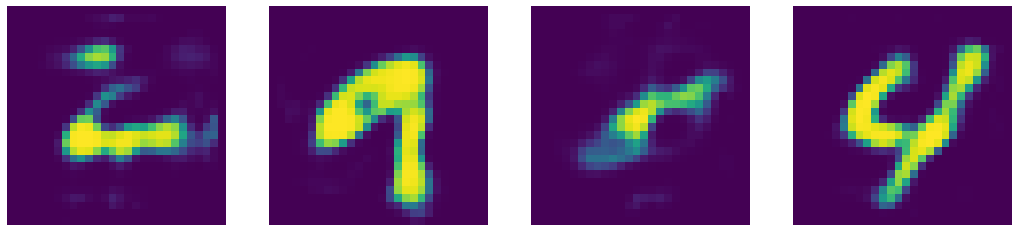

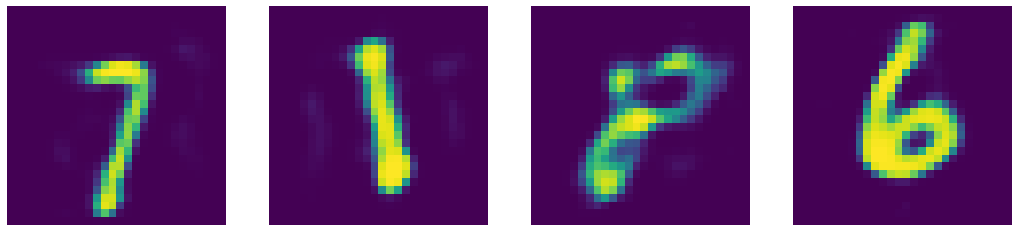

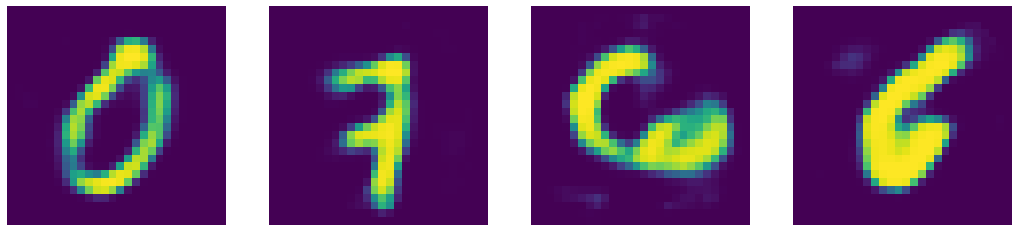

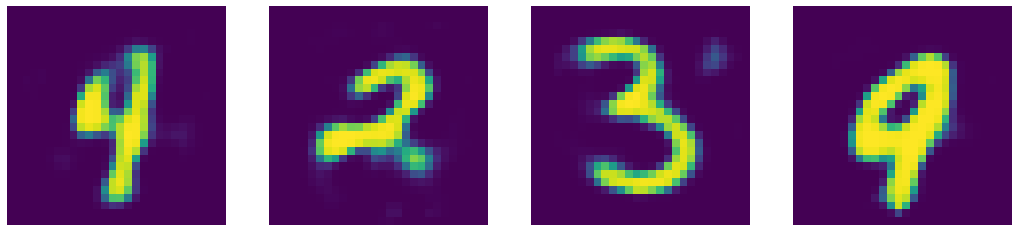

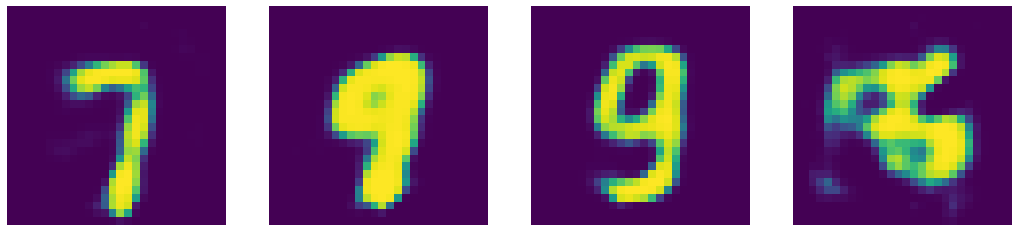

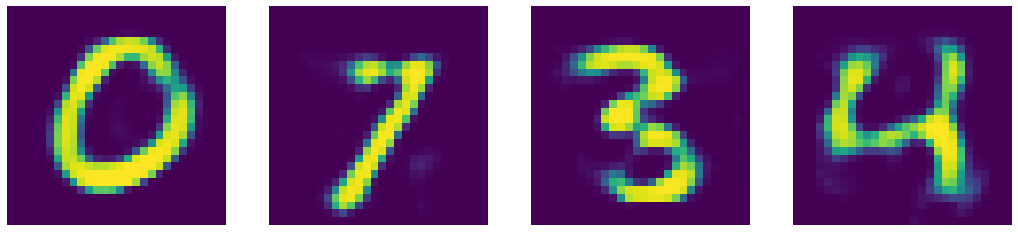

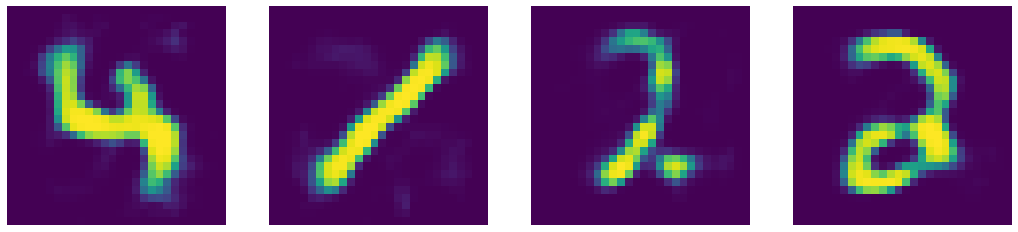

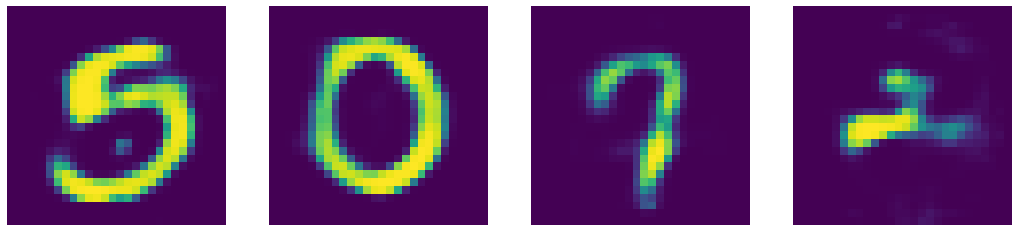

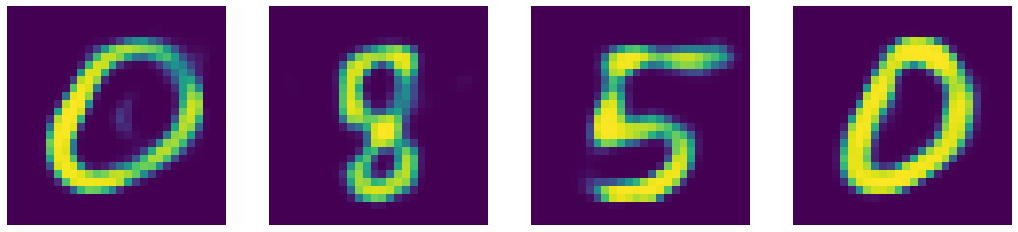

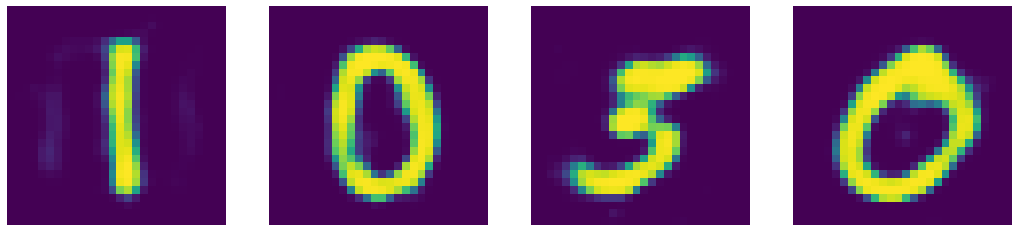

In [ ]:
d=30;
model4 = Autoencoder(d).to(device)
criterion = nn.MSELoss() # on définit un critère qui va nous servir pour la fonction de coût

learning_rate = 1e-3 # soit 0.001, ce qui est pas mal

#  l'optimizer permet d'appliquer l'algo du gradient pour minimiser le coût
optimizer4 = torch.optim.Adam(
    model4.parameters(), # permet de récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate, # permet de déterminer la vitesse à laquelle on ajuste les poids
)

nb_epoch = 100
epoch_loss_sae = training_sae(nb_epoch, model4, criterion, optimizer4)

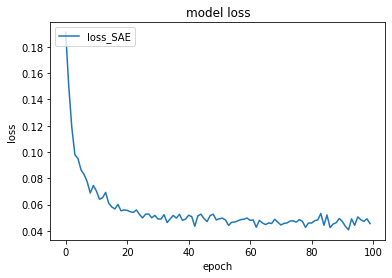

In [ ]:
displayLoss(epoch_loss_sae, ['loss_SAE'])

On constate que la perte se stabilise à partir de l'époque 50. Ceci dit, on devra passer de 20 à 50 épochs

epoch [1/30], loss:0.2100
epoch [2/30], loss:0.1594
epoch [3/30], loss:0.1172
epoch [4/30], loss:0.1090
epoch [5/30], loss:0.0924
epoch [6/30], loss:0.0922
epoch [7/30], loss:0.0760
epoch [8/30], loss:0.0833
epoch [9/30], loss:0.0696
epoch [10/30], loss:0.0671
epoch [11/30], loss:0.0703
epoch [12/30], loss:0.0724
epoch [13/30], loss:0.0637
epoch [14/30], loss:0.0578
epoch [15/30], loss:0.0633
epoch [16/30], loss:0.0599
epoch [17/30], loss:0.0582
epoch [18/30], loss:0.0570
epoch [19/30], loss:0.0560
epoch [20/30], loss:0.0544
epoch [21/30], loss:0.0593


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


epoch [22/30], loss:0.0627
epoch [23/30], loss:0.0575
epoch [24/30], loss:0.0555
epoch [25/30], loss:0.0540
epoch [26/30], loss:0.0526
epoch [27/30], loss:0.0478
epoch [28/30], loss:0.0531
epoch [29/30], loss:0.0519
epoch [30/30], loss:0.0465


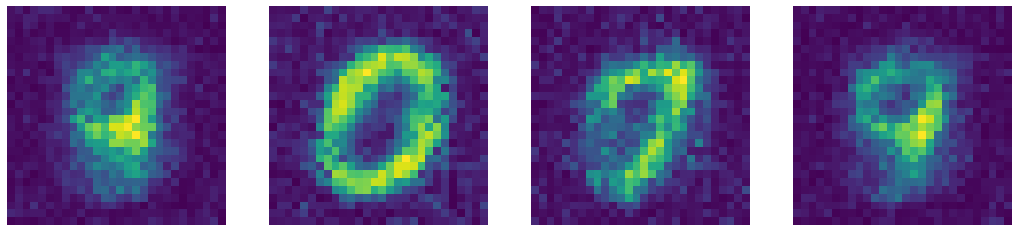

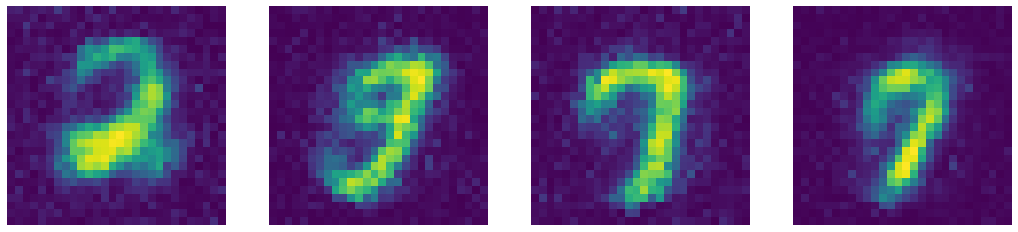

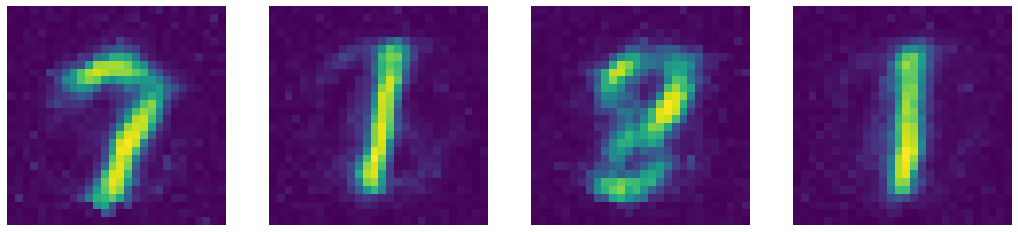

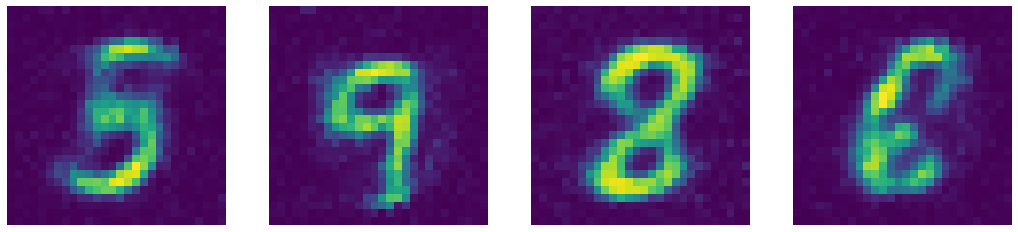

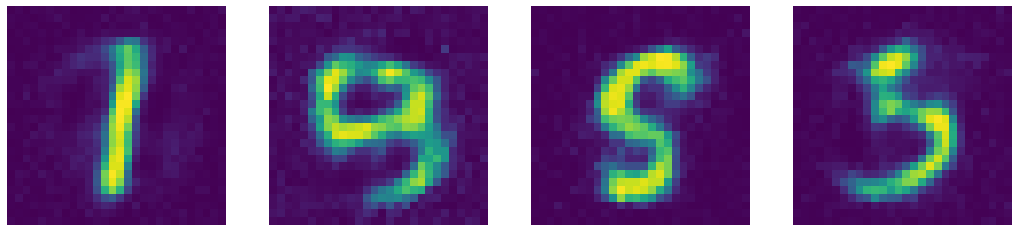

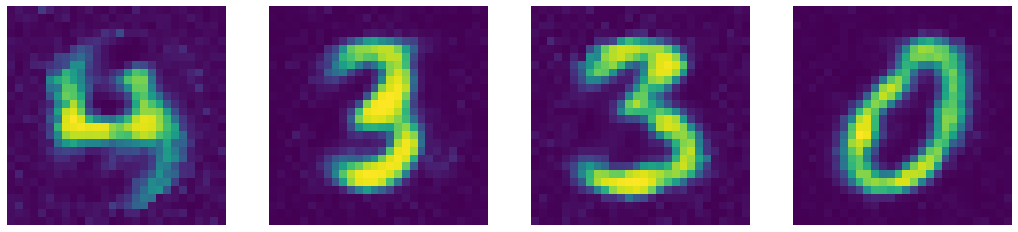

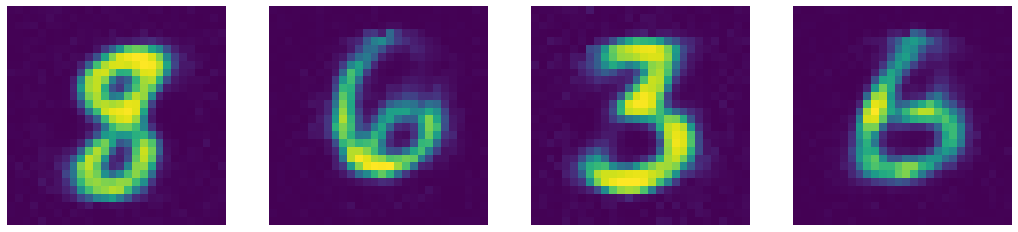

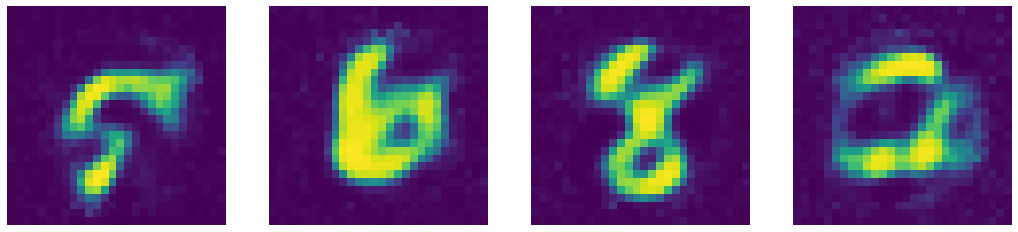

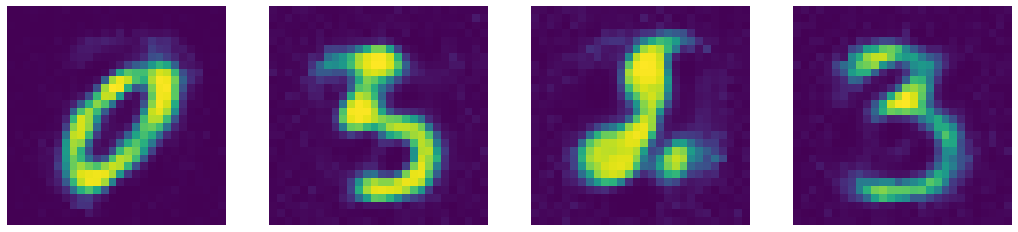

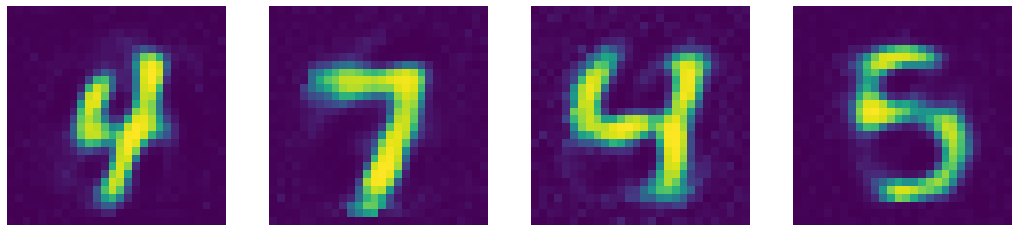

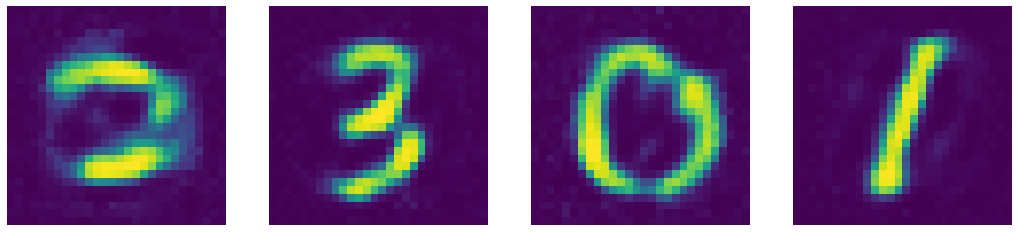

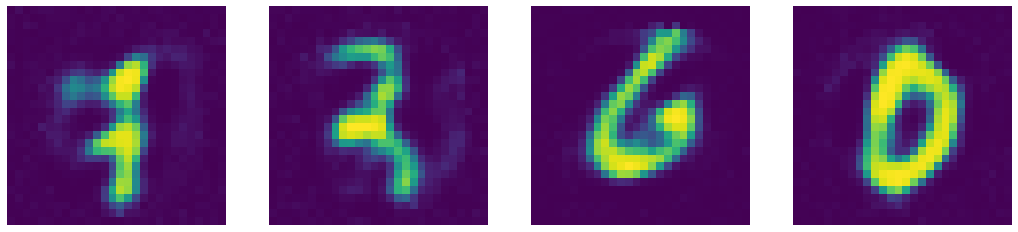

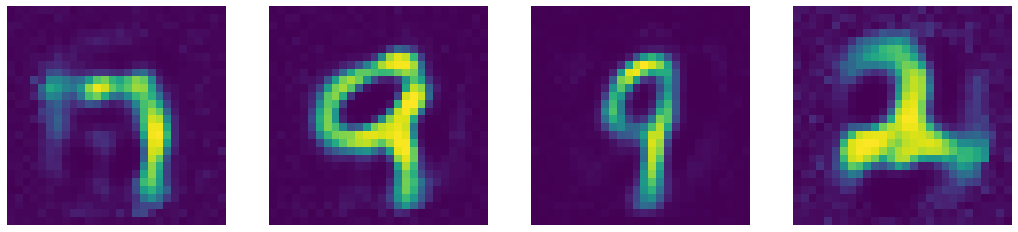

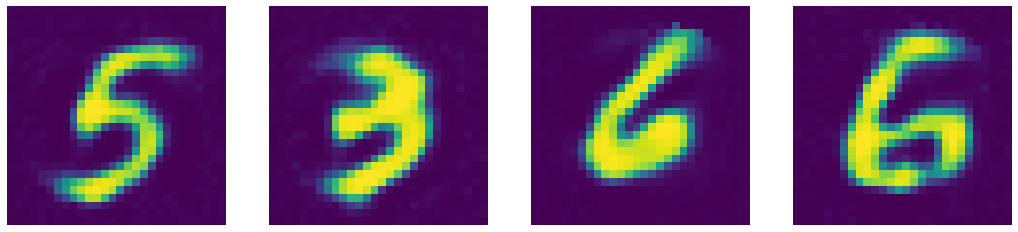

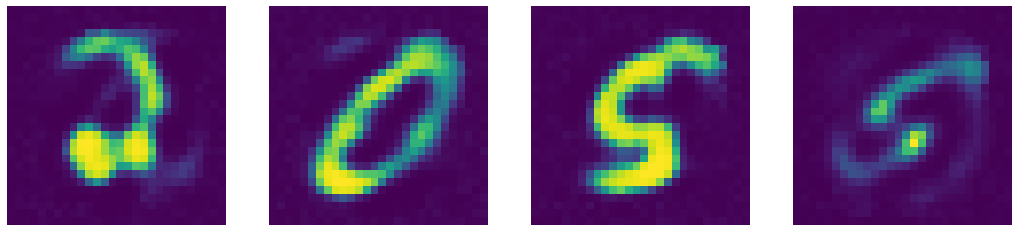

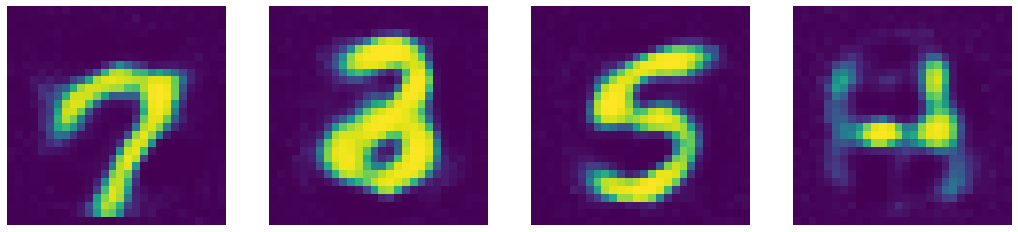

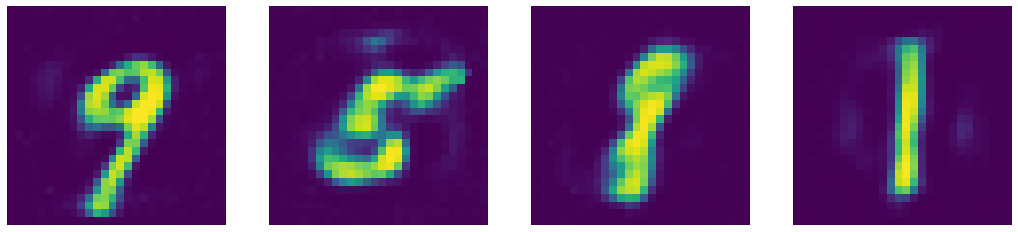

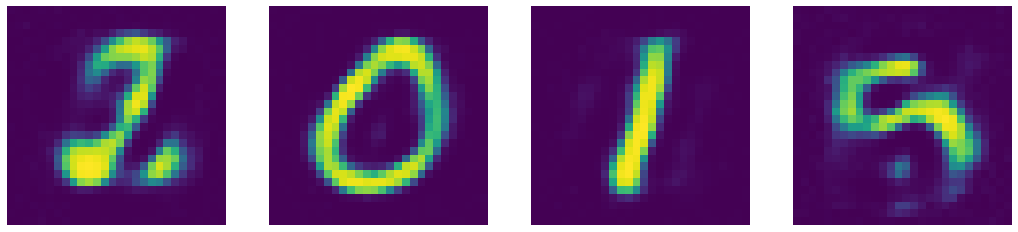

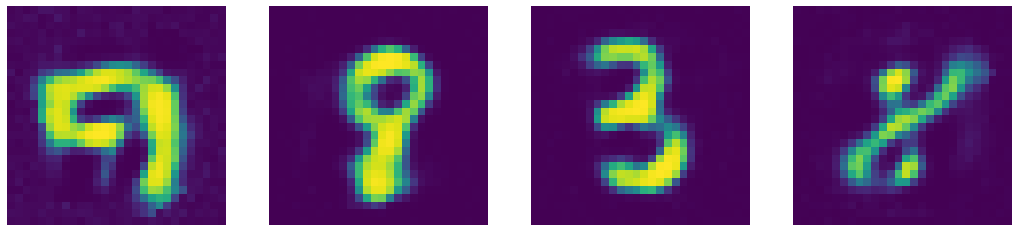

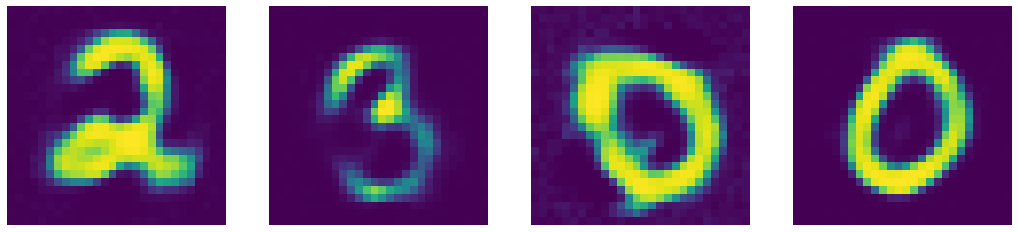

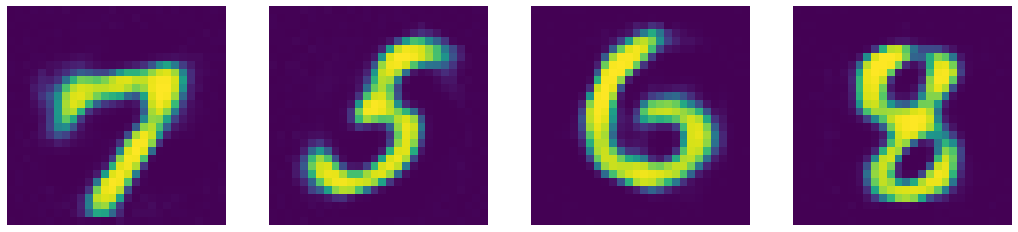

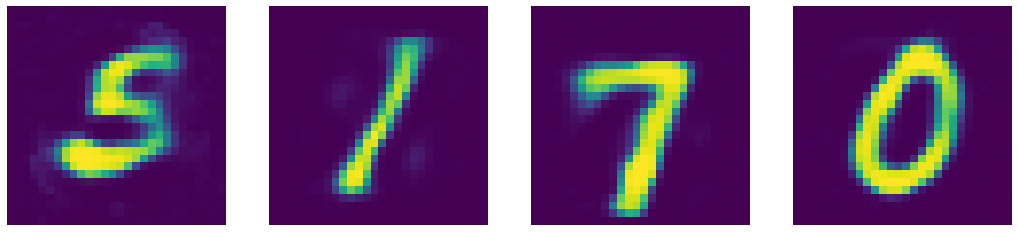

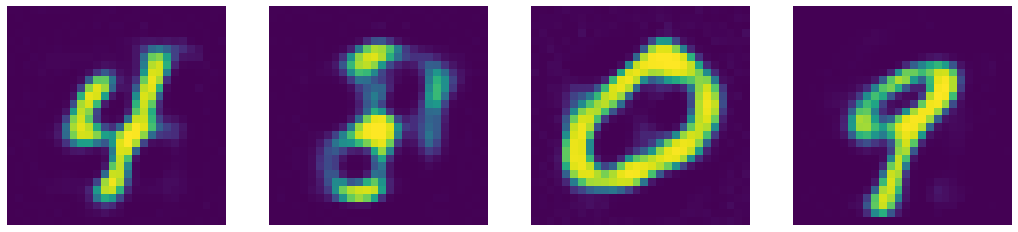

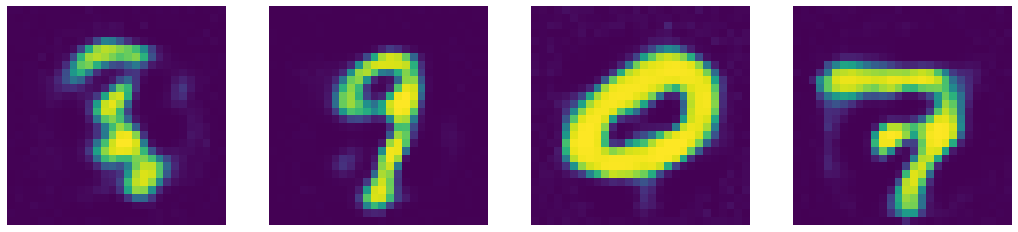

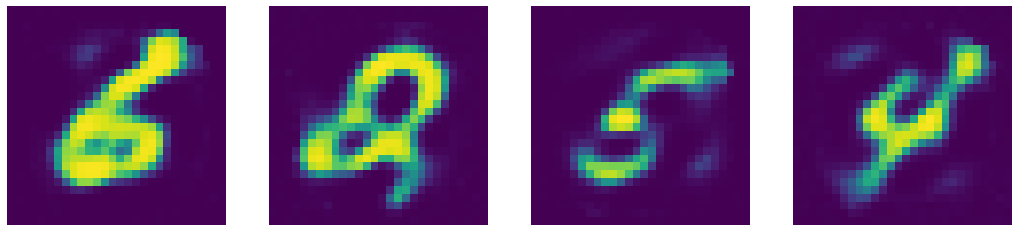

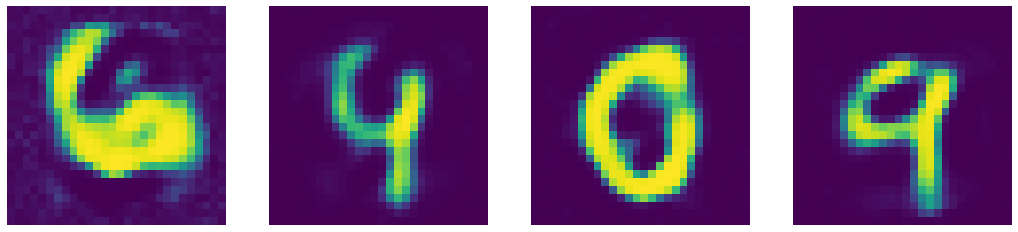

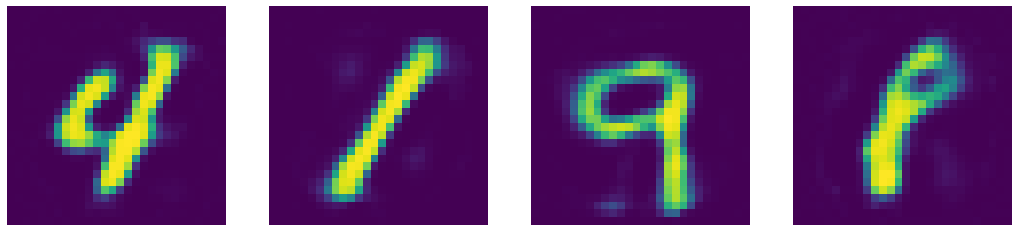

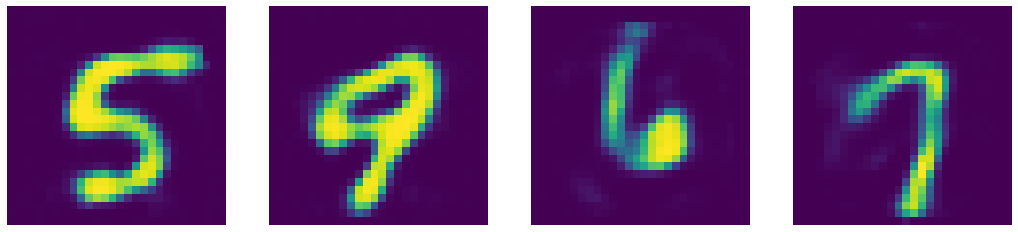

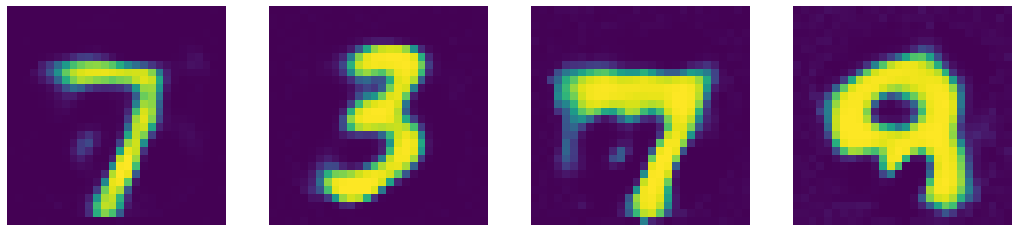

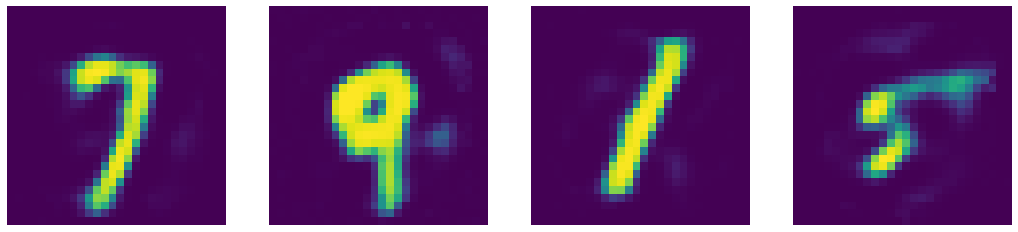

In [ ]:
d=30;
model5 = Autoencoder(d).to(device)
criterion = nn.MSELoss() # on définit un critère qui va nous servir pour la fonction de coût

learning_rate = 1e-3 # soit 0.001, ce qui est pas mal

#  l'optimizer permet d'appliquer l'algo du gradient pour minimiser le coût
optimizer5 = torch.optim.Adam(
    model5.parameters(), # permet de récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate, # permet de déterminer la vitesse à laquelle on ajuste les poids
)

nb_epoch = 30
epoch_loss_sae = training_sae(nb_epoch, model5, criterion, optimizer5)

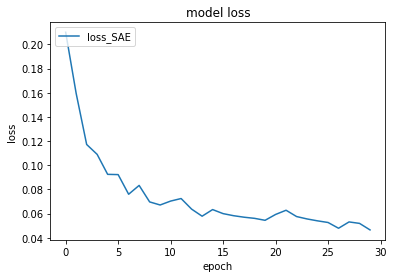

In [ ]:
displayLoss(epoch_loss_sae, ['loss_SAE'])

On constate que la perte commence à se stabiliser aprrès l'époch 20. Le choix d'une époch 30 sera donc raisonnable

- Modification de la taille de sortie avec un taux de 0.001 et un nombre d'époch de 30

On commence d'abord par augmenter la valeur de d dans SAE. Soit d=100

epoch [1/30], loss:0.1062
epoch [2/30], loss:0.0682
epoch [3/30], loss:0.0515
epoch [4/30], loss:0.0413
epoch [5/30], loss:0.0330
epoch [6/30], loss:0.0315
epoch [7/30], loss:0.0272
epoch [8/30], loss:0.0237
epoch [9/30], loss:0.0222
epoch [10/30], loss:0.0238
epoch [11/30], loss:0.0200
epoch [12/30], loss:0.0184
epoch [13/30], loss:0.0183
epoch [14/30], loss:0.0172
epoch [15/30], loss:0.0179
epoch [16/30], loss:0.0165
epoch [17/30], loss:0.0136
epoch [18/30], loss:0.0149
epoch [19/30], loss:0.0138
epoch [20/30], loss:0.0136
epoch [21/30], loss:0.0139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


epoch [22/30], loss:0.0149
epoch [23/30], loss:0.0135
epoch [24/30], loss:0.0129
epoch [25/30], loss:0.0125
epoch [26/30], loss:0.0121
epoch [27/30], loss:0.0126
epoch [28/30], loss:0.0127
epoch [29/30], loss:0.0127
epoch [30/30], loss:0.0118


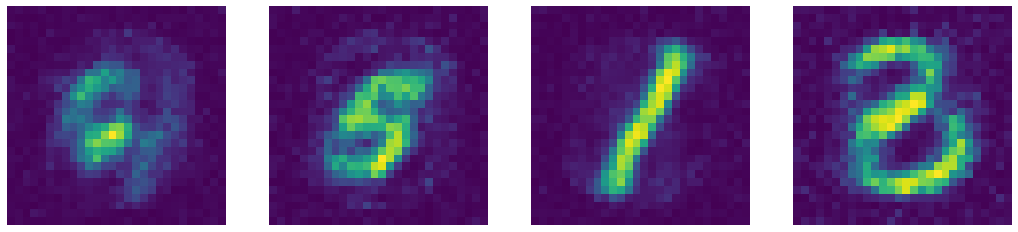

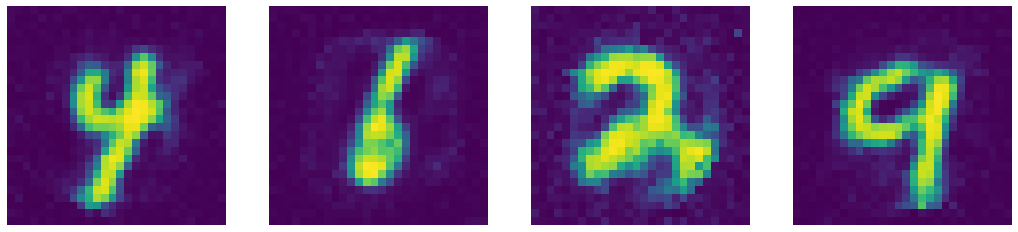

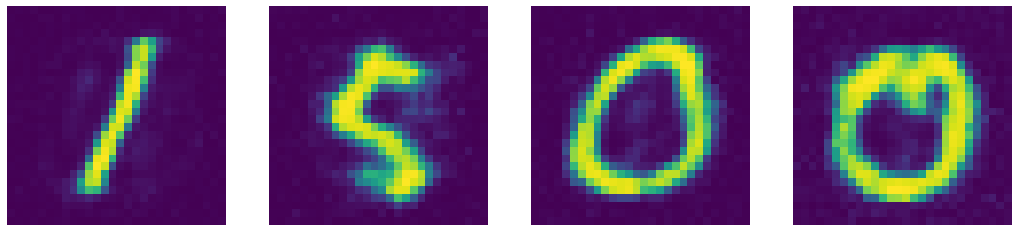

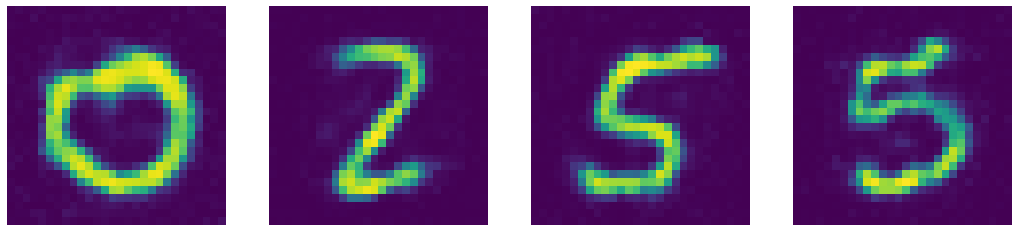

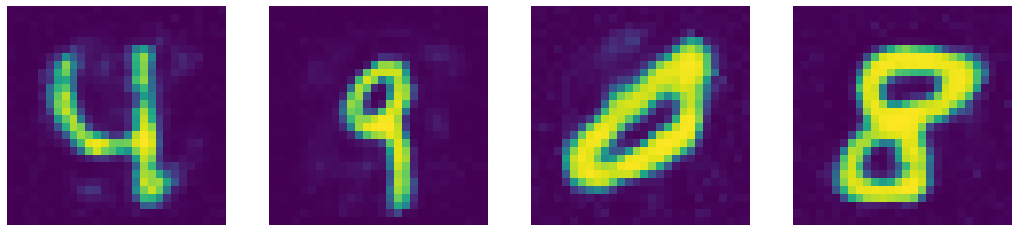

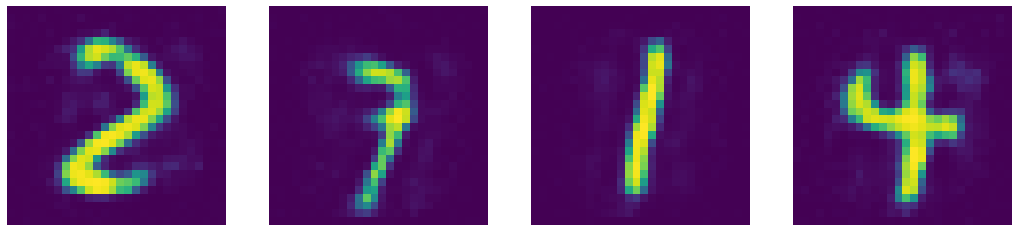

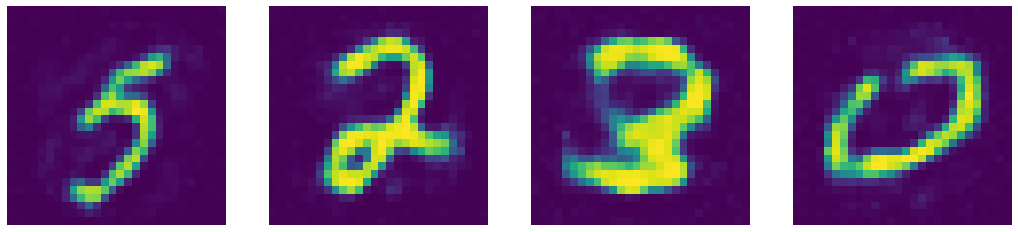

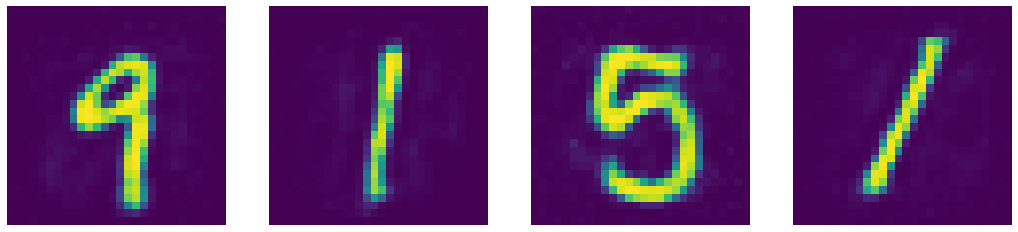

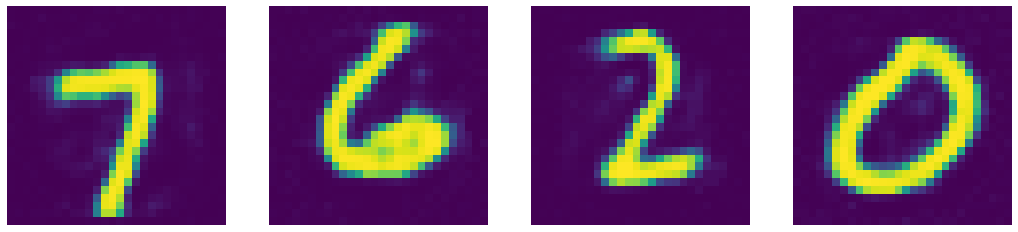

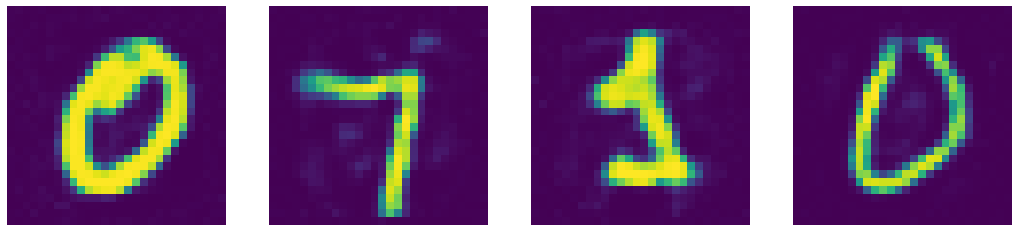

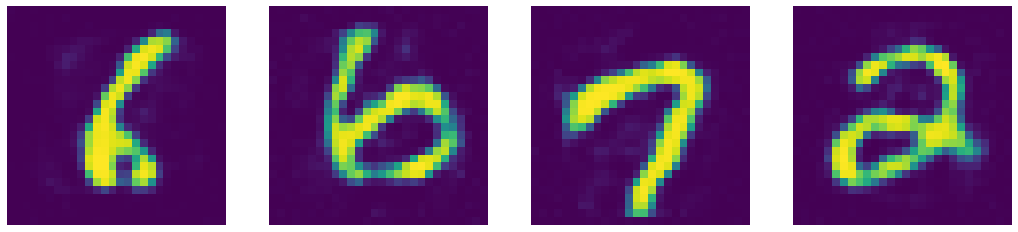

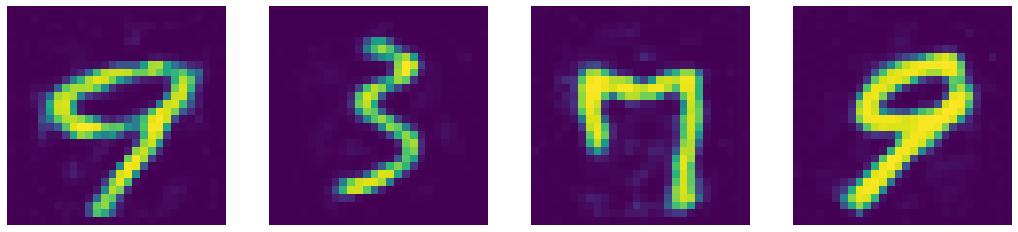

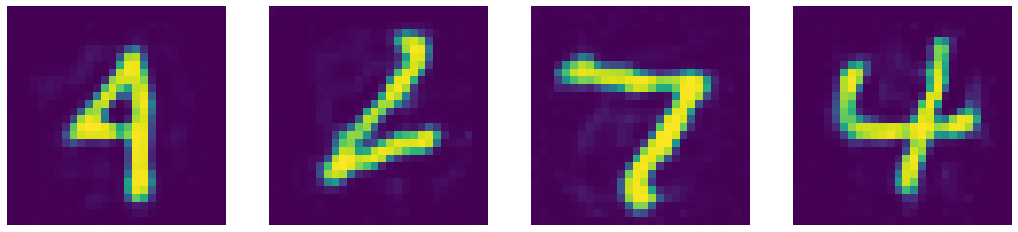

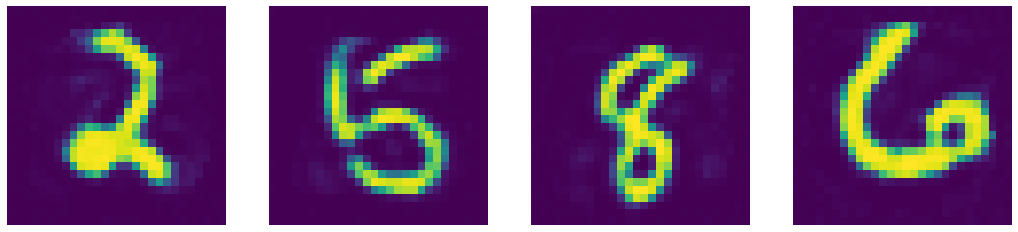

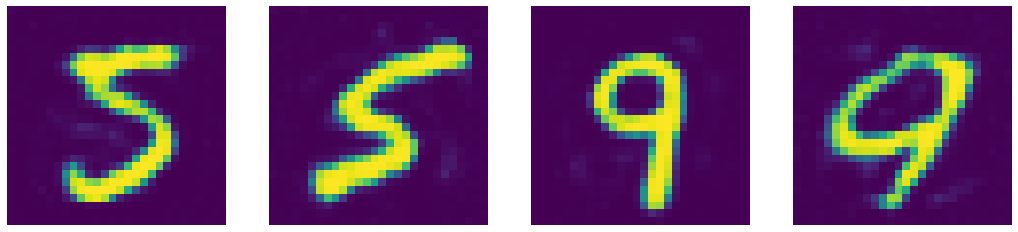

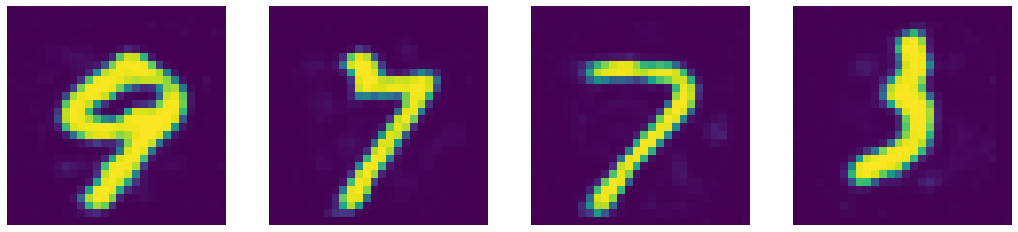

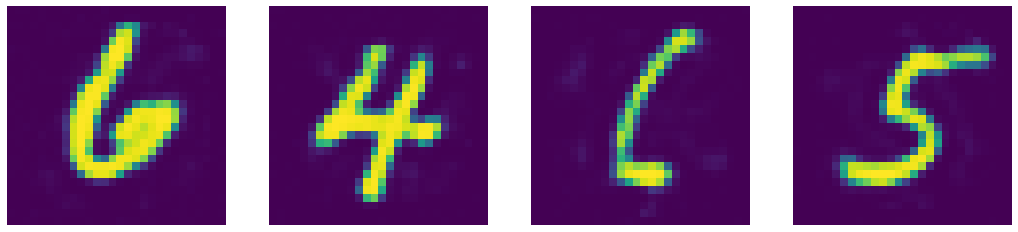

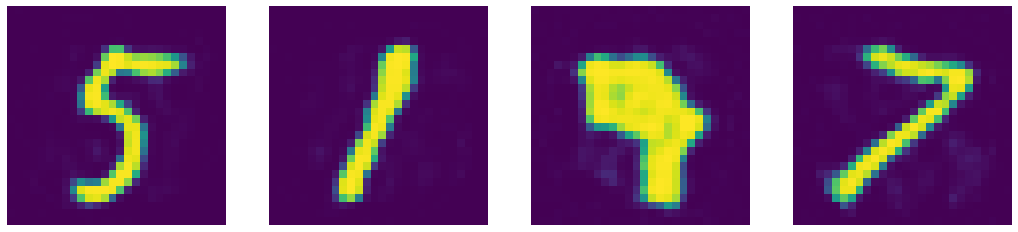

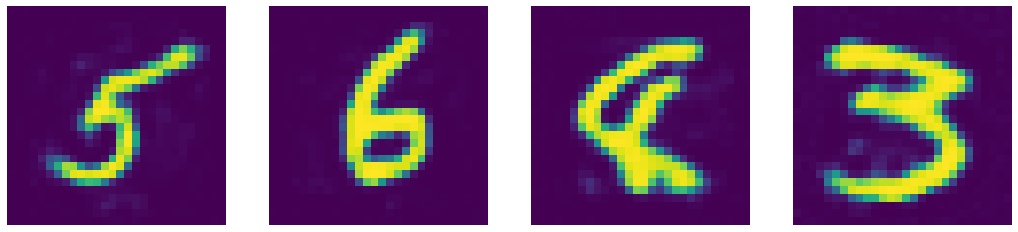

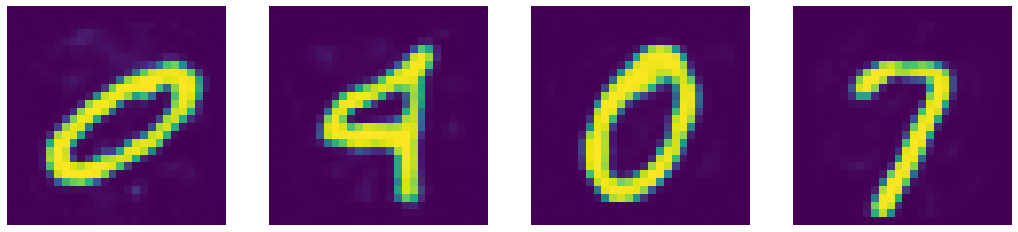

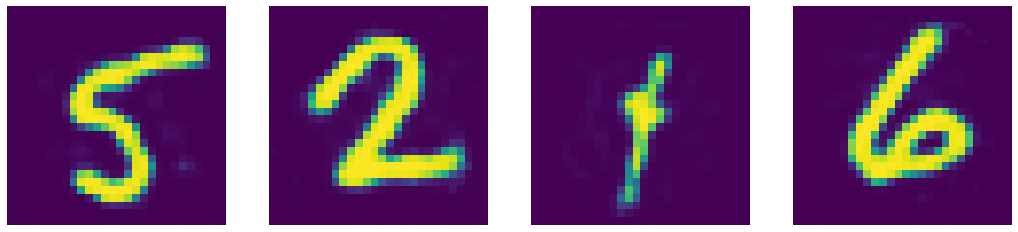

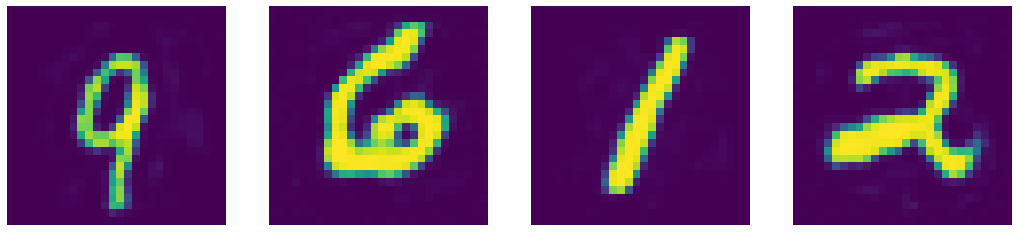

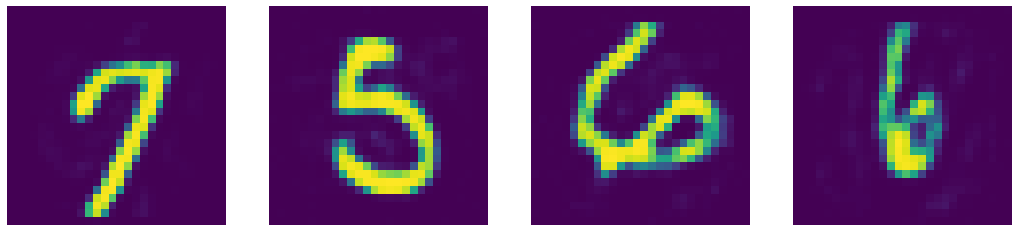

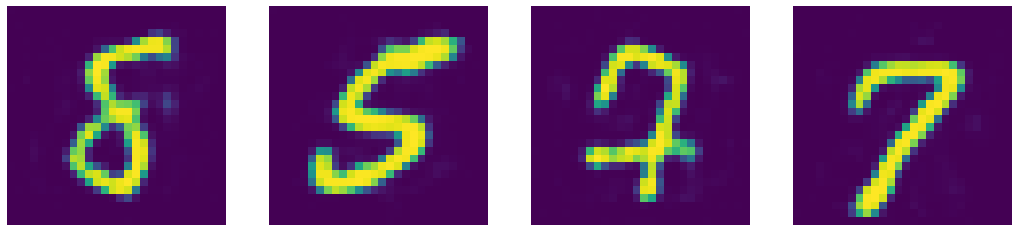

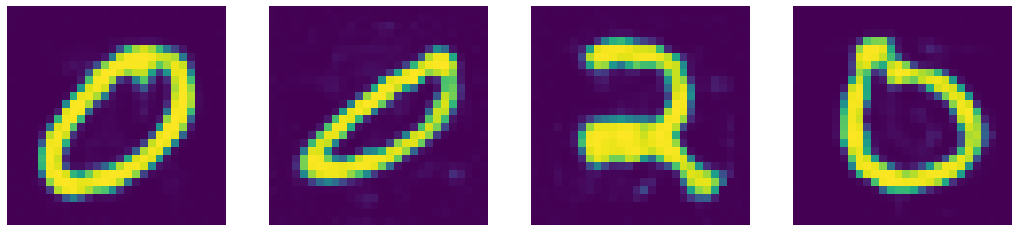

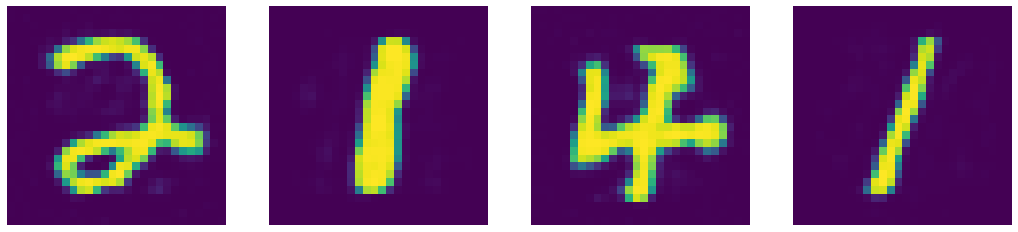

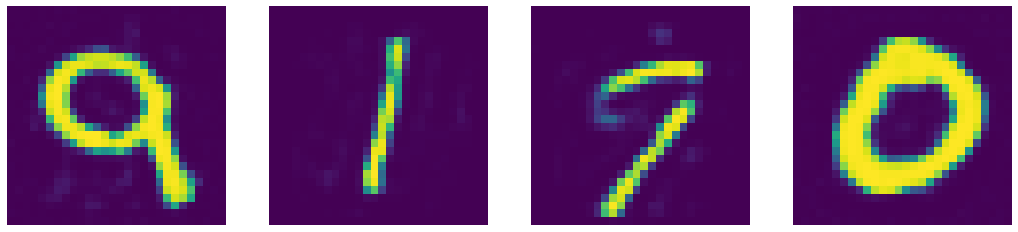

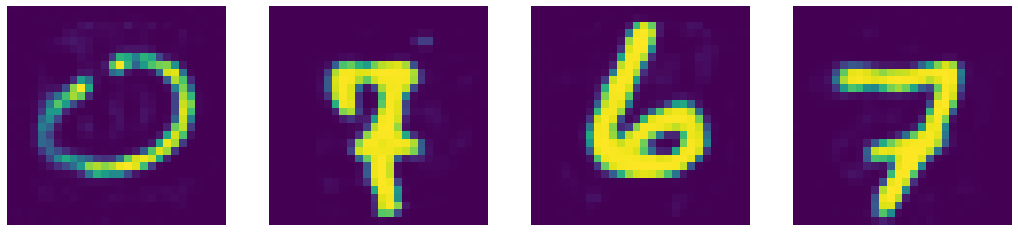

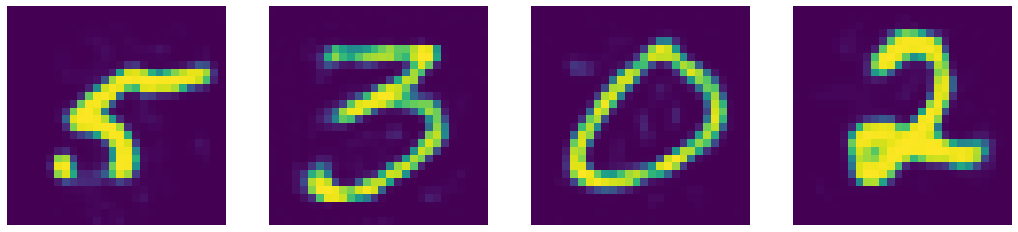

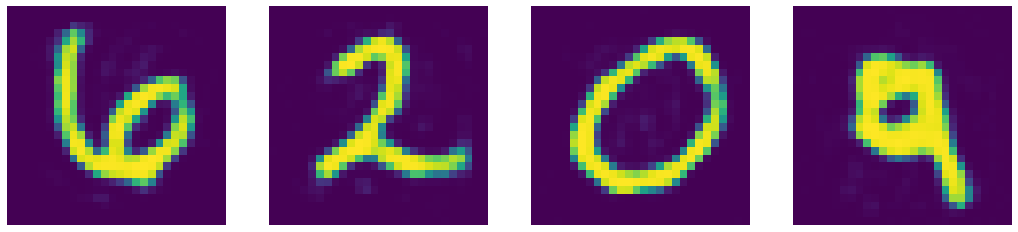

In [ ]:
d = 100
model6 = Autoencoder(d).to(device)
criterion = nn.MSELoss() # on définit un critère qui va nous servir pour la fonction de coût

learning_rate = 1e-3 # soit 0.001, ce qui est pas mal

#  l'optimizer permet d'appliquer l'algo du gradient pour minimiser le coût
optimizer6 = torch.optim.Adam(
    model6.parameters(), # permet de récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate, # permet de déterminer la vitesse à laquelle on ajuste les poids
)

nb_epoch = 30
epoch_loss_sae = training_sae(nb_epoch, model6, criterion, optimizer6)

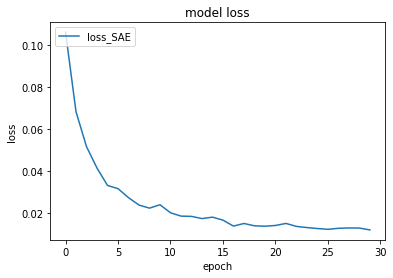

In [ ]:
displayLoss(epoch_loss_sae, ['loss_SAE'])

Avec une taille de sortie de 100, on obtient une image de sortie plus proche de l'image originale. Aussi, la perte part de 0.11 à 0.01. Ensuite elle se stabilise après l'époch 18.

- Avec l'auto-encodeur DAE
  - Modification de la taille de sortie (soit d=30)

epoch [1/20], loss:0.2069
epoch [2/20], loss:0.1629
epoch [3/20], loss:0.1407
epoch [4/20], loss:0.1250
epoch [5/20], loss:0.1247
epoch [6/20], loss:0.1233
epoch [7/20], loss:0.1132
epoch [8/20], loss:0.1015
epoch [9/20], loss:0.1033
epoch [10/20], loss:0.0991
epoch [11/20], loss:0.0957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


epoch [12/20], loss:0.0909
epoch [13/20], loss:0.0975
epoch [14/20], loss:0.0968
epoch [15/20], loss:0.0926
epoch [16/20], loss:0.0883
epoch [17/20], loss:0.0967
epoch [18/20], loss:0.0915
epoch [19/20], loss:0.0938
epoch [20/20], loss:0.0858


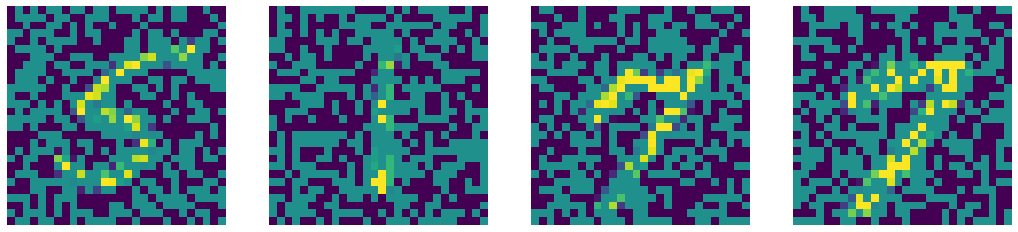

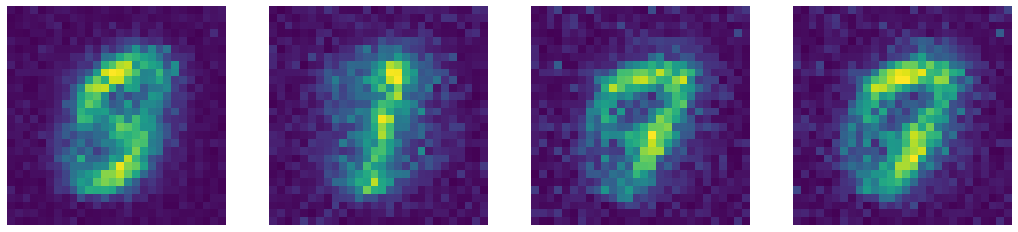

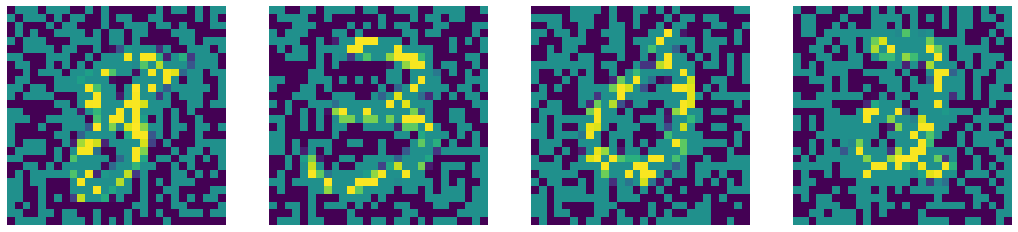

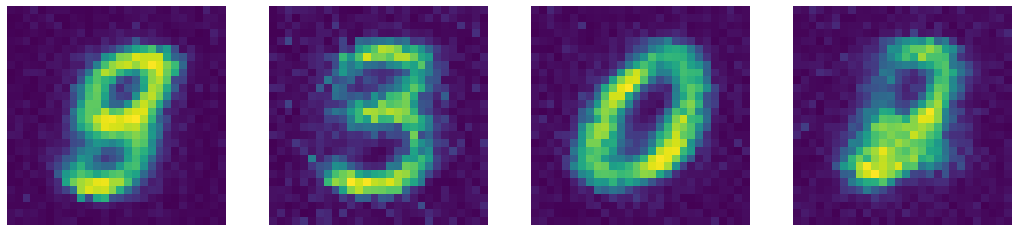

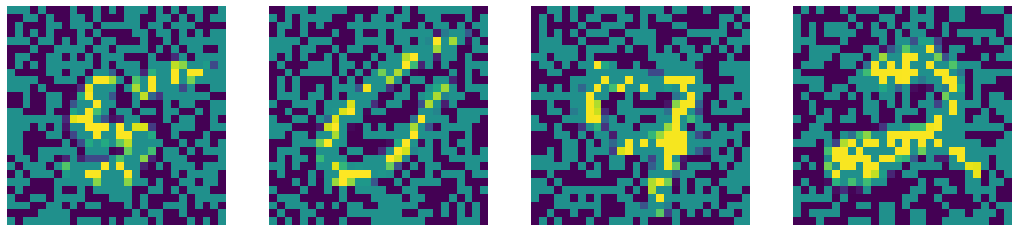

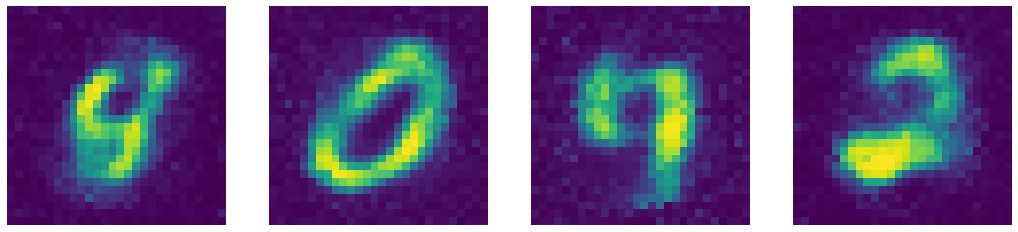

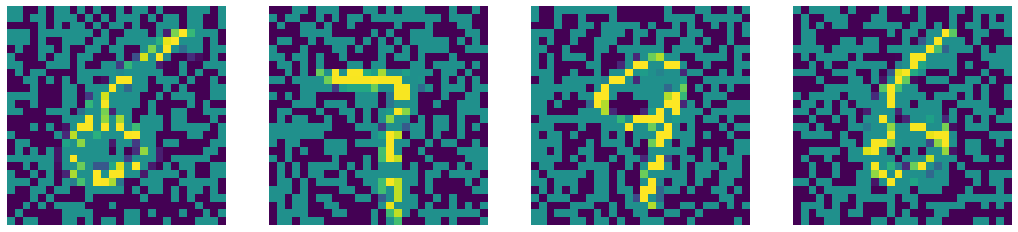

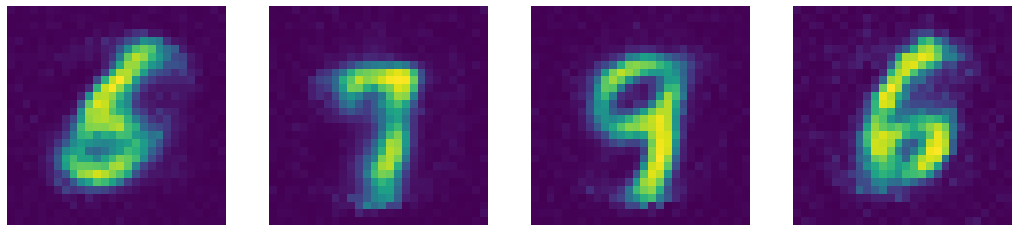

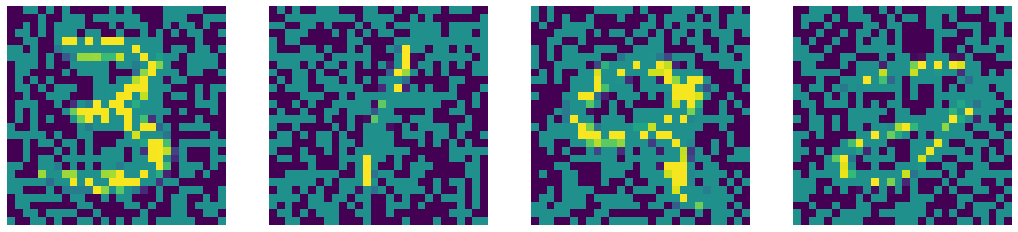

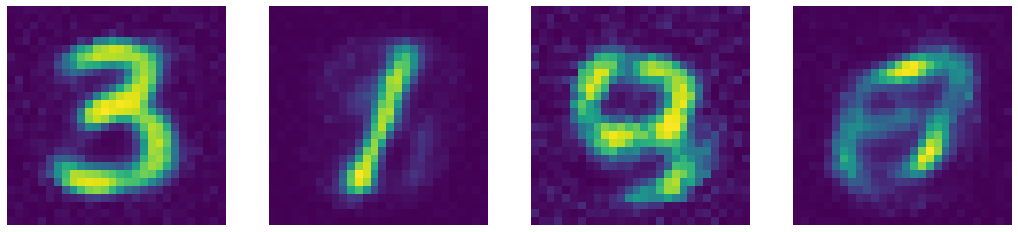

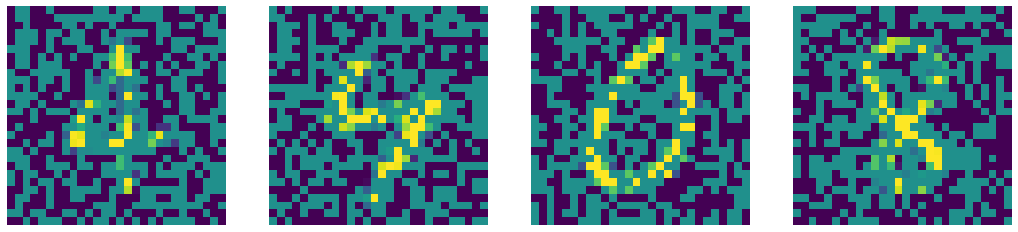

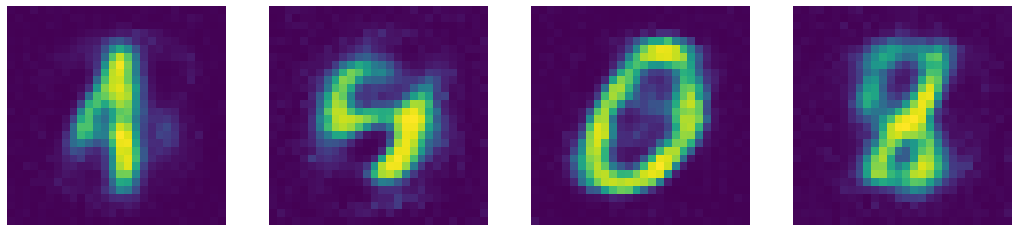

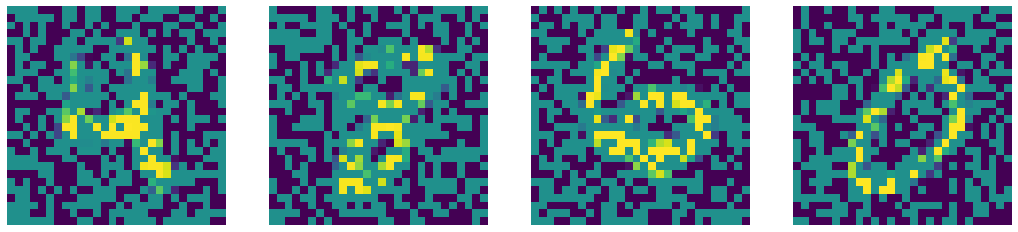

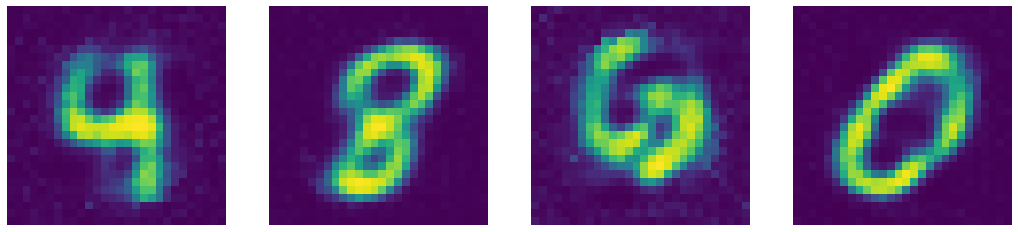

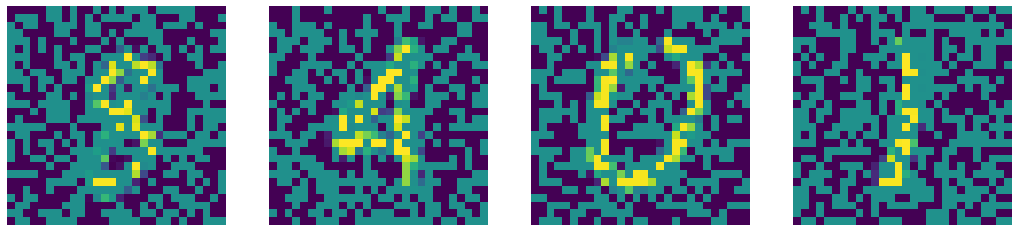

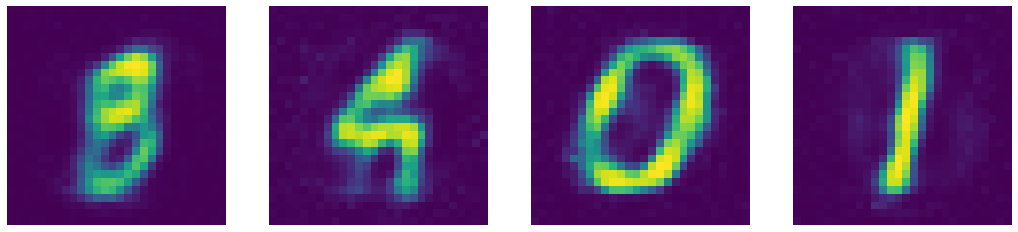

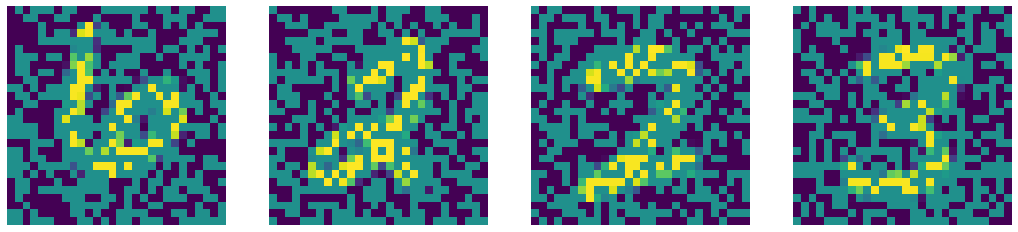

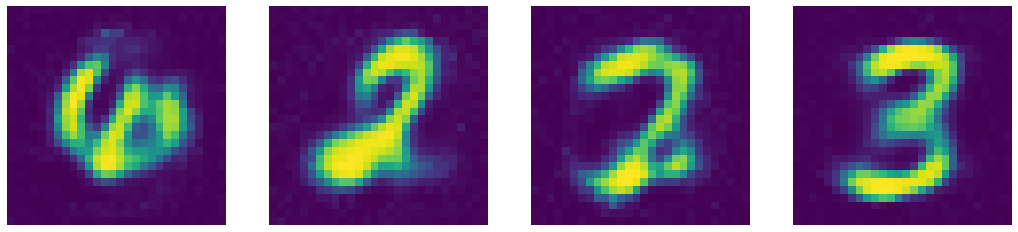

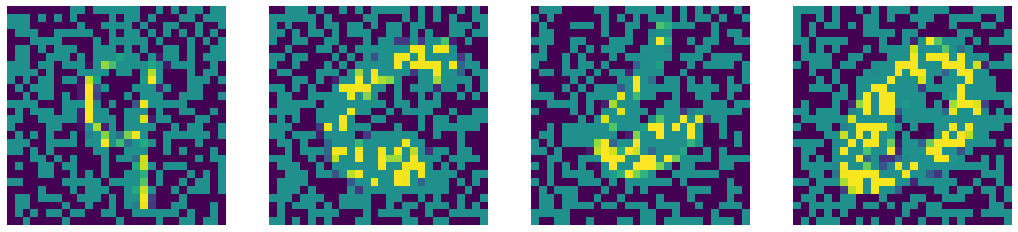

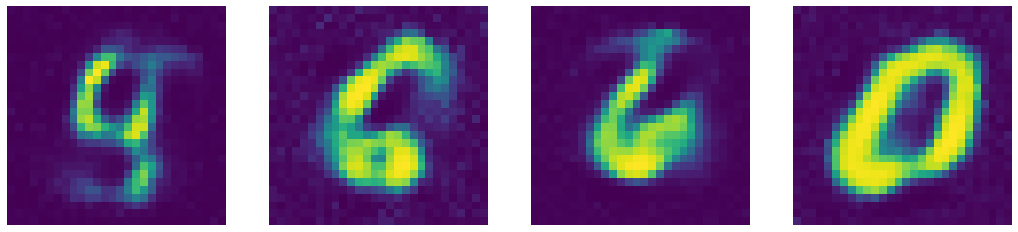

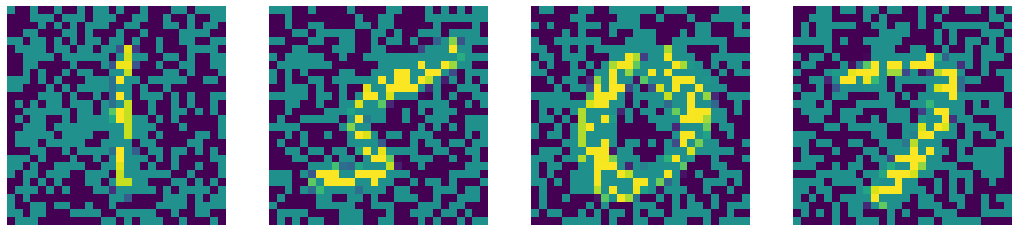

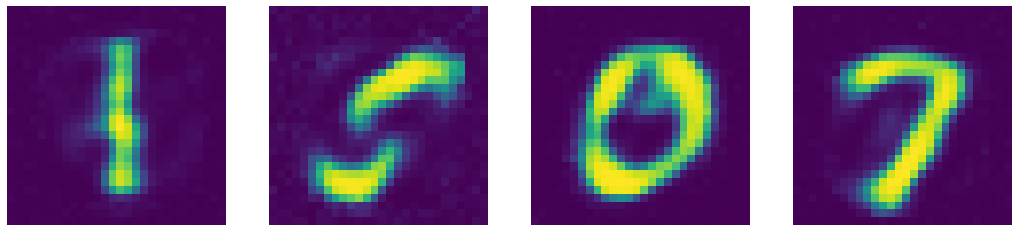

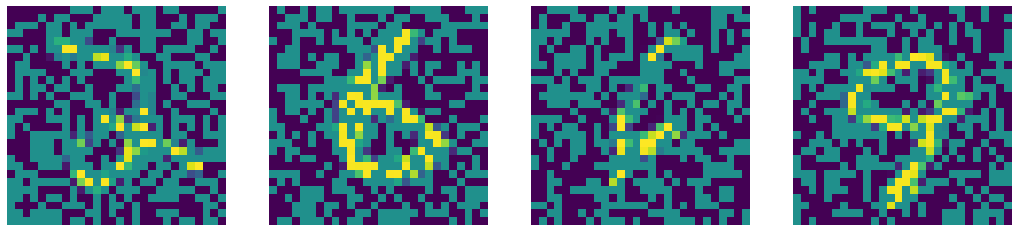

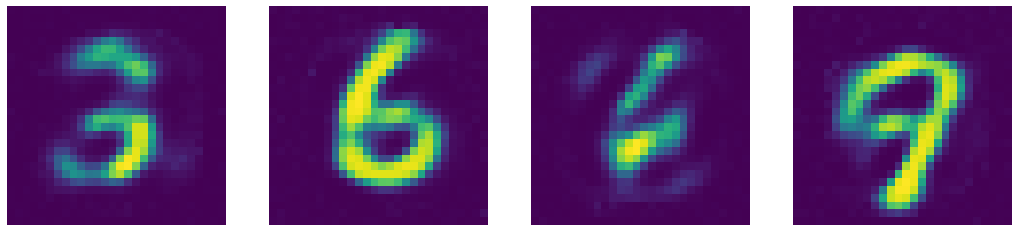

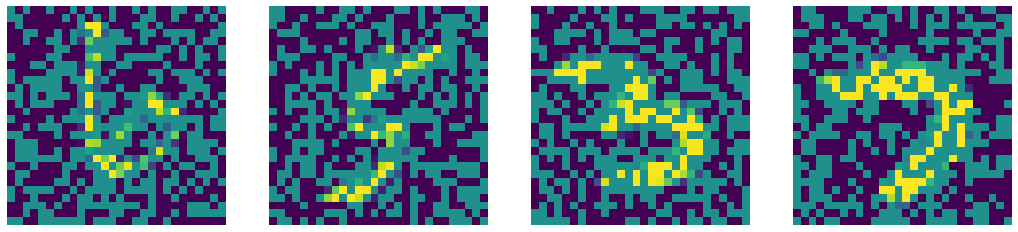

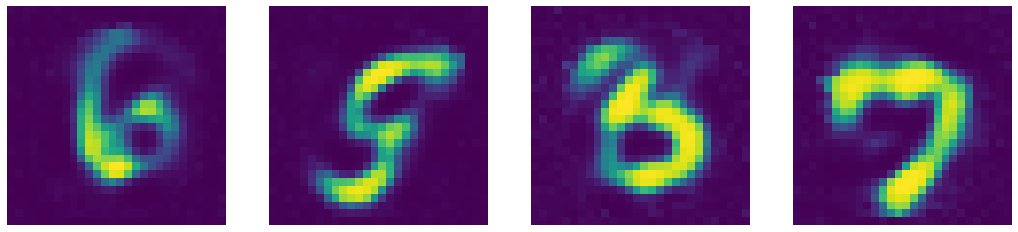

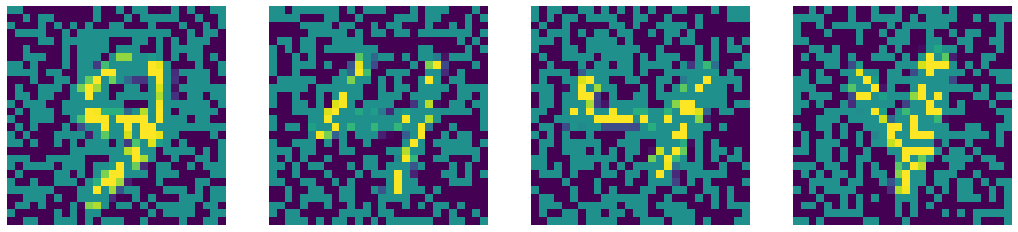

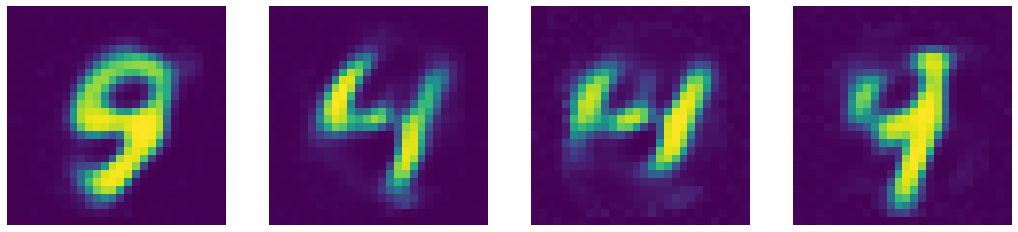

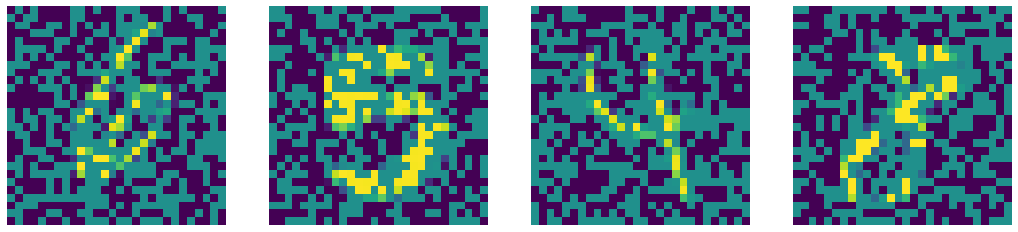

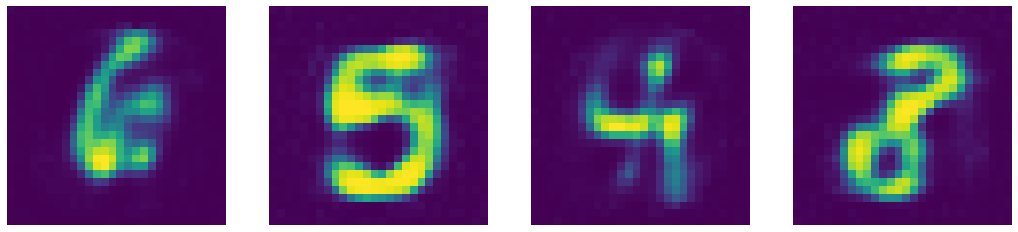

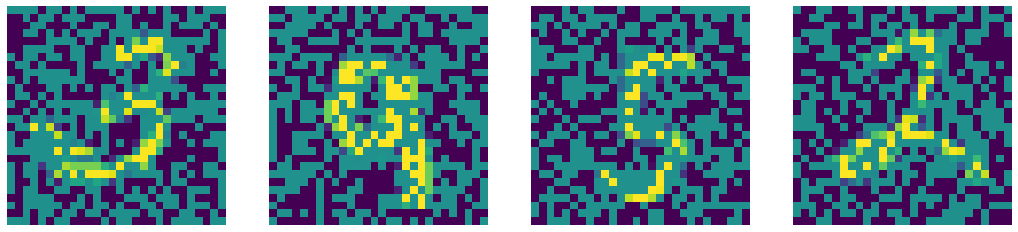

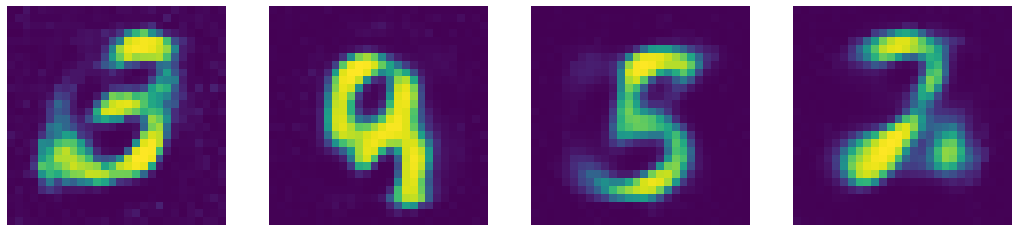

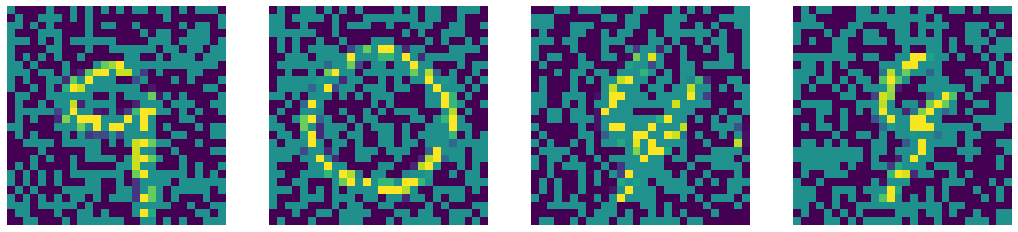

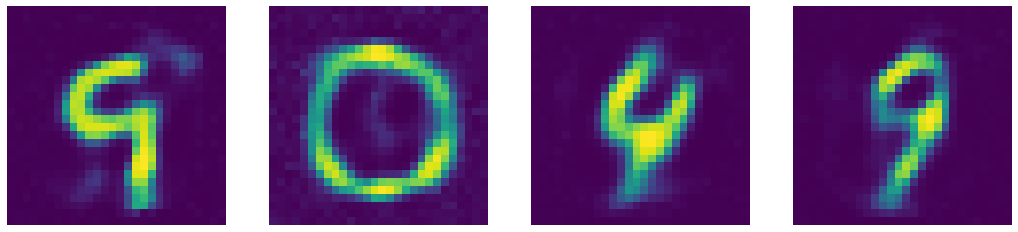

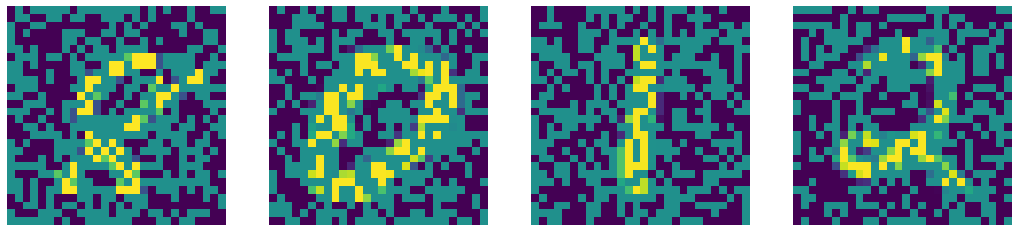

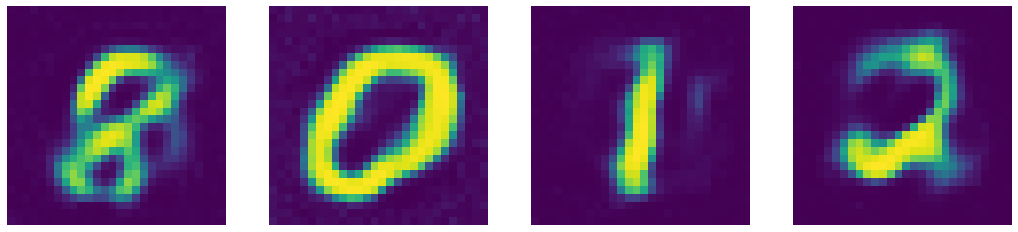

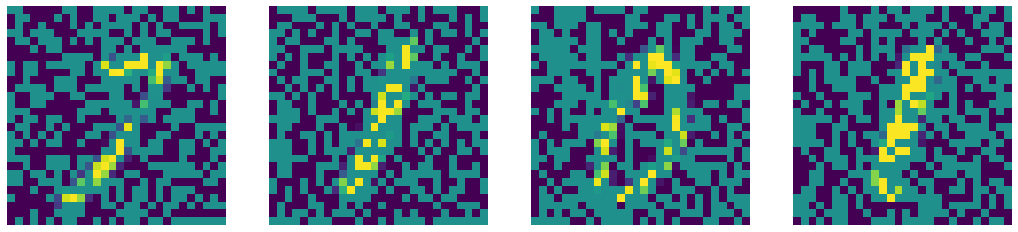

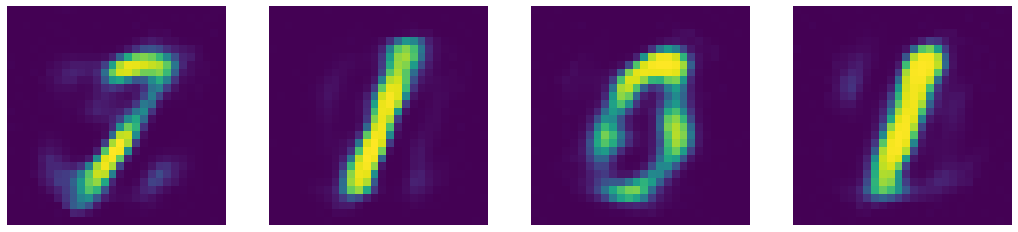

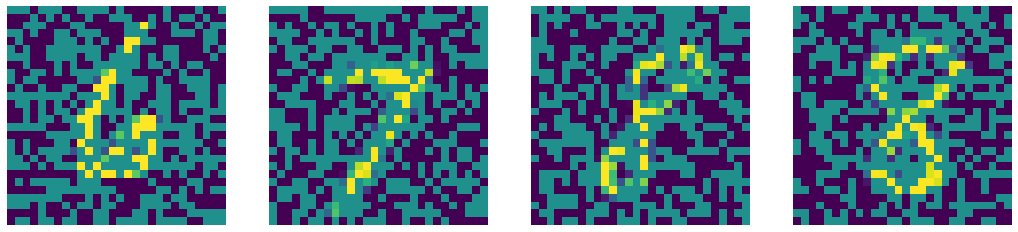

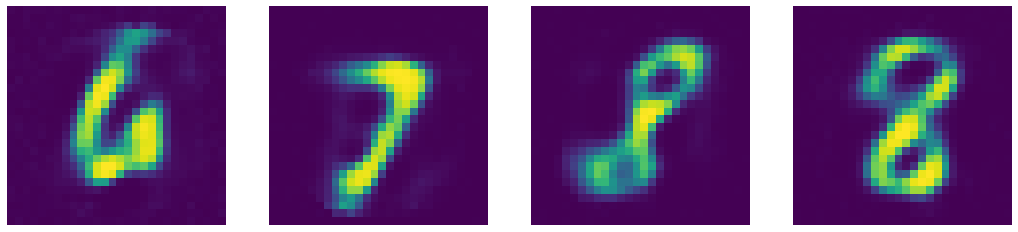

In [ ]:
d = 30
model7 = Autoencoder(d).to(device)
criterion = nn.MSELoss() # on définit un critère qui va nous servir pour la fonction de coût

learning_rate = 1e-3 # soit 0.001, ce qui est pas mal

#  l'optimizer permet d'appliquer l'algo du gradient pour minimiser le coût
optimizer7 = torch.optim.Adam(
    model7.parameters(), # permet de récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate, # permet de déterminer la vitesse à laquelle on ajuste les poids
)

nb_epoch = 20
epoch_loss_dae = training_dae(nb_epoch, model7, criterion, optimizer7)

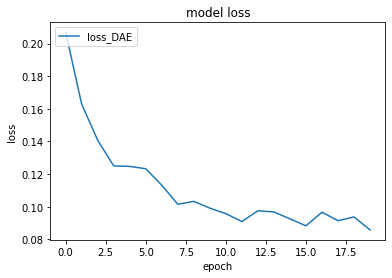

In [ ]:
displayLoss(epoch_loss_dae, ['loss_DAE'])

Quand on diminue la dimension de la couche de sortie à 30, on constate qu'on obtient une image reconstruite est moins nette que celle obtenue avec une dimension de la couche de sortie égale à 500.

- Conclusion

Que ce soit pour les auto-encodeurs standards ou débruiteurs, le choix de la dimension de sortie "d" est déterminant sur les résultats de sortie.

10. Analyse the obtained results.

11. Changes the parameters of the Autoencoder and analyse theirs impact. Conclude.

# PART2. Convolutions Neural Networks

1. Import the librariries and set the parameters

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [ ]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

set_default()

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2. Load the Dataset (MNIST) using PyTorch DataLoader utilities and visualize some images :


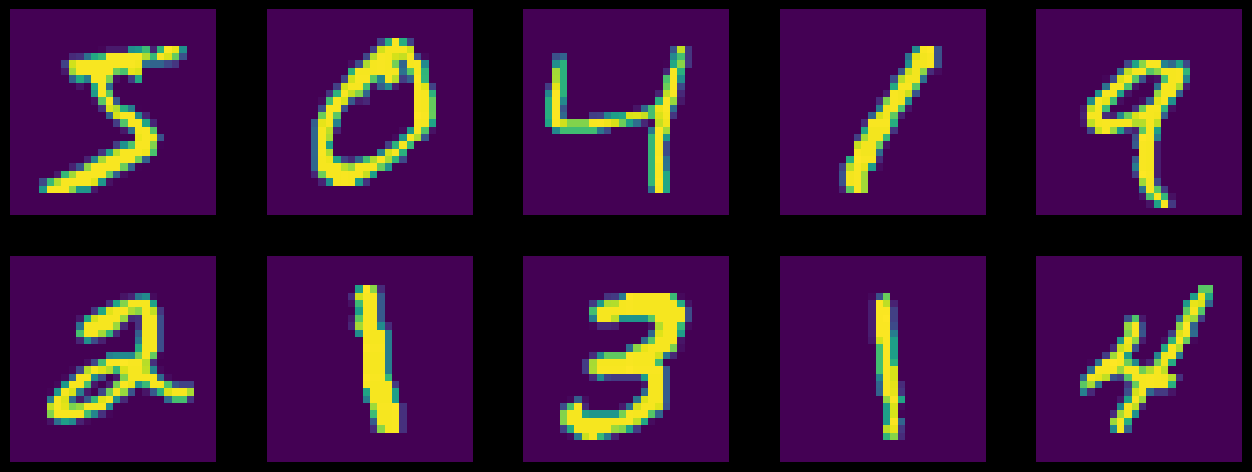

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True,
                                          transform=transforms.Compose([
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                                        ])),
                                          batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

3. Create the model classes




In [ ]:
# réseau de neurone complètement connecté
class FC2Layer(nn.Module):
  #input_size : nbre de neurones dans la couche d'entrée
  #n_hidden : nombre de neurones dans la couche cachée
  # ouput_size : nombre de neurones dans la couche de sortie
    def __init__(self, input_size, n_hidden, output_size): 
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)  # le choix de softmax comme fonction d'activation c'est parce qu'on a plusieurs classes de sorties
        )

    # prédiction de la gauche vers la droite
    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

# réseau de neurone convolutif    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)  # le choix de softmax comme fonction d'activation c'est parce qu'on a plusieurs classes de sorties
        return x

4. Run on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [ ]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

5. Train a small fully-connected network

In [ ]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.326756
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.260922
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.954755
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.540146
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.616517
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.420338
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.426857
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.396577
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.542037
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.409694

Test set: Average loss: 0.4308, Accuracy: 8733/10000 (87%)



6. Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314596
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.840167
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.655927
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.277248
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.365933
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.319842
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.237790
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.163611
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.174346
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.203623

Test set: Average loss: 0.1522, Accuracy: 9529/10000 (95%)



7. Changes the parameters of the model.

- Sur le modèle complètement connecté

In [ ]:
accuracy_list = []

def train1(epoch, model, optimizer, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
n_hidden = 20 # number of hidden units
model_fnn__ = FC2Layer1(input_size, n_hidden, output_size)
model_fnn__.to(device)
optimizer__ = optim.SGD(model_fnn__.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn__)))

for epoch in range(0, 1):
    train1(epoch, model_fnn__, optimizer__)
    test(model_fnn__)

Number of parameters: 16330
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325894
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.374940
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.750155
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.493037
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.428249
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.431456
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.482300
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.470775
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.583326
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.229713

Test set: Average loss: 0.3143, Accuracy: 9065/10000 (91%)



- Sur le modèle convolutif

On augmente le nombre de feature maps

In [ ]:
# Training settings 
n_features = 20 # number of feature maps

model_cnn_ = CNN(input_size, n_features, output_size)
model_cnn_.to(device)
optimizer_ = optim.SGD(model_cnn_.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_)))

for epoch in range(0, 1):
    train1(epoch, model_cnn_, optimizer_)
    test(model_cnn_)

Number of parameters: 27100
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304525
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.814094
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.433973
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.353931
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.221568
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.340495
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.143290
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.169826
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.085508
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.147315

Test set: Average loss: 0.1349, Accuracy: 9563/10000 (96%)



8. Analyze the results and the impact of these paremeters.

Avant la modification des paramètres, on constate :
- Sur le modèle complètement connecté, une précision de 96% sur les données d'apprentissage et de 88% sur les données de test. Avec une perte de 0.472770 sur les données d'apprentissage et de 0.4140 sur les données de test. Ce qui indique que le modèle s'est trop entrainé sur les données d'apprentissage et fait des prédictions moins bonnes sur les données de test. Il y a un sur-apprentissage. 

- Sur le modèle convolutif, On obtient une précision de 96% sur les données d'apprentissage et 95% sur les données de test. Ce qui est bien. Par contre sur la perte, on pense pouvoir faire mieux en ajoutant soit une autre couche de convolution ou en augmentant la taille des feature_maps

Après changement des paramètres, on constate :

- L'augmentation du nombre de couches cachées dans le réseau de neurone complètement connecté permet d'avoir des meilleurs résultats. En effet, avec 20 couches cachées, on passe de 88% d'accuracy à 91%. Ce qui permet d'obtenir des meilleurs résultats.

- L'augmentation du nombre des feature maps à 20 dans le réseau de neurone convolutif améliore également l'accuracy sur les données de test.